This follows Elliot's idea for a contrast:

> **proposal 1**
> 
> Two class (e.g., CorrectStop vs. CorrectGo)
> 
> Leave-One-Out classifier...
> 
> Neural similarity of a subject to the group with a Stop vs. Go contrast might actually be indicative of performance.
> 
> subjects will naturally differ across the task as to how much their average signal responds to that, and the ones with better response might have better response inhibition.

So there are a couple of steps here...

1. iterate through subjects, holding out one at a time, and do the following steps.
2. Train a classifier across all the training subjects, classifying Stop vs. Go. We can start with the beta averages since those have done so well.
3. Use that classifier as a 'neural signature' to measure Stop. No real need to go to the betaseries--just see the extent to which each subject's Stop response matches the group's.
4. After you've iterated through all subjects, you have a measure of response inhibition for each subject. See if that regresses onto SST_SSRT or any of our other measures of response inhibition.




As a first pass, we can simplify this a bit just trying that single classifier on all subjects. This means that we're using train for tes tset but it will give us an initial measure of feasibility.

We probably do need to restrict to a specific brain region though, and that means retraining. - I think that prefrontal cortex mask we have works well.

## Data already generated

Can we use data already generated in `SST_inhibition_cv.ipynb`?

In [ ]:
import pickle
from IPython.core.display import display, HTML, Markdown

In [2]:
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"

In [3]:
results_filepath=ml_data_folderpath + "/SST/train_test_results_conditions_40subs_twoclasses.pkl"

In [4]:
data_by_ppt_name = "data_by_ppt_2021_12_29.csv"

In [5]:
results_2c = pickle.load(open(results_filepath,'rb'))

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "



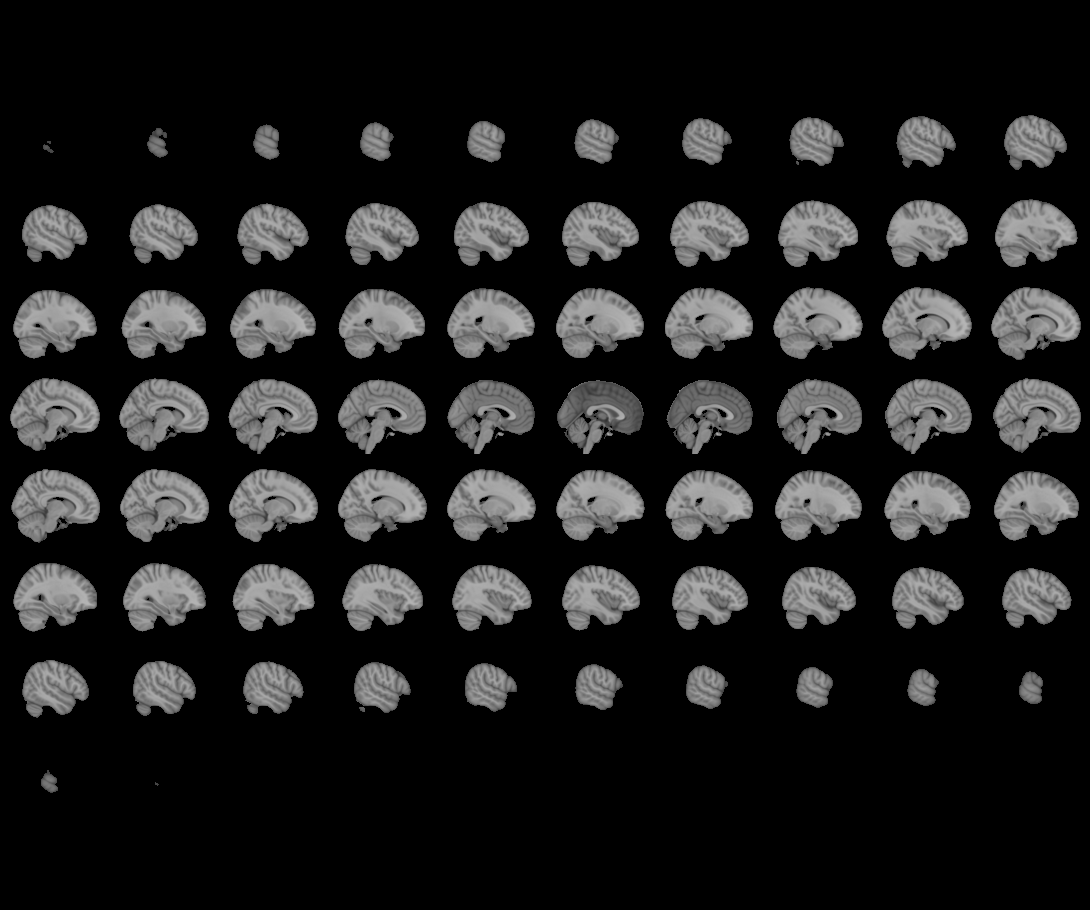
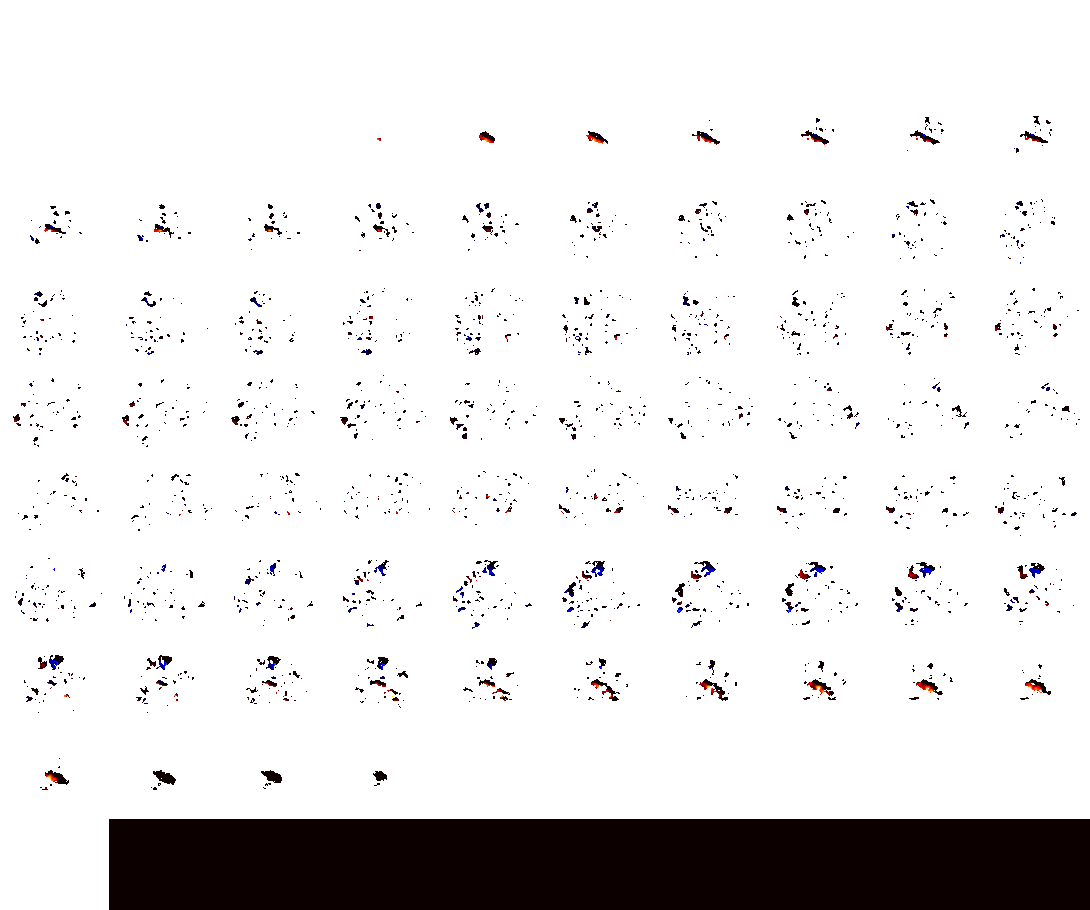

In [6]:
from nilearn import plotting
from nilearn.masking import compute_brain_mask
import nltools as nlt

plotting.view_img(results_2c[3]['CorrectGo'],threshold=0.0002)

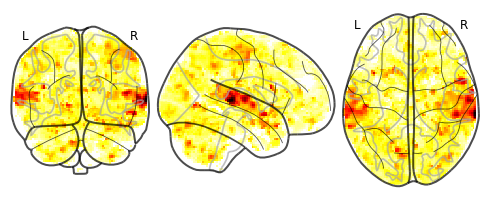

In [7]:
plotting.plot_glass_brain(results_2c[3]['CorrectGo'])


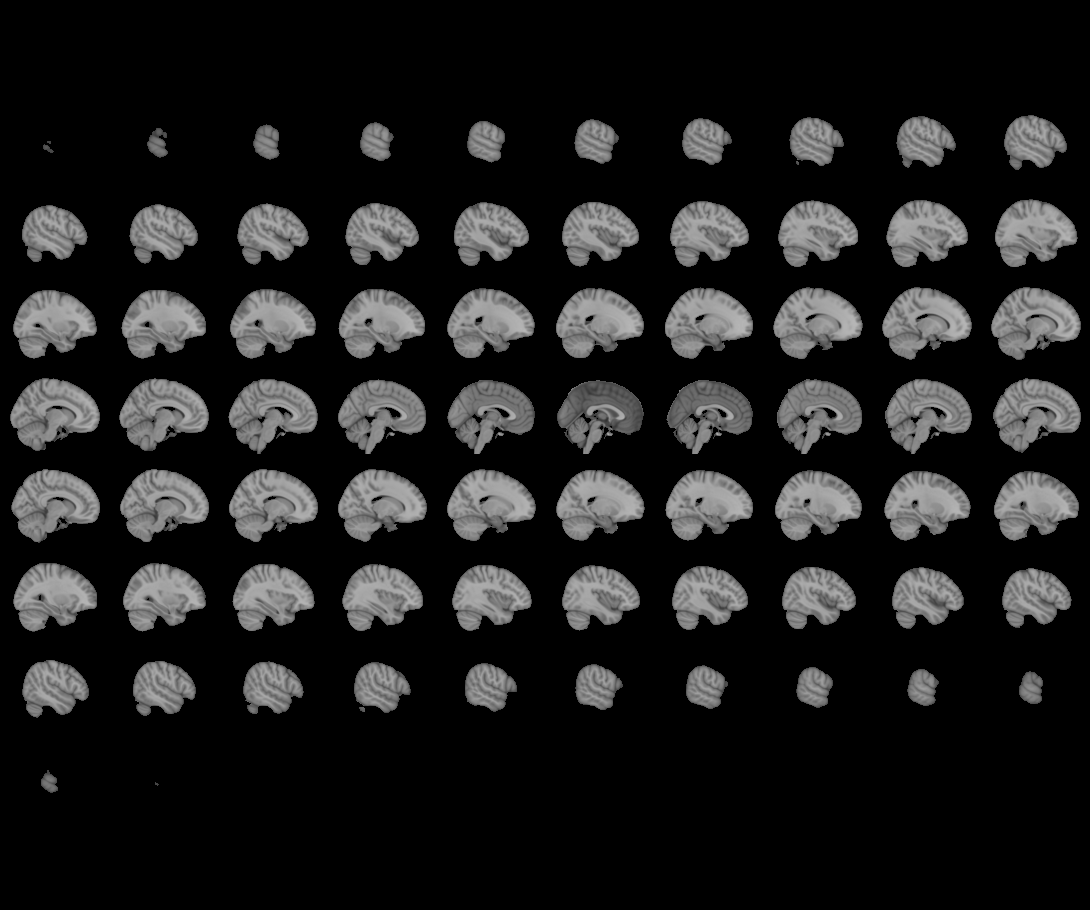
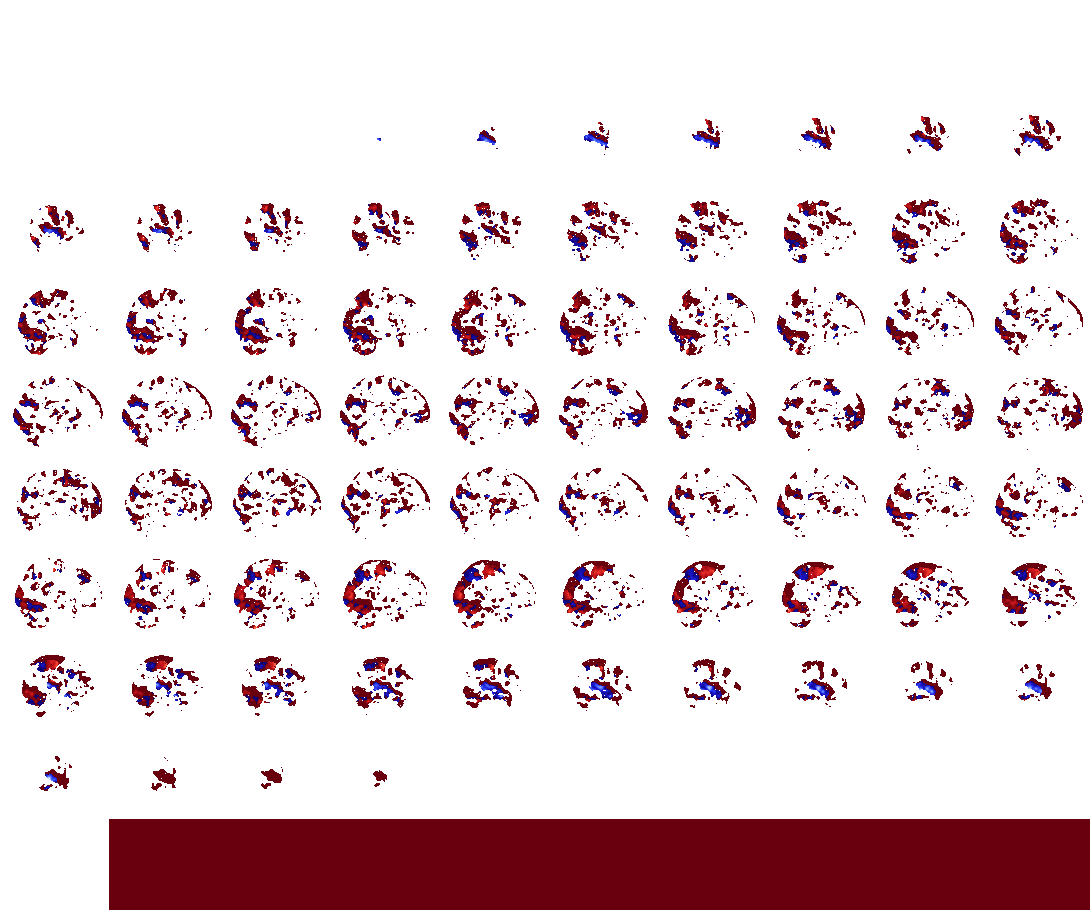

In [8]:
plotting.view_img(results_2c[3]['CorrectStop'],cmap='blue_red')

In [9]:
background_img = nlt.Brain_Data('/projects/sanlab/shared/spm12/canonical/MNI152_T1_1mm_brain.nii').to_nifti()

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


Not quite--we need a PFC mask I think. But we can use the script already written to do that.

## Setup

In [10]:
import sys
import os
import pandas as pd

sys.path.append(os.path.abspath("../../ml/"))

from apply_loocv_and_save import *
from dev_wtp_io_utils import *
import gc
import nibabel as nib

from os import path



python initialized for apply_loocv_and_save
4


## 2-class classification with PFC mask

In [11]:


nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"
train_test_markers_filepath = ml_data_folderpath + "/train_test_markers_20210601T183243.csv"
test_train_df = pd.read_csv(train_test_markers_filepath)

all_sst_events= pd.read_csv(ml_data_folderpath +"/SST/" + "all_sst_events.csv")


dataset_name = 'conditions'

from nilearn.decoding import DecoderRegressor, Decoder

script_path = '/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml'
# HRF 2s

#get a PFC mask
pfc_mask = create_mask_from_images(get_pfc_image_filepaths(ml_data_folderpath + "/"),threshold=10)

In [12]:

def condition_resp_trans_func(X):
    return(X.condition_label)


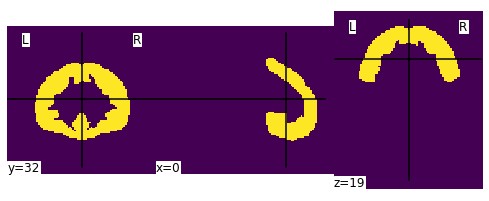

In [13]:
from nilearn import plotting
plotting.plot_img(pfc_mask)

In [14]:
brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_84subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_58subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_43subs_correct_cond.pkl'

In [15]:
#set vars for the function

#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_40subs_twoclasses_pfcmask_repeat1.pkl"
results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_pfcmask.pkl"
#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_58subs_twoclasses_pfcmask_repeat1.pkl"

def decoderConstructor(*args, **kwargs):
    return(Decoder(scoring='accuracy',verbose=0, *args, **kwargs))

In [16]:
if path.exists(results_filepath) is False:
    apply_loocv_and_save(
        results_filepath = results_filepath,
        brain_data_filepath = brain_data_filepath,
        train_test_markers_filepath = train_test_markers_filepath,
#        subjs_to_use = 60,
        decoderConstructor = decoderConstructor,
        response_transform_func=condition_resp_trans_func,
        mask=pfc_mask
    )

In [17]:
results=pickle.load(open(results_filepath,'rb'))


In [18]:
np.mean(results[0])

0.8641975308641975

In [19]:
results[3]

{'CorrectGo': <nibabel.nifti1.Nifti1Image at 0x2aaaedd71250>,
 'CorrectStop': <nibabel.nifti1.Nifti1Image at 0x2aaaedd71430>}


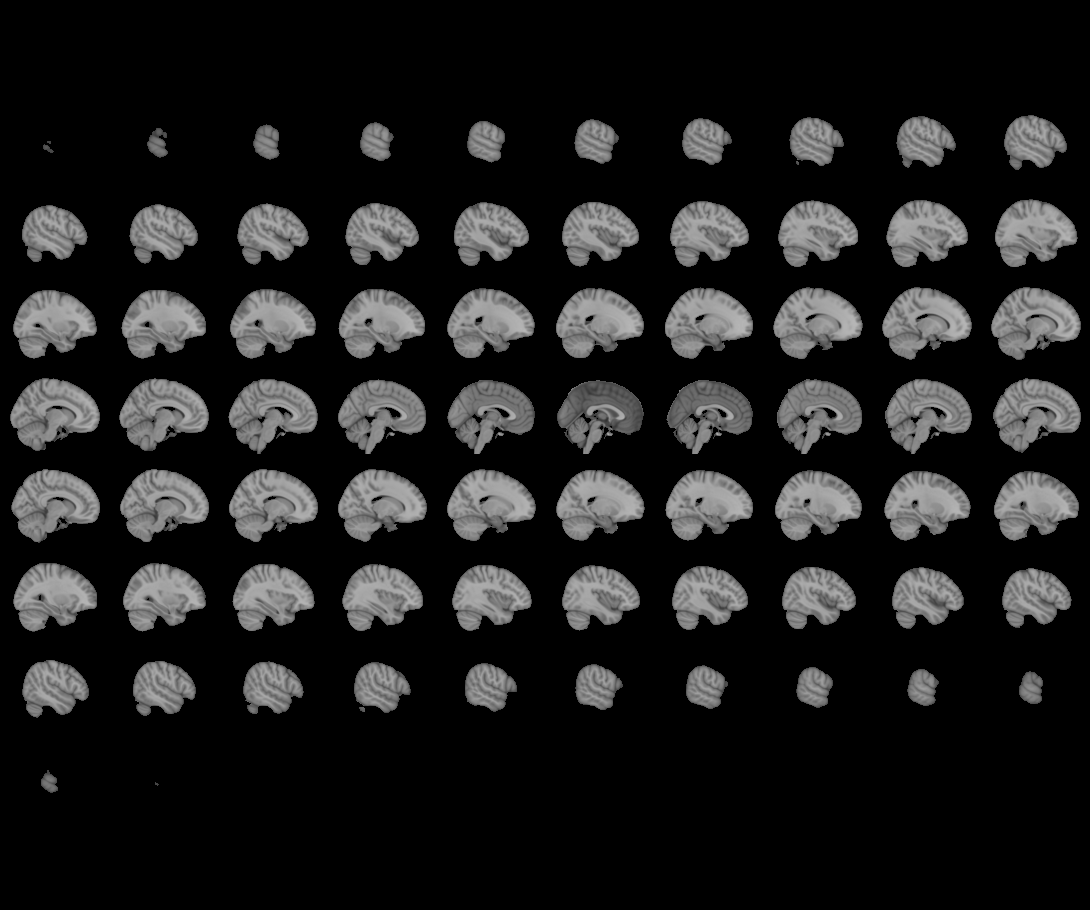
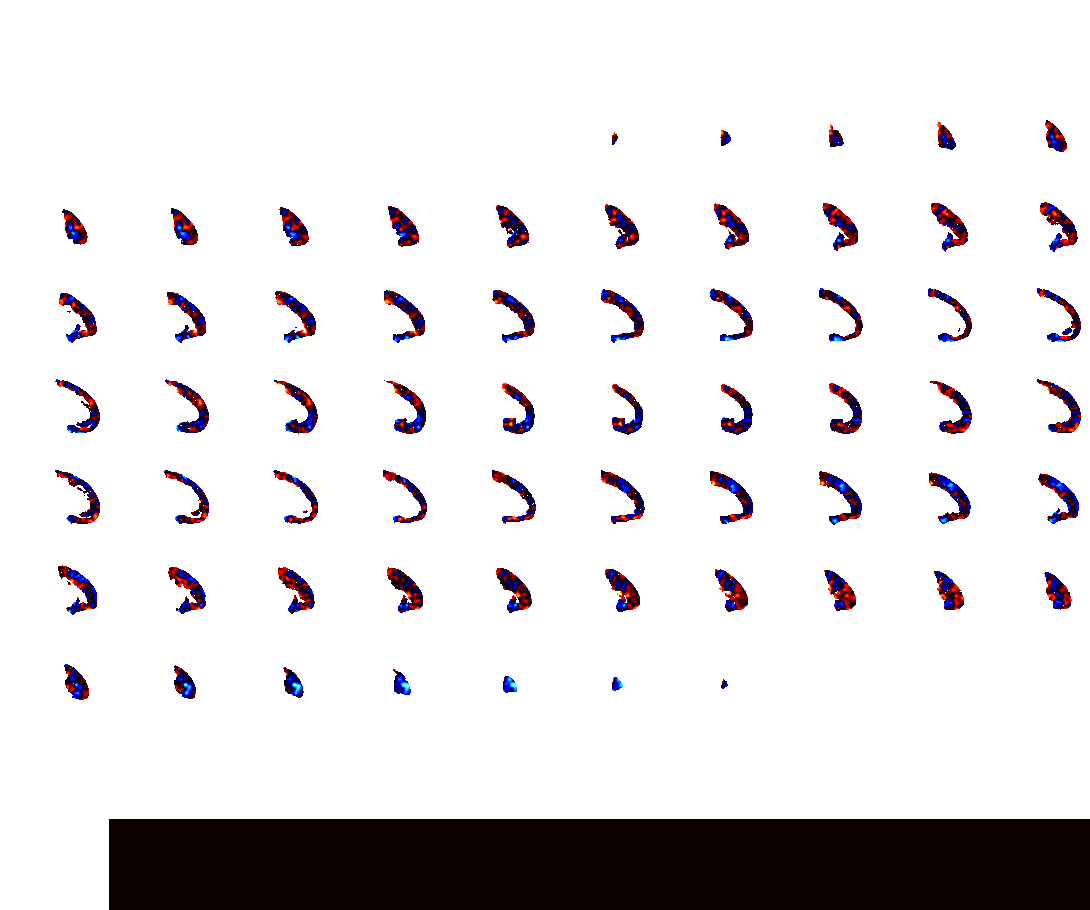

In [20]:
correct_stop_ns=results[3]['CorrectStop']
plotting.view_img(correct_stop_ns,
    cmap='cold_hot')

In [21]:
vis_thresh = 0.0002

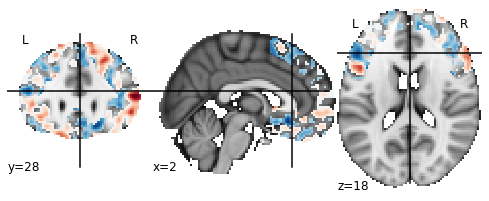

In [22]:
plotting.plot_img(correct_stop_ns,
    threshold=vis_thresh,
    cmap='RdBu',
    bg_img=background_img)

In [23]:
from nilearn import surface
from nilearn import datasets
from nilearn import plotting
fsaverage = datasets.fetch_surf_fsaverage()

texture_left = surface.vol_to_surf(correct_stop_ns, fsaverage.pial_left)
texture_right = surface.vol_to_surf(correct_stop_ns, fsaverage.pial_right)

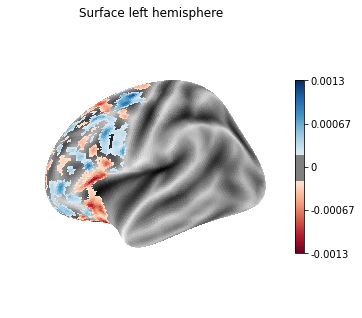

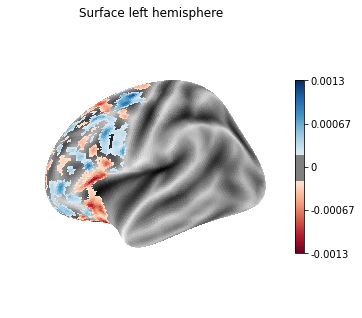

In [24]:
plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left, hemi='left',
                            title='Surface left hemisphere', colorbar=True,
                            threshold=vis_thresh, bg_map=fsaverage.sulc_left,cmap='RdBu')

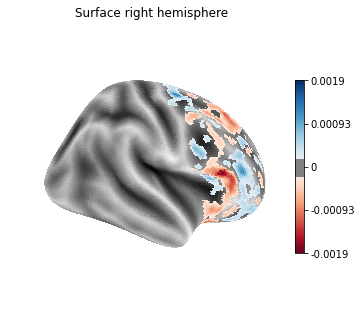

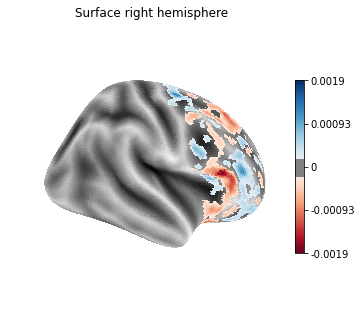

In [25]:
plotting.plot_surf_stat_map(fsaverage.infl_right, texture_right, hemi='right',
                            title='Surface right hemisphere', colorbar=True,
                            threshold=vis_thresh, bg_map=fsaverage.sulc_right,cmap='RdBu')

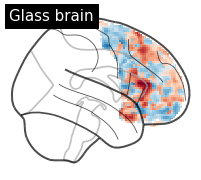

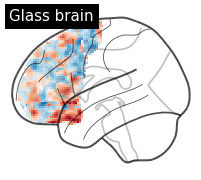

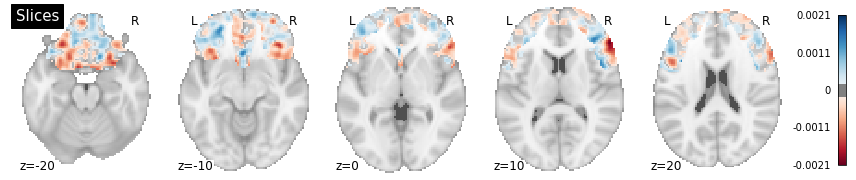

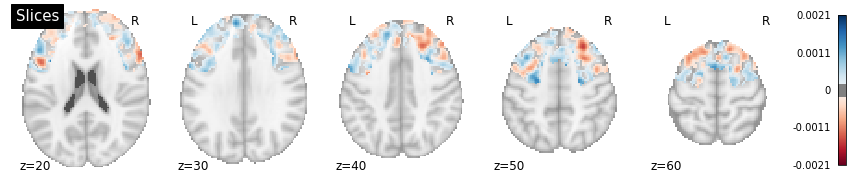

In [26]:
plotting.plot_glass_brain(correct_stop_ns, display_mode='r', plot_abs=False,
                          title='Glass brain', threshold=vis_thresh,cmap='RdBu')

plotting.plot_glass_brain(correct_stop_ns, display_mode='l', plot_abs=False,
                          title='Glass brain', threshold=vis_thresh,cmap='RdBu')

plotting.plot_stat_map(correct_stop_ns, display_mode='z', threshold=vis_thresh,
                       cut_coords=range(-20, 21, 10), title='Slices',cmap='RdBu')
plotting.plot_stat_map(correct_stop_ns, display_mode='z', threshold=vis_thresh,
                       cut_coords=range(20, 61, 10), title='Slices',cmap='RdBu')

Now we use this nifti image as a neural signature to measure 'stop' in each subject. So that means we go back to the brain data, and classify each beta for each subject's fit to the CorrectStop neural signature.

Remember here, each beta corresponds to ALL activity of a particular type for each subject.

In [27]:
bd=pickle.load(open(brain_data_filepath,'rb'))


In [28]:
bd_correctStop=bd[bd.X.condition_label=="CorrectStop"]

In [29]:
correct_stop_similarity = bd.apply_mask(pfc_mask).similarity(correct_stop_ns)
bd.X['CS_similarity'] = correct_stop_similarity


In [30]:
bd.X.groupby('condition_label').agg({'CS_similarity':"mean"})

CS_similarity
condition_label               
CorrectGo             0.103523
CorrectStop           0.010555

So far so good! 

In [31]:
bd.X

condition_index condition_label  \
0                 0       CorrectGo   
1                 1     CorrectStop   
0                 0       CorrectGo   
1                 1     CorrectStop   
0                 0       CorrectGo   
..              ...             ...   
1                 1     CorrectStop   
0                 0       CorrectGo   
1                 1     CorrectStop   
0                 0       CorrectGo   
1                 1     CorrectStop   

                             raw_beta_description           beta subject  \
0     spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV005   
1   spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV005   
0     spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV006   
1   spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV006   
0     spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV010   
..                                            ...            ...     ...   
1   spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV216   
0     spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV217   
1   spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV217   
0     spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV218   
1   spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV218   

    wave  CS_similarity  
0      1       0.036635  
1      1       0.035972  
0      1       0.109364  
1      1       0.036907  
0      1       0.073130  
..   ...            ...  
1      1      -0.039040  
0      1       0.108045  
1      1      -0.010278  
0      1       0.138326  
1      1       0.059533  

[162 rows x 7 columns]

In [32]:
bd_to_plot = bd.X[['condition_label','CS_similarity','subject']].pivot(index='subject',columns='condition_label',values='CS_similarity').reset_index()

In [33]:
from matplotlib import pyplot

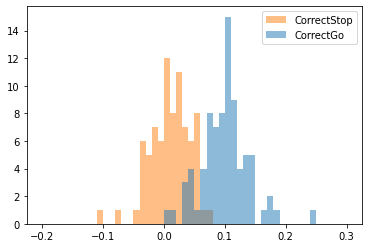

In [34]:
bins=np.linspace(-0.2,0.3,51) #create histogram bins
pyplot.hist(
    bd_to_plot[['CorrectGo','CorrectStop']]#.to_numpy()
    ,bins=bins
    ,alpha=0.5,histtype='stepfilled',label=['CorrectGo','CorrectStop'])
pyplot.legend(prop={'size': 10})

In [35]:
bd_to_plot[['CorrectGo','CorrectStop']]

condition_label  CorrectGo  CorrectStop
0                 0.036635     0.035972
1                 0.109364     0.036907
2                 0.073130     0.007721
3                 0.044833    -0.023136
4                 0.098908    -0.015626
..                     ...          ...
76                0.085655    -0.017507
77                0.102493     0.036534
78                0.015812    -0.039040
79                0.108045    -0.010278
80                0.138326     0.059533

[81 rows x 2 columns]

Looks very good. I wonder if those are correlated, too?...never mind, let's just keep trying.

One puzzling thing: we're supposed to be measuring CorrectStop, but the similarity score is higher for CorrectGo. Why would that be?

Let's see what the result looks like for CorrectGo.
    

In [36]:
correct_go_ns=results[3]['CorrectGo']
correct_go_similarity = bd.apply_mask(pfc_mask).similarity(correct_go_ns)
bd.X['CG_similarity'] = correct_go_similarity

In [37]:
bd.X.groupby('condition_label').agg({'CG_similarity':"mean"})

CG_similarity
condition_label               
CorrectGo            -0.103523
CorrectStop          -0.010555

In [38]:
bd.X.loc[:,['CG_similarity','CS_similarity']]

CG_similarity  CS_similarity
0       -0.036635       0.036635
1       -0.035972       0.035972
0       -0.109364       0.109364
1       -0.036907       0.036907
0       -0.073130       0.073130
..            ...            ...
1        0.039040      -0.039040
0       -0.108045       0.108045
1        0.010278      -0.010278
0       -0.138326       0.138326
1       -0.059533       0.059533

[162 rows x 2 columns]

hmm ok they're actually just inverses of each other. But also...

In [39]:
HTML(pd.DataFrame(bd.X.groupby('condition_label').agg({
    'CG_similarity':"mean",
    'CS_similarity':"mean"})).to_html())

'CorrectStop' events are generally not particularly similar; generally uncorrelated with CGSimiliarity or CSSimilarity. 

In other words, we have a "CorrectStop" and a "CorrectGo" signature trained. But the CorrectGo signature seems to be trained _against_ CorrectGo, while the CorrectStop is trained _in favour_ of recognizing.

So both _signatures_ are working. But each signature mainly works by tracking activity in the _CorrectGo_ condition and not responding to the _CorrectStop_ condition.

However, below, we are definitely just looking at CorrectStop neural signature scores, and still get a good result. But we might be measuring mostly the extent to which a CorrectStop beta resembles CorrectGo signal. Higher is stronger...

In [40]:
individual_differences = pd.read_csv(ml_data_folderpath + "/" + data_by_ppt_name)
individual_differences = individual_differences.rename(columns={'SID':'subject'})
individual_differences['wave']=1
#individual_differences['wave'] = individual_differences['wave'].astype(object) # for compatibility with the wave column in the dataset

In [41]:
subject_cs_neural_performance = bd.X.loc[bd.X.condition_label=='CorrectStop',['subject','CS_similarity','CG_similarity']]
subject_cg_neural_performance = bd.X.loc[bd.X.condition_label=='CorrectGo',['subject','CS_similarity','CG_similarity']]

subject_cs_neural_performance.columns = ['CS_trials_' + col for col in subject_cs_neural_performance.columns]
subject_cg_neural_performance.columns = ['CG_trials_' + col for col in subject_cg_neural_performance.columns]
subject_neural_performance = subject_cs_neural_performance.merge(subject_cg_neural_performance,left_on='CS_trials_subject',right_on='CG_trials_subject',how='outer')

In [42]:
subject_neural_performance =subject_neural_performance.rename(columns = {'CS_trials_subject':'subject'})

In [43]:
ind_div_combined = subject_neural_performance.merge(individual_differences,left_on='subject',right_on='subject',how='left')

In [44]:
", ".join(ind_div_combined.columns)

'subject, CS_trials_CS_similarity, CS_trials_CG_similarity, CG_trials_subject, CG_trials_CS_similarity, CG_trials_CG_similarity, cancer_promoting_minus_preventing_FCI, cancer_promoting_minus_preventing_FFQ, cancer_promoting_minus_preventing_craved_FCI, cancer_promoting_minus_preventing_craved_FFQ, cancer_promoting_minus_preventing_liked_FCI, cancer_promoting_minus_preventing_liked_FFQ, cancer_promoting_FCI, cancer_promoting_FFQ, cancer_preventing_FCI, cancer_preventing_FFQ, BSCS, cSES, EDM, BIS_11, PCS, RS, TRSQ, bf_1, weight_0, height_0, birthsex, age365, bmi_0, bmi_1, bmi, bf_1_controlled, bf_1_bsexnormedzs, ACES_sum, ACES_household_dysfunction, ACES_neglectful_parenting, ACES_abuse, ACES_divorced_separated, BFI_agreeableness, BFI_conscientiousness, BFI_extraversion, BFI_neuroticism, BFI_openness, DEMO_mcarthur_social_standing, IMI_effort_importance, IMI_interest_enjoyment, IMI_perceived_choice, IMI_perceived_competence, IMI_value_usefulness, IPAQ_moderateminutes, IPAQ_sittinghours, 

In [45]:
# from analyze_results import *

# def remove_selected_outliers(ind_div_combined,show_plot=False):
#     for cname in ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies','SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
#                       'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction', 'TESQ_E_goal_and_rule_setting',
#                      'EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look','SRHI_unhealthy','CS_trials_CS_similarity','CG_trials_CG_similarity', 'cancer_promoting_minus_preventing_FFQ','bf_1']:
#         display(HTML(cname))
#         ind_div_combined[cname] = outlier_detection_median_sd(ind_div_combined[cname],show_plot=show_plot)
#     return(ind_div_combined)

# ind_div_combined = remove_selected_outliers(ind_div_combined,show_plot=True)

In [46]:
from analyze_results import remove_selected_outliers

In [48]:

def remove_selected_outliers_tesq_study(ind_div_combined,show_plot=False):
    idc_outliers_removed = remove_selected_outliers(ind_div_combined,
    ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies',
     'SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
     'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction',
     'TESQ_E_goal_and_rule_setting','EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look',
     'SRHI_unhealthy','CS_trials_CS_similarity','CG_trials_CG_similarity',
     'cancer_promoting_minus_preventing_FFQ','bf_1'],
    show_plot=show_plot)
    return(idc_outliers_removed)

26.0 20.266128342428956 5.733871657571044 46.266128342428956


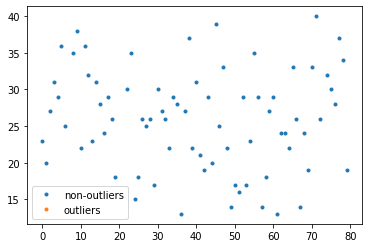

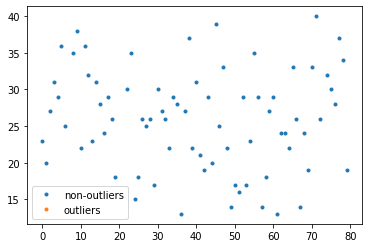

26.0 20.266128342428956 5.733871657571044 46.266128342428956


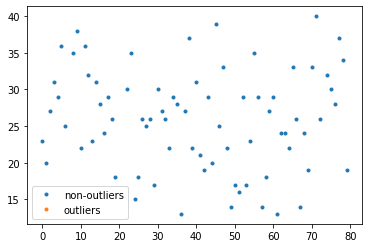

76 , 76


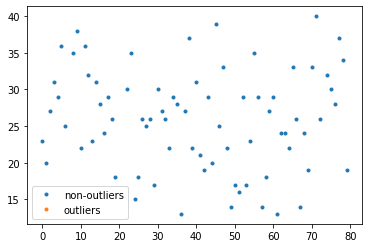

76 , 76


4.458333333333335 1.6898243675770521 2.7685089657562827 6.148157700910387


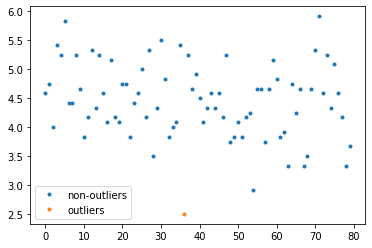

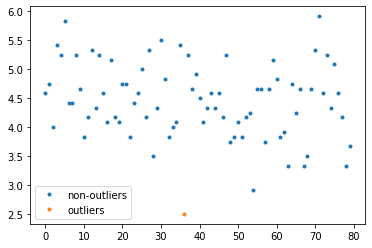

4.458333333333335 1.6898243675770521 2.7685089657562827 6.148157700910387


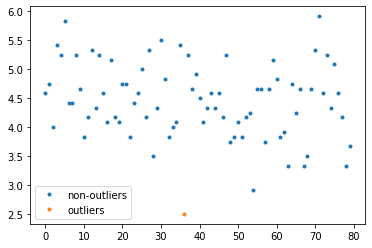

80 , 79
4.5 1.6895886466474699 2.81041135335253 6.18958864664747


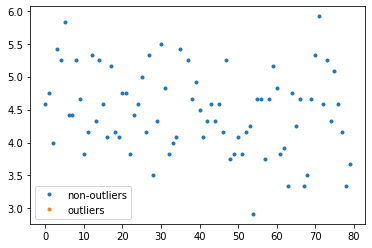

79 , 79


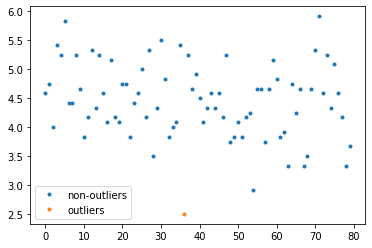

80 , 79


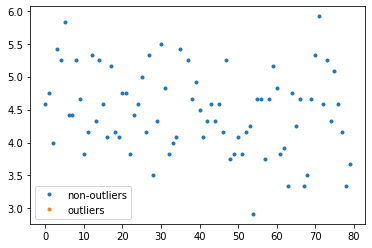

79 , 79


-0.029198517658926098 2.0272800228666514 -2.0564785405255774 1.9980815052077254


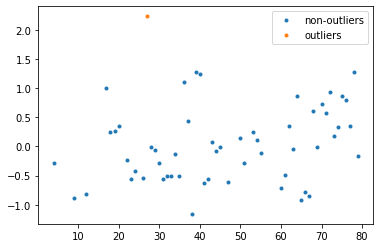

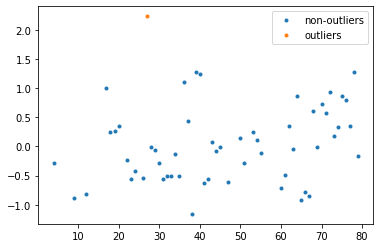

-0.029198517658926098 2.0272800228666514 -2.0564785405255774 1.9980815052077254


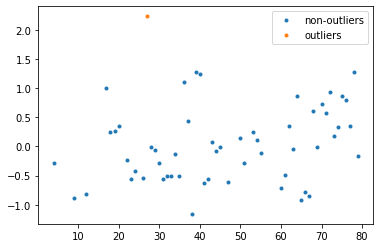

56 , 55
-0.04359384351429142 1.9200402150485443 -1.9636340585628358 1.8764463715342528


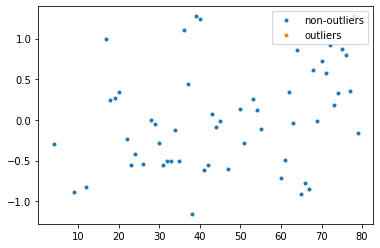

55 , 55


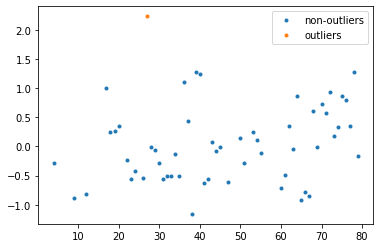

56 , 55


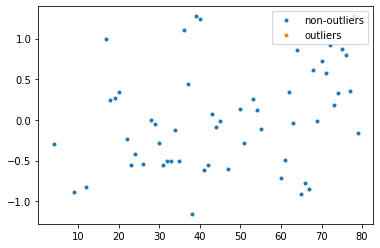

55 , 55


3.7 2.7021504456571925 0.9978495543428076 6.402150445657193


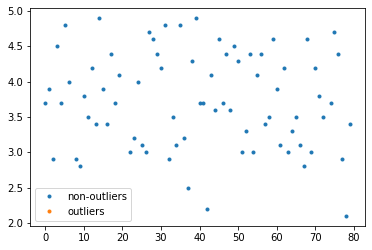

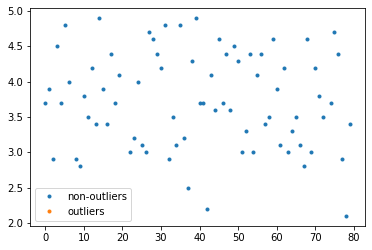

3.7 2.7021504456571925 0.9978495543428076 6.402150445657193


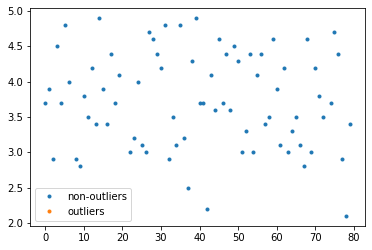

76 , 76


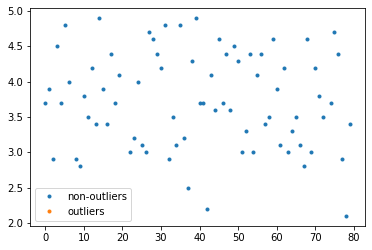

76 , 76


312.9325410023739 182.14878318668306 130.78375781569085 495.081324189057


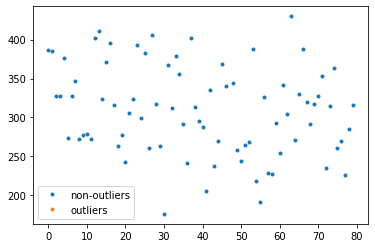

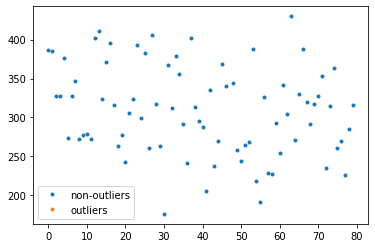

312.9325410023739 182.14878318668306 130.78375781569085 495.081324189057


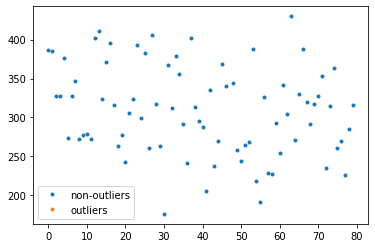

79 , 79


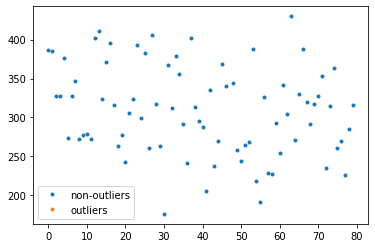

79 , 79


63.0 28.16373945961754 34.83626054038246 91.16373945961755


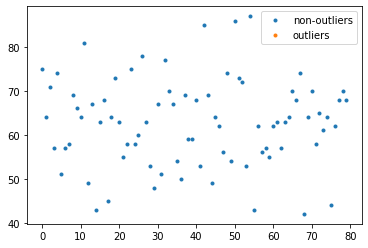

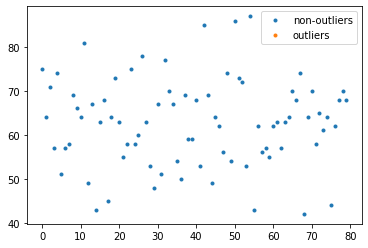

63.0 28.16373945961754 34.83626054038246 91.16373945961755


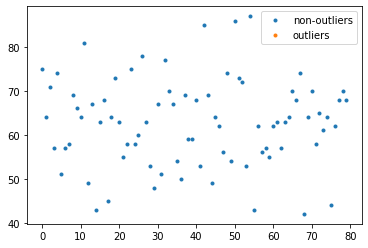

80 , 80


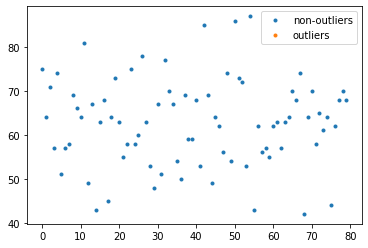

80 , 80


3.30769230769231 1.4723255633388697 1.8353667443534405 4.78001787103118


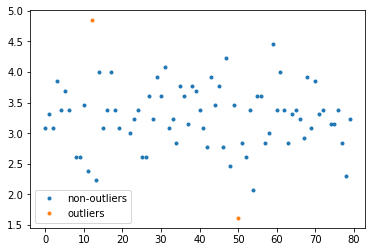

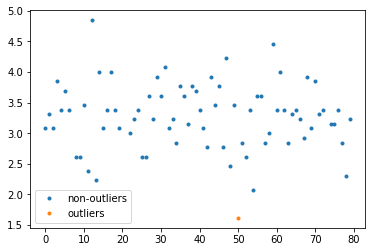

3.30769230769231 1.4723255633388697 1.8353667443534405 4.78001787103118


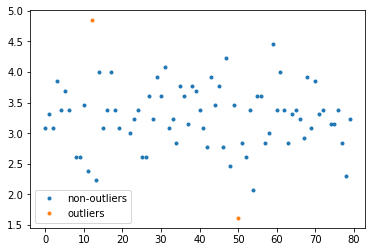

76 , 74
3.30769230769231 1.3852831642481158 1.9224091434441943 4.692975471940426


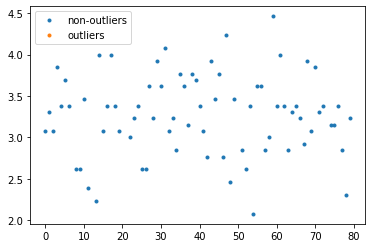

74 , 74


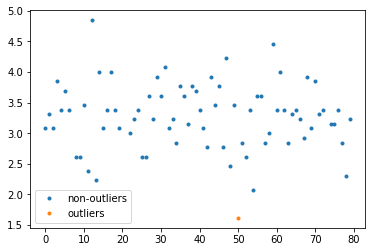

76 , 75


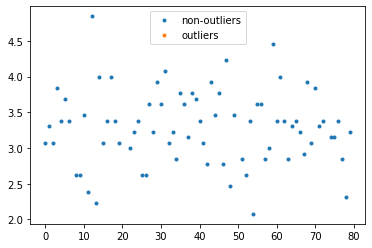

75 , 75


8.0 9.005773331715183 -1.005773331715183 17.005773331715183


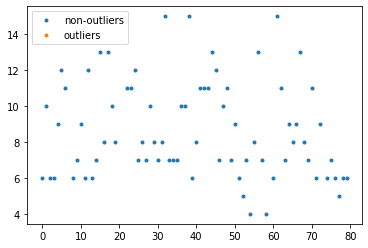

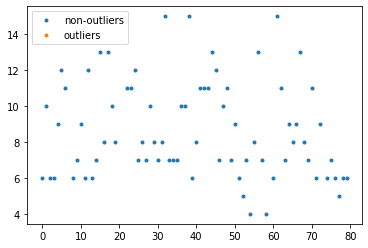

8.0 9.005773331715183 -1.005773331715183 17.005773331715183


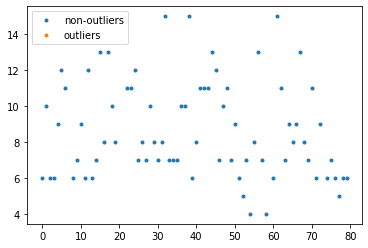

75 , 75


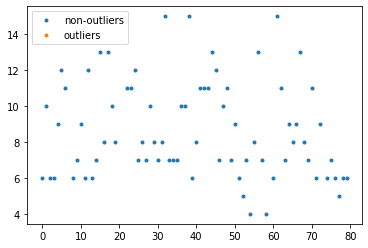

75 , 75


8.0 9.005773331715183 -1.005773331715183 17.005773331715183


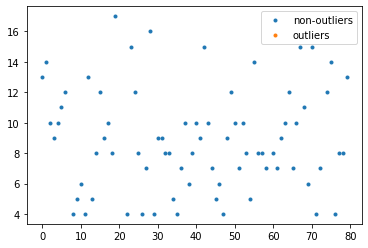

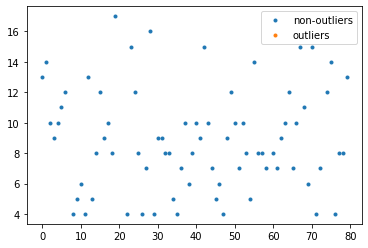

8.0 9.005773331715183 -1.005773331715183 17.005773331715183


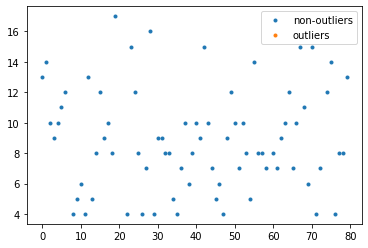

75 , 75


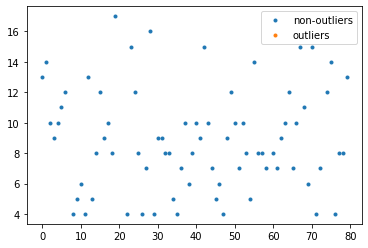

75 , 75


9.0 6.754329998786387 2.245670001213613 15.754329998786387


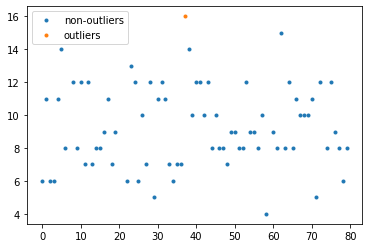

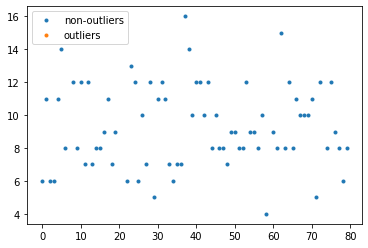

9.0 6.754329998786387 2.245670001213613 15.754329998786387


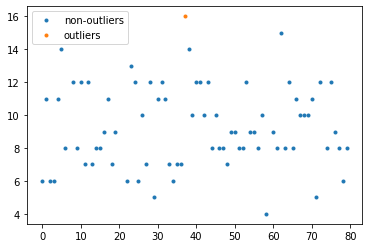

75 , 74
9.0 6.753255425709515 2.246744574290485 15.753255425709515


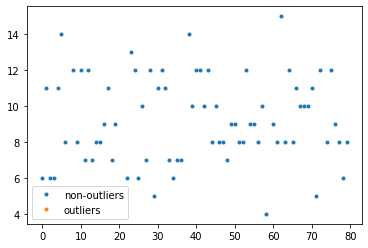

74 , 74


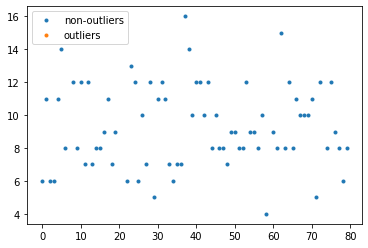

75 , 75


9.0 9.005773331715183 -0.0057733317151829056 18.005773331715183


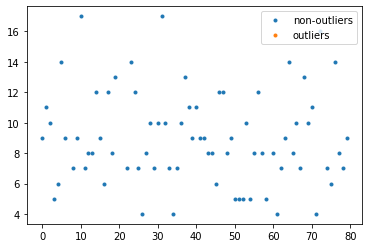

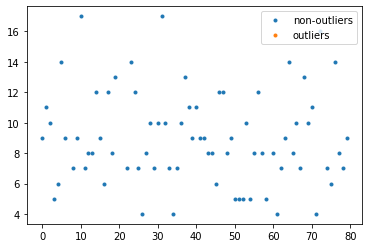

9.0 9.005773331715183 -0.0057733317151829056 18.005773331715183


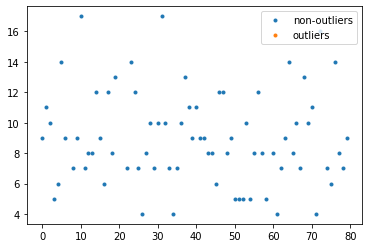

75 , 75


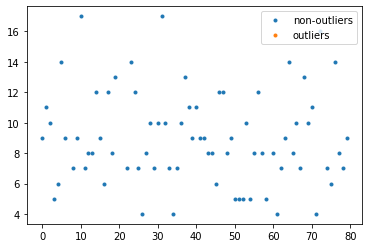

75 , 75


7.0 9.005773331715183 -2.005773331715183 16.005773331715183


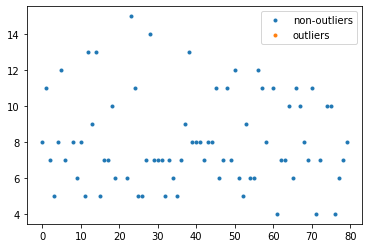

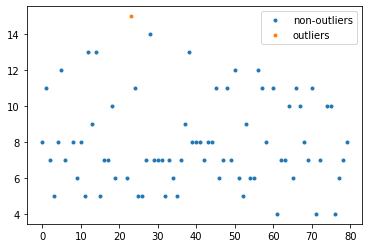

7.0 9.005773331715183 -2.005773331715183 16.005773331715183


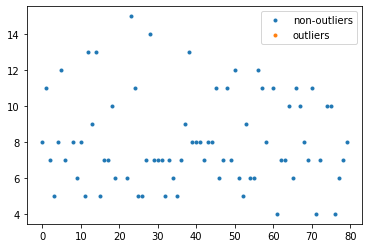

75 , 75


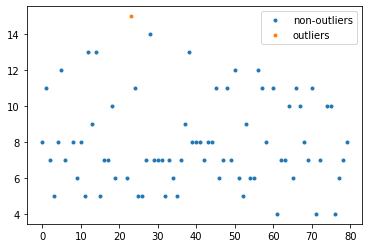

75 , 74


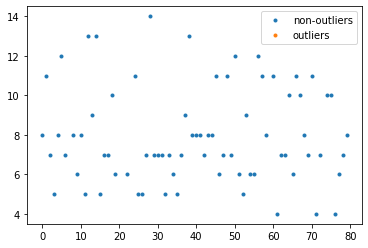

74 , 74


9.0 7.880051665250785 1.119948334749215 16.880051665250786


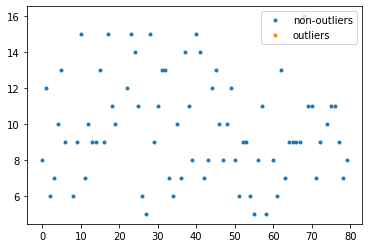

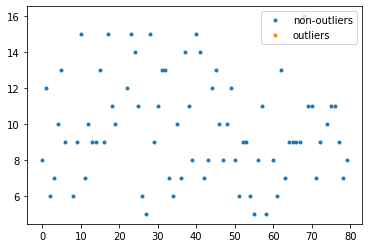

9.0 7.880051665250785 1.119948334749215 16.880051665250786


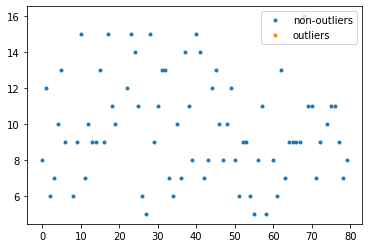

75 , 75


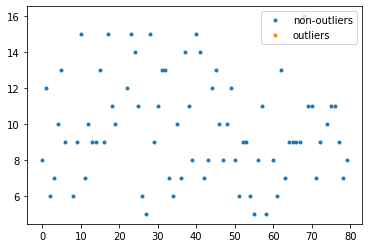

75 , 75


2.9375 2.3939178540674906 0.5435821459325094 5.331417854067491


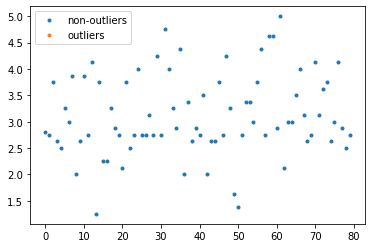

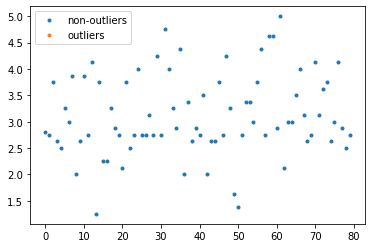

2.9375 2.3939178540674906 0.5435821459325094 5.331417854067491


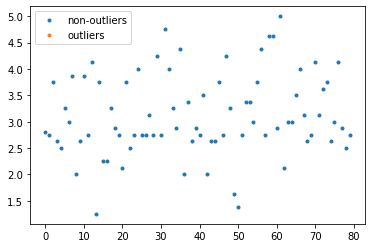

80 , 80


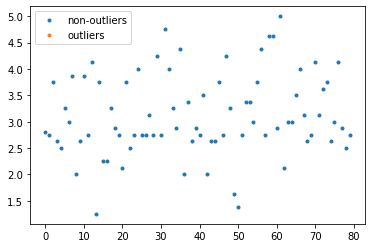

80 , 80


18.0 10.13753187988482 7.86246812011518 28.13753187988482


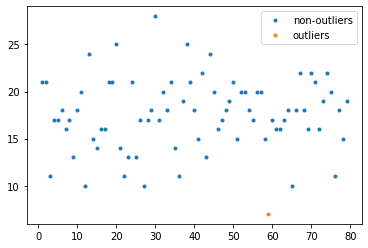

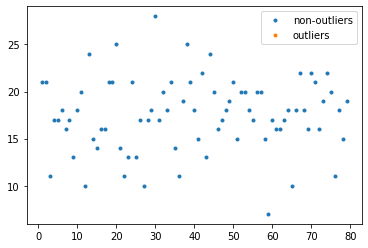

18.0 10.13753187988482 7.86246812011518 28.13753187988482


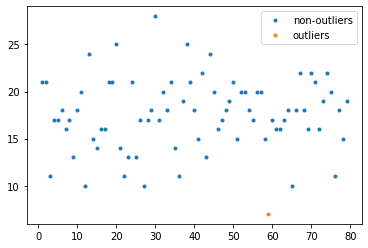

79 , 78
18.0 9.009849835836068 8.990150164163932 27.009849835836068


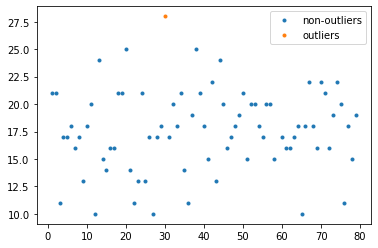

78 , 77
18.0 9.008526516622485 8.991473483377515 27.008526516622485


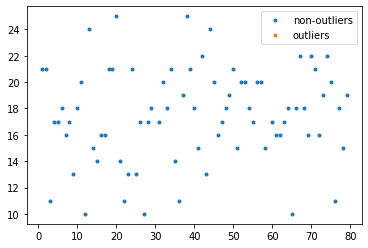

77 , 77


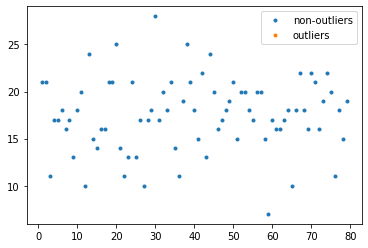

79 , 79


64.0 29.268763328074343 34.73123667192566 93.26876332807434


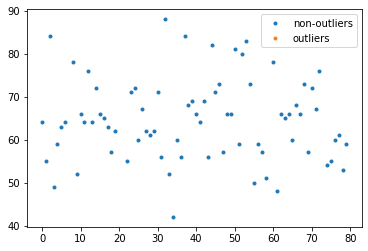

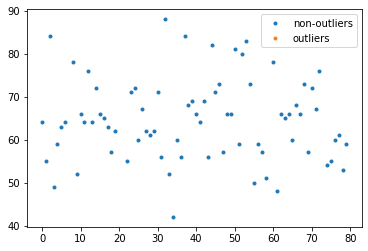

64.0 29.268763328074343 34.73123667192566 93.26876332807434


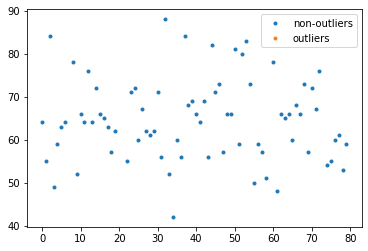

75 , 75


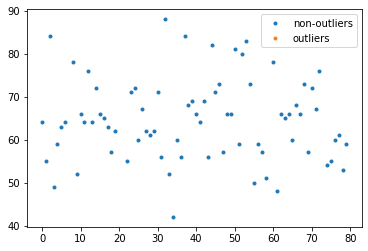

75 , 75


-1.1 2.0638697020107046 -3.1638697020107047 0.9638697020107045


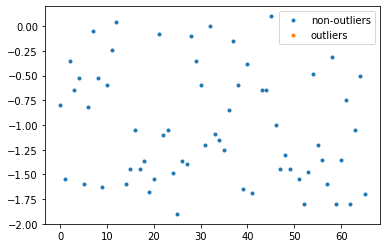

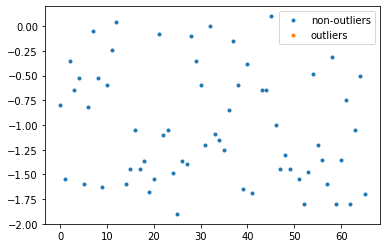

-1.1 2.0638697020107046 -3.1638697020107047 0.9638697020107045


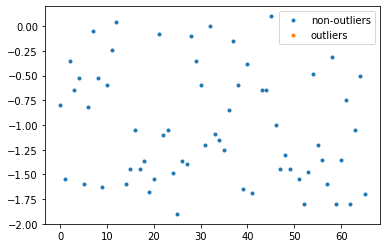

63 , 63


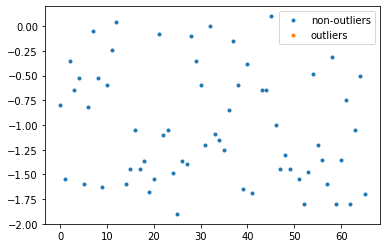

63 , 63


46.5 29.273296494619604 17.226703505380396 75.7732964946196


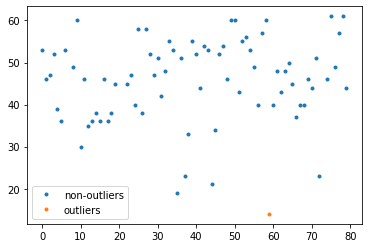

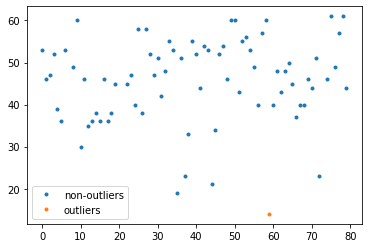

46.5 29.273296494619604 17.226703505380396 75.7732964946196


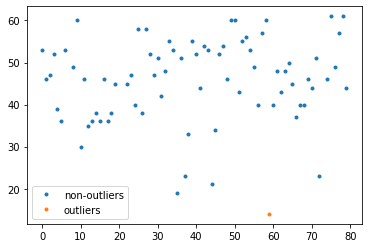

76 , 75
47.0 29.268763328074343 17.731236671925657 76.26876332807434


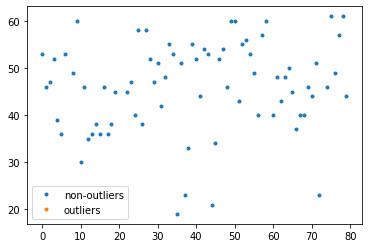

75 , 75


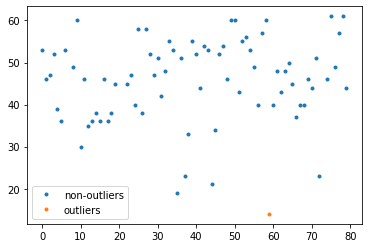

76 , 75


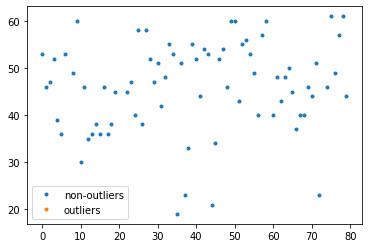

75 , 75


0.011186181182608989 0.10421994278970502 -0.09303376160709603 0.115406123972314


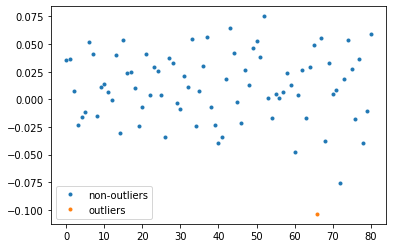

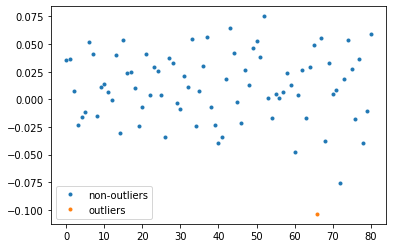

0.011186181182608989 0.10421994278970502 -0.09303376160709603 0.115406123972314


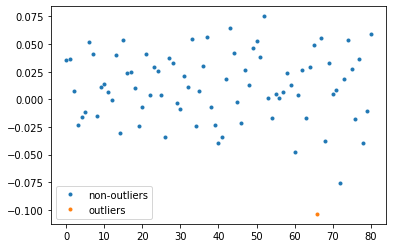

81 , 80
0.01122393519341719 0.10330533802257373 -0.09208140282915654 0.11452927321599092


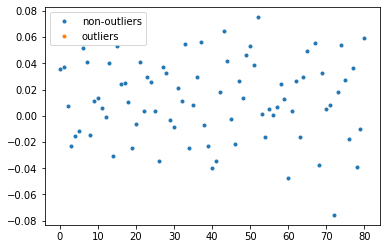

80 , 80


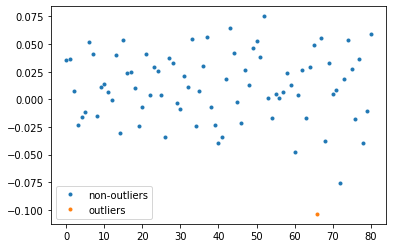

81 , 80


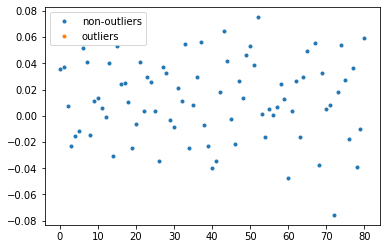

80 , 80


-0.10147903283545597 0.09233042523502714 -0.1938094580704831 -0.00914860760042882


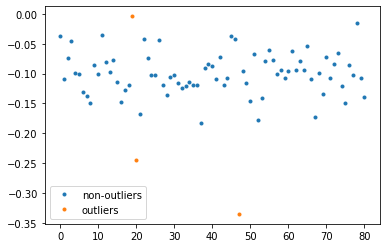

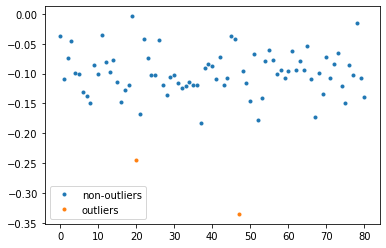

-0.10147903283545597 0.09233042523502714 -0.1938094580704831 -0.00914860760042882


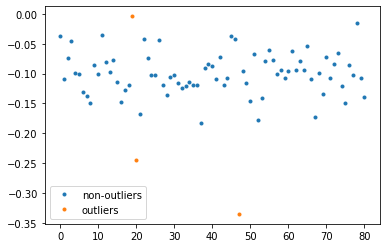

81 , 78
-0.10140477243168314 0.09026738920962696 -0.1916721616413101 -0.01113738322205618


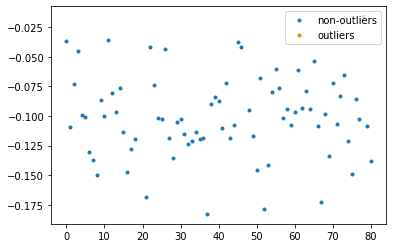

78 , 78


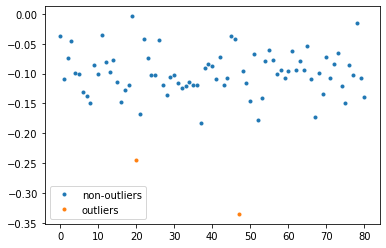

81 , 79


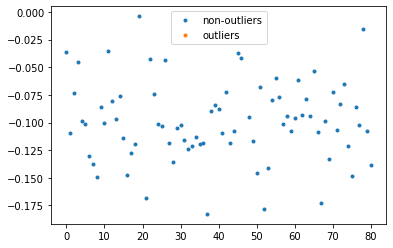

79 , 79


-0.3057692307692349 1.3648581430430025 -1.6706273738122372 1.0590889122737677


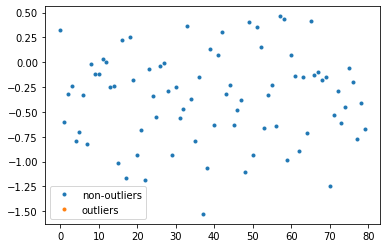

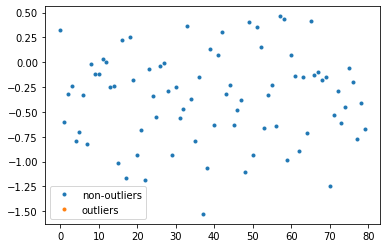

-0.3057692307692349 1.3648581430430025 -1.6706273738122372 1.0590889122737677


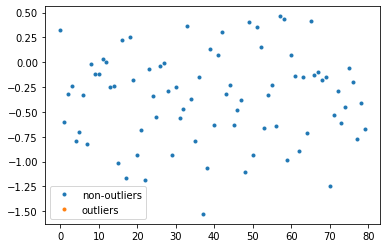

80 , 80


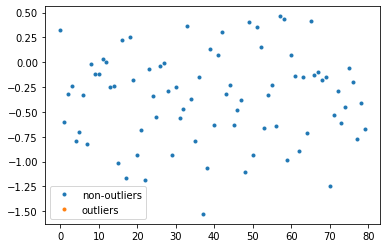

80 , 80


40.15 23.178488718680573 16.971511281319426 63.328488718680575


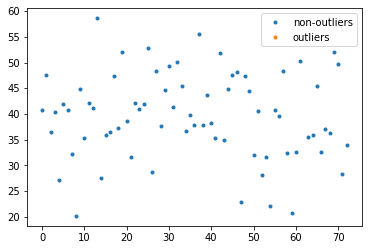

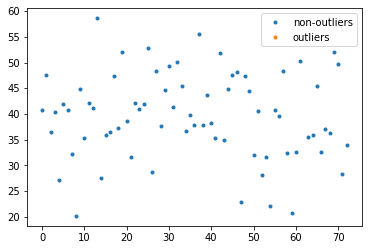

40.15 23.178488718680573 16.971511281319426 63.328488718680575


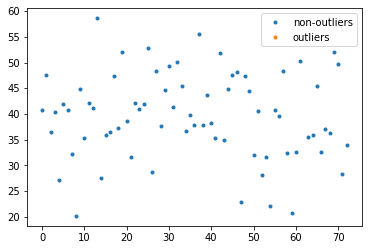

72 , 72


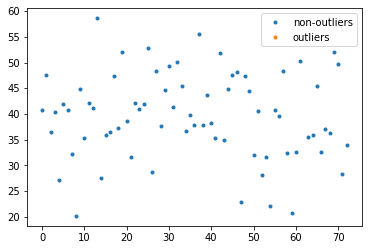

72 , 72


In [49]:
#from analyze_results import remove_selected_outliers


ind_div_combined_3sd = remove_selected_outliers_tesq_study(
    ind_div_combined,
    show_plot=True)

In [84]:
from scipy.stats import pearsonr,spearmanr

### CS_trials_CS_similarity

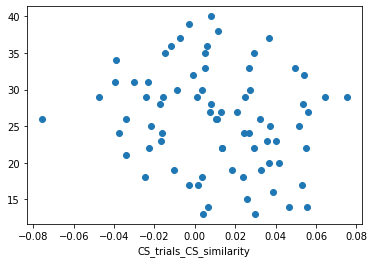

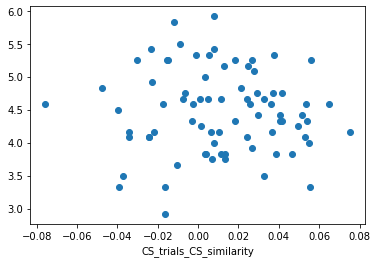

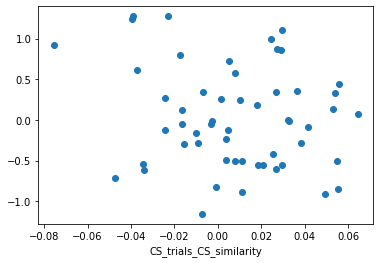

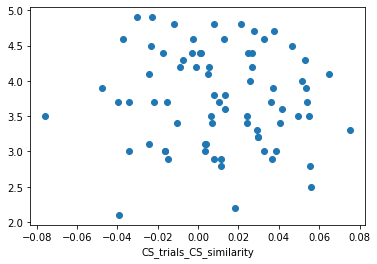

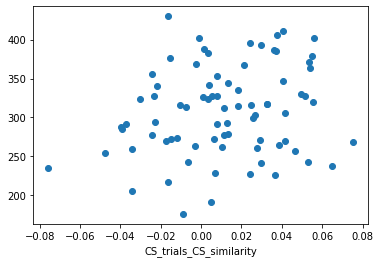

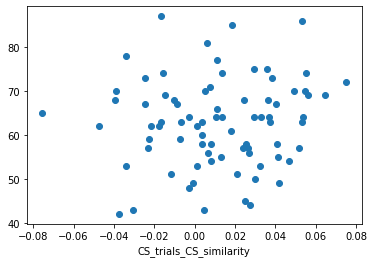

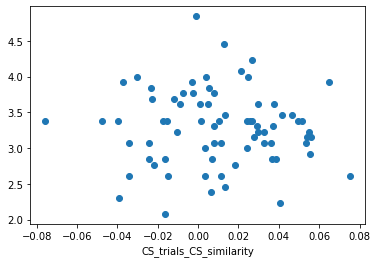

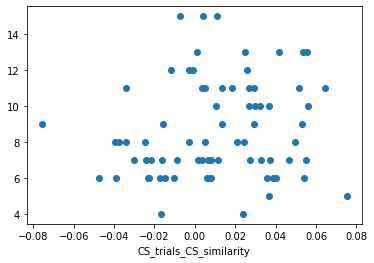

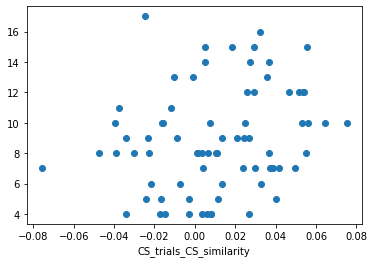

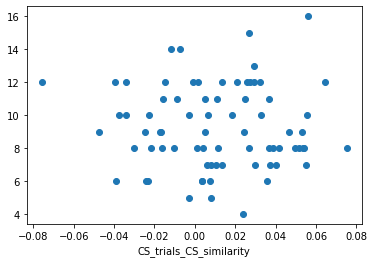

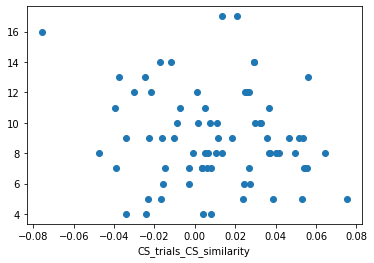

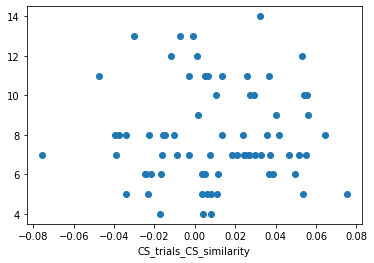

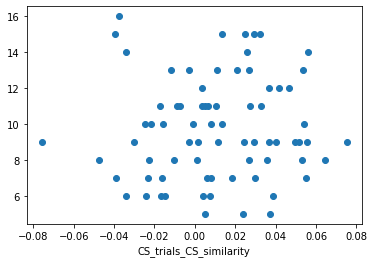

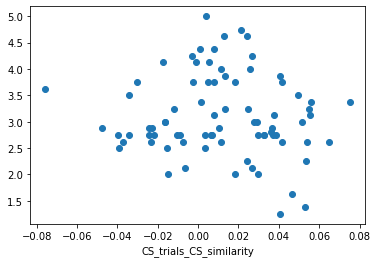

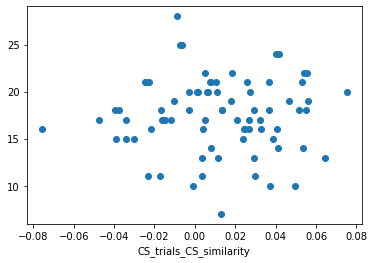

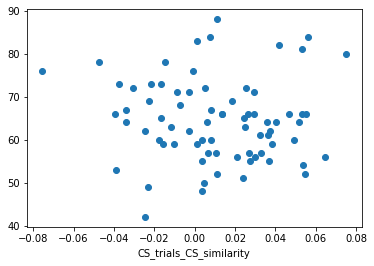

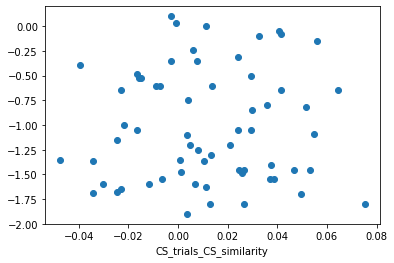

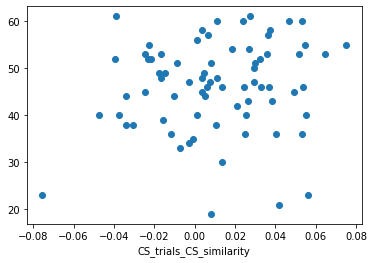

### CG_trials_CG_similarity

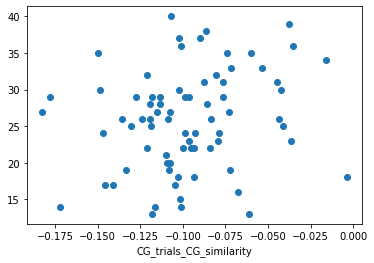

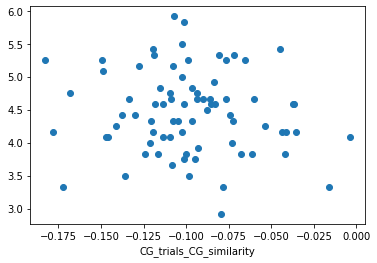

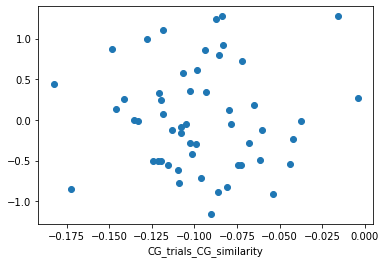

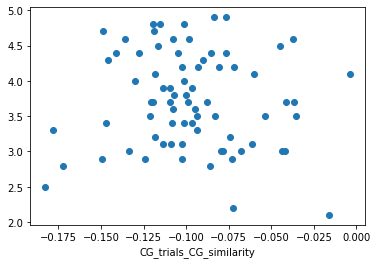

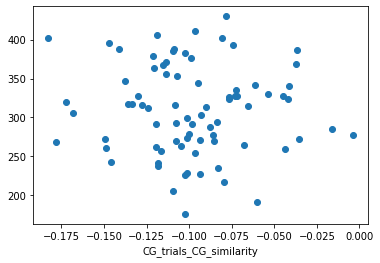

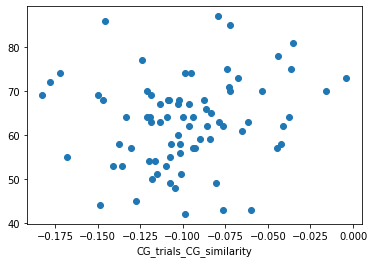

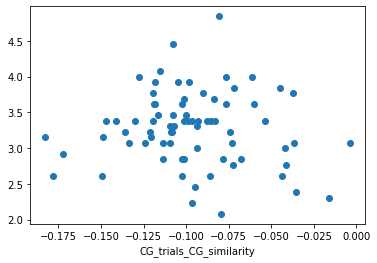

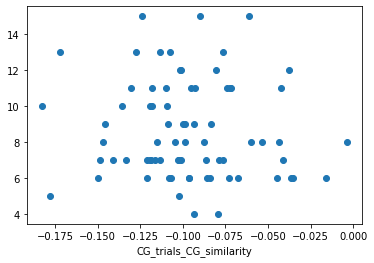

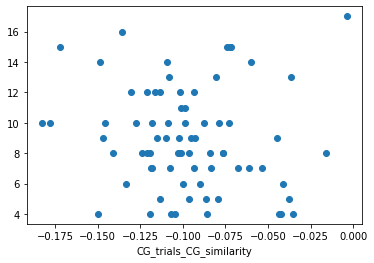

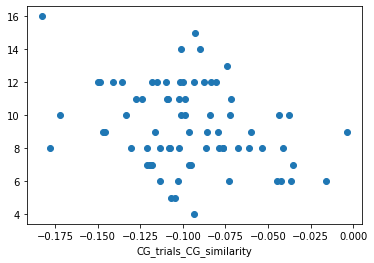

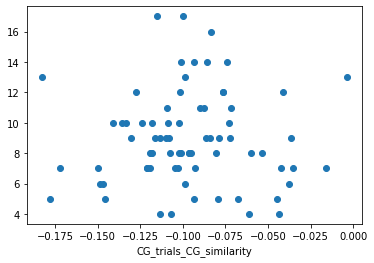

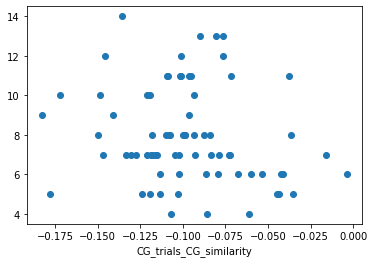

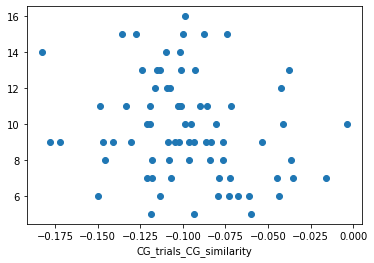

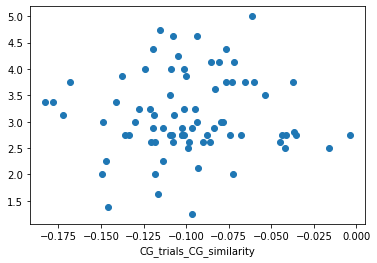

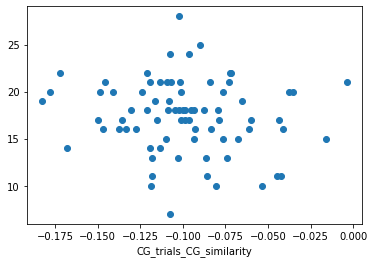

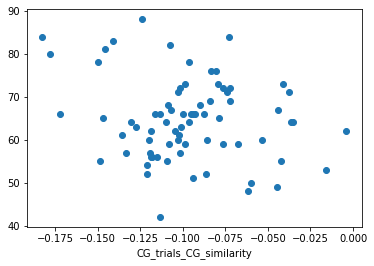

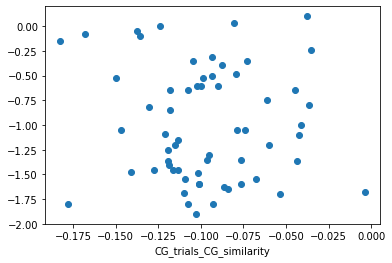

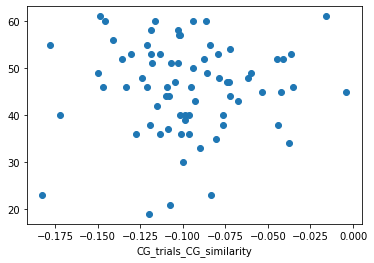

In [51]:
for neural_var in ['CS_trials_CS_similarity','CG_trials_CG_similarity']:
    display(Markdown("### " + neural_var))
    for correlate in ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies','SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
                      'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction', 'TESQ_E_goal_and_rule_setting',
                     'EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look','SRHI_unhealthy']:
        display(HTML(correlate))
        nan_rows = np.isnan(ind_div_combined_3sd[correlate]) | np.isnan(ind_div_combined_3sd[neural_var])
        cor2way_df = ind_div_combined_3sd.loc[nan_rows==False,]
        pearson_result = pearsonr(cor2way_df[neural_var],cor2way_df[correlate])
        display(HTML("r=" + format(pearson_result[0],".2f") +"; p-value=" + format(pearson_result[1],".4f")))
        spearman_result = spearmanr(cor2way_df[neural_var],cor2way_df[correlate])
        display(HTML("rho=" + format(spearman_result[0],".2f") +"; p-value=" + format(spearman_result[1],".4f")))
        cplot = pyplot.scatter(cor2way_df[neural_var],cor2way_df[correlate])
        cplot.axes.set_xlabel(neural_var)
        cplot.axes.ylabel=correlate
        pyplot.show()

In [52]:
cor2way_df

subject  CS_trials_CS_similarity  CS_trials_CG_similarity  \
0   DEV005                 0.035972                -0.035972   
1   DEV006                 0.036907                -0.036907   
2   DEV010                 0.007721                -0.007721   
3   DEV011                -0.023136                 0.023136   
4   DEV013                -0.015626                 0.015626   
..     ...                      ...                      ...   
75  DEV197                 0.027507                -0.027507   
76  DEV206                -0.017507                 0.017507   
77  DEV215                 0.036534                -0.036534   
78  DEV216                -0.039040                 0.039040   
79  DEV217                -0.010278                 0.010278   

   CG_trials_subject  CG_trials_CS_similarity  CG_trials_CG_similarity  \
0             DEV005                 0.036635                -0.036635   
1             DEV006                 0.109364                -0.109364   
2             DEV010                 0.073130                -0.073130   
3             DEV011                 0.044833                -0.044833   
4             DEV013                 0.098908                -0.098908   
..               ...                      ...                      ...   
75            DEV197                 0.148599                -0.148599   
76            DEV206                 0.085655                -0.085655   
77            DEV215                 0.102493                -0.102493   
78            DEV216                 0.015812                -0.015812   
79            DEV217                 0.108045                -0.108045   

    cancer_promoting_minus_preventing_FCI  \
0                                0.083871   
1                                0.430645   
2                               -0.661290   
3                                0.698387   
4                               -0.227419   
..                                    ...   
75                               0.676344   
76                               1.133871   
77                              -0.077957   
78                               1.033333   
79                              -0.519892   

    cancer_promoting_minus_preventing_FFQ  \
0                                0.321154   
1                               -0.603846   
2                               -0.323077   
3                               -0.242308   
4                               -0.788462   
..                                    ...   
75                              -0.057692   
76                              -0.194231   
77                              -0.773077   
78                              -0.405769   
79                              -0.676923   

    cancer_promoting_minus_preventing_craved_FCI  \
0                                       0.044086   
1                                       0.449462   
2                                      -0.815054   
3                                       0.947312   
4                                      -0.320430   
..                                           ...   
75                                      1.046237   
76                                      1.474194   
77                                      0.176344   
78                                      1.149462   
79                                     -0.559140   

    cancer_promoting_minus_preventing_craved_FFQ  ...  \
0                                            NaN  ...   
1                                            NaN  ...   
2                                            NaN  ...   
3                                            NaN  ...   
4                                            NaN  ...   
..                                           ...  ...   
75                                           NaN  ...   
76                                           NaN  ...   
77                                           NaN  ...   
78                                           NaN  ...   
79         

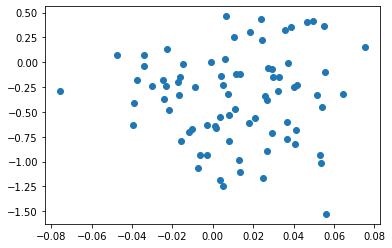

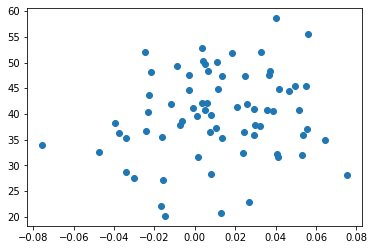

In [55]:
for correlate in ['cancer_promoting_minus_preventing_FFQ','bf_1']:
    display(HTML(correlate))
    nan_rows = np.isnan(ind_div_combined_3sd[correlate]) | np.isnan(ind_div_combined_3sd['CS_trials_CS_similarity'])
    cor2way_df = ind_div_combined_3sd.loc[nan_rows==False,]
    pearson_result = pearsonr(cor2way_df.CS_trials_CS_similarity,cor2way_df[correlate])
    display(HTML("r=" + format(pearson_result[0],".2f") +"; p-value=" + format(pearson_result[1],".4f")))
    spearman_result = spearmanr(cor2way_df.CS_trials_CS_similarity,cor2way_df[correlate])
    display(HTML("rho=" + format(spearman_result[0],".2f") +"; p-value=" + format(spearman_result[1],".4f")))
    cplot = pyplot.scatter(cor2way_df.CS_trials_CS_similarity,cor2way_df[correlate])
    pyplot.show()

CS_Similarity is POSITIVELY related to subjects' CorrectStop signal 

Higher body fat percentage is related to CorrectStop resembling the CorrectStop neural signature, which itself actually gives higher scores to the CorrectGo trials:

In [56]:
HTML(pd.DataFrame(bd.X.groupby('condition_label').agg({
    'CG_similarity':"mean",
    'CS_similarity':"mean"})).to_html())

So subjects where CorrectStop more resembles CorrectGo tend to have higher body fat percentage scores??

It might be time to expand the sample size to take in all of our initial subjects--perhaps not the full set we have available, but at least the ~60 we had initially planned to look at.

In [57]:
from analyze_results import *

### PFC (repeated)

Repeat the PFC analysis above using a more automated pipeline that can be re-applied to other masks.

In [58]:

dataset_name = 'conditions'


brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_84subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_43subs_correct_cond.pkl'

#set vars for the function
results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_pfcmask.pkl"

def decoderConstructor(*args, **kwargs):
    return(Decoder(scoring='accuracy',verbose=0, *args, **kwargs))

pfc_mask = create_mask_from_images(get_pfc_image_filepaths(ml_data_folderpath + "/"),threshold=10)
relevant_mask = pfc_mask



/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_conditions_84subs_twoclasses_pfcmask.pkl
0.8641975308641975


### correct_stop_ns

### correct_go_ns

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_conditions_84subs_twoclasses_pfcmask.pkl
plotting signatures


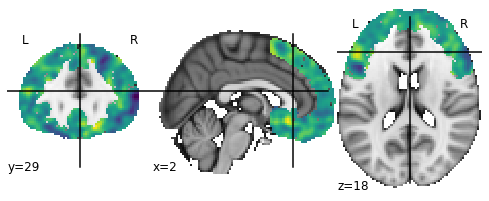

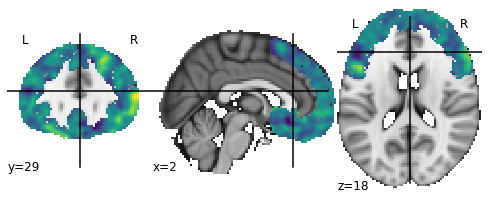

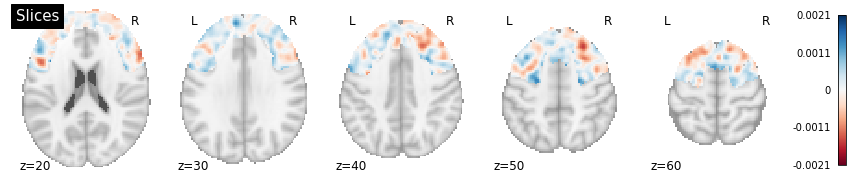

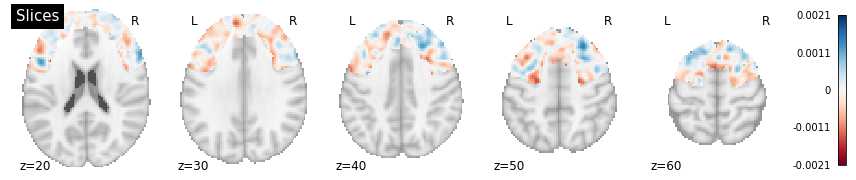

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


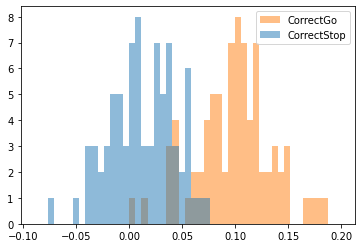

26.0 20.266128342428956 5.733871657571044 46.266128342428956


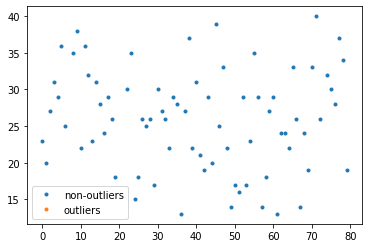

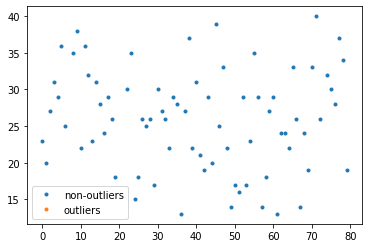

26.0 20.266128342428956 5.733871657571044 46.266128342428956


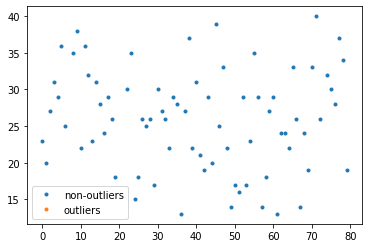

76 , 76


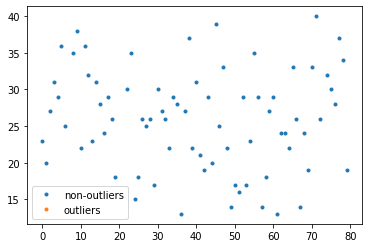

76 , 76


4.458333333333335 1.6898243675770521 2.7685089657562827 6.148157700910387


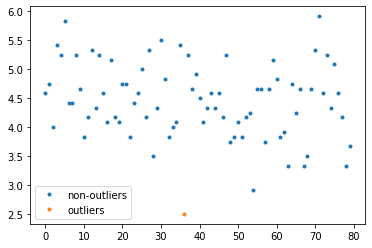

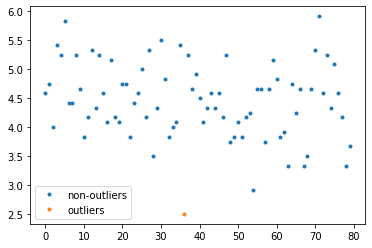

4.458333333333335 1.6898243675770521 2.7685089657562827 6.148157700910387


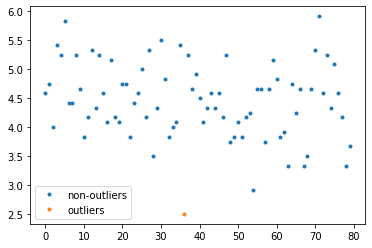

80 , 79
4.5 1.6895886466474699 2.81041135335253 6.18958864664747


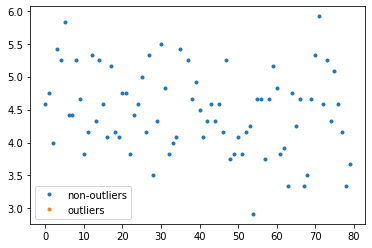

79 , 79


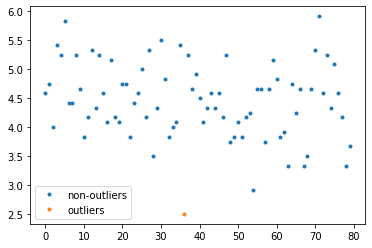

80 , 79


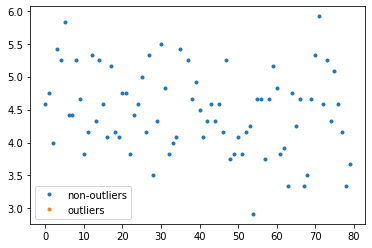

79 , 79


-0.029198517658926098 2.0272800228666514 -2.0564785405255774 1.9980815052077254


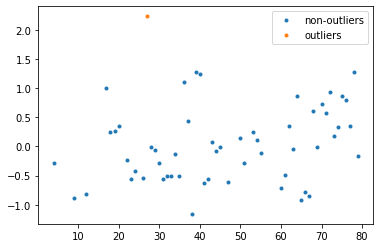

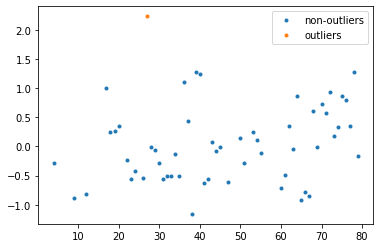

-0.029198517658926098 2.0272800228666514 -2.0564785405255774 1.9980815052077254


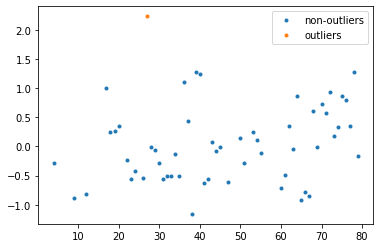

56 , 55
-0.04359384351429142 1.9200402150485443 -1.9636340585628358 1.8764463715342528


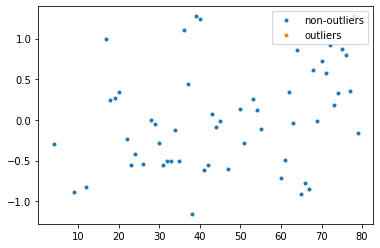

55 , 55


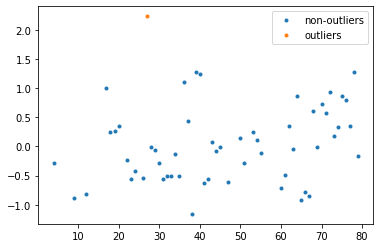

56 , 55


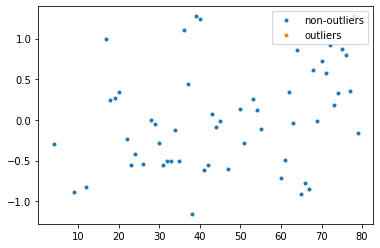

55 , 55


3.7 2.7021504456571925 0.9978495543428076 6.402150445657193


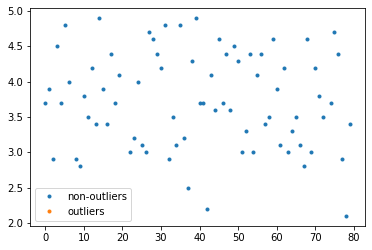

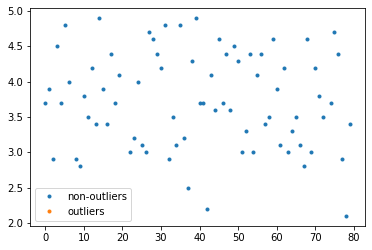

3.7 2.7021504456571925 0.9978495543428076 6.402150445657193


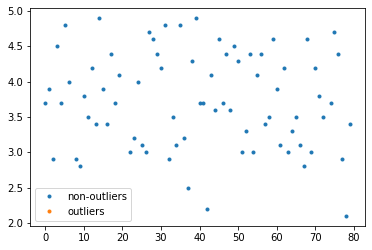

76 , 76


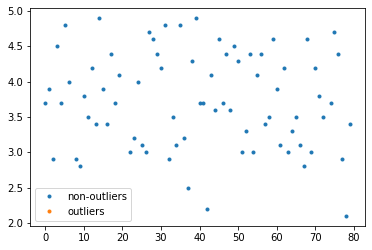

76 , 76


312.9325410023739 182.14878318668306 130.78375781569085 495.081324189057


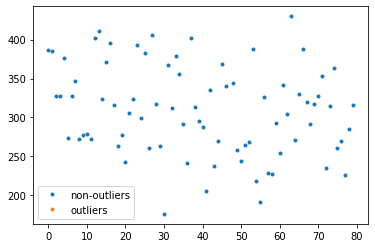

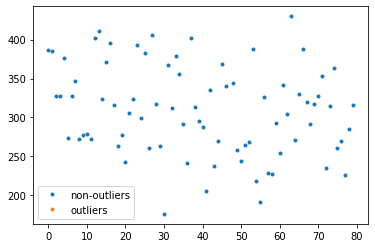

312.9325410023739 182.14878318668306 130.78375781569085 495.081324189057


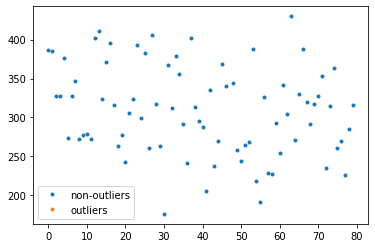

79 , 79


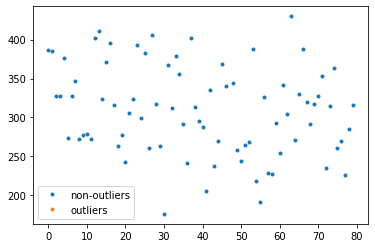

79 , 79


63.0 28.16373945961754 34.83626054038246 91.16373945961755


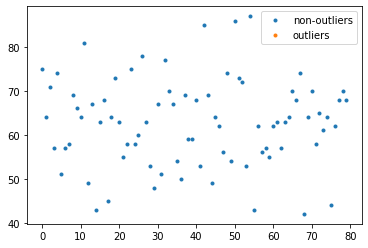

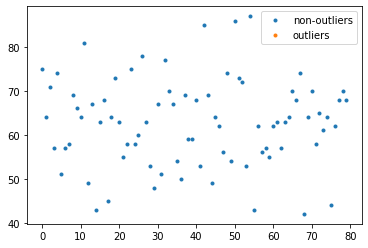

63.0 28.16373945961754 34.83626054038246 91.16373945961755


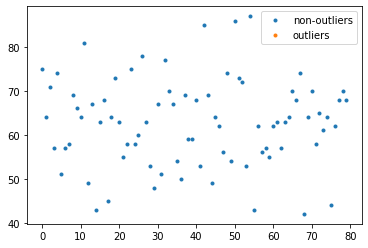

80 , 80


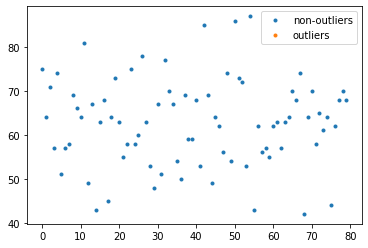

80 , 80


3.30769230769231 1.4723255633388697 1.8353667443534405 4.78001787103118


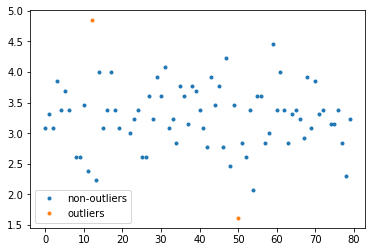

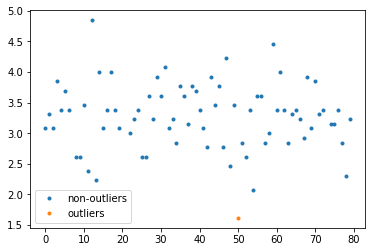

3.30769230769231 1.4723255633388697 1.8353667443534405 4.78001787103118


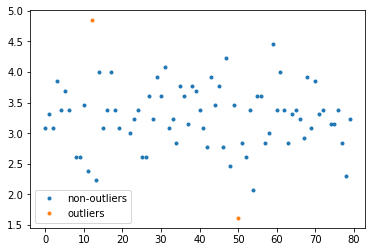

76 , 74
3.30769230769231 1.3852831642481158 1.9224091434441943 4.692975471940426


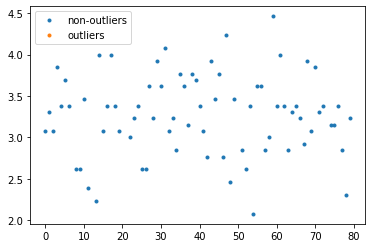

74 , 74


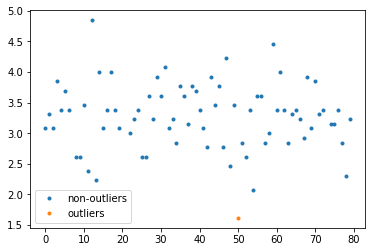

76 , 75


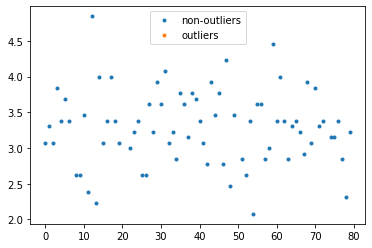

75 , 75


8.0 9.005773331715183 -1.005773331715183 17.005773331715183


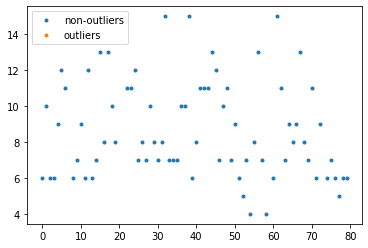

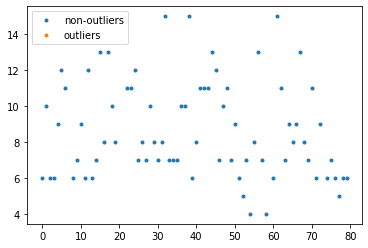

8.0 9.005773331715183 -1.005773331715183 17.005773331715183


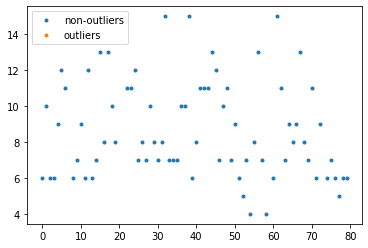

75 , 75


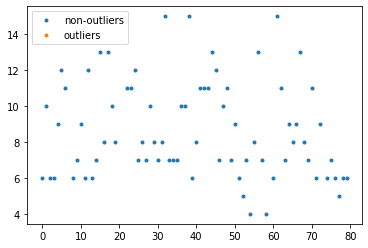

75 , 75


8.0 9.005773331715183 -1.005773331715183 17.005773331715183


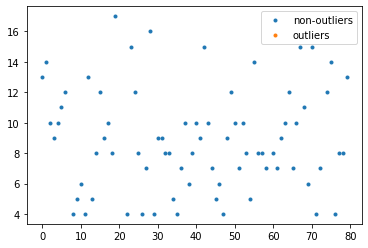

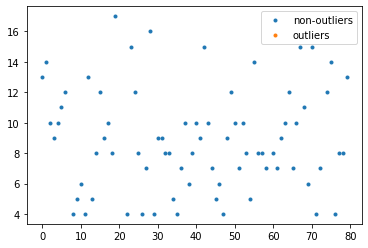

8.0 9.005773331715183 -1.005773331715183 17.005773331715183


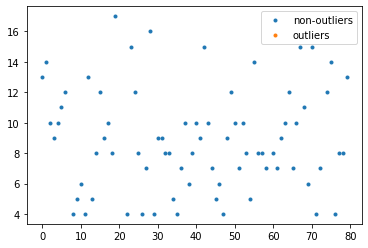

75 , 75


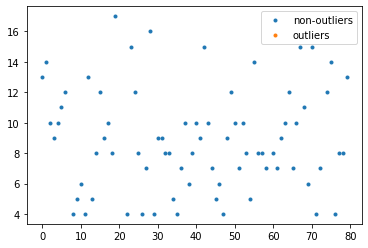

75 , 75


9.0 6.754329998786387 2.245670001213613 15.754329998786387


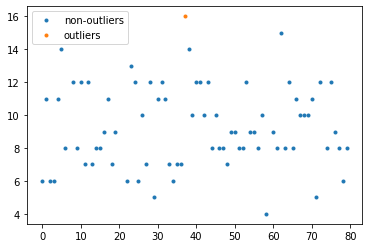

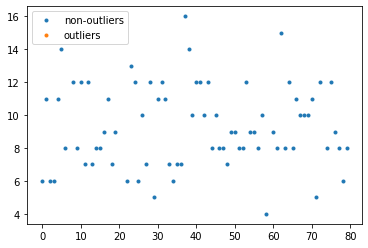

9.0 6.754329998786387 2.245670001213613 15.754329998786387


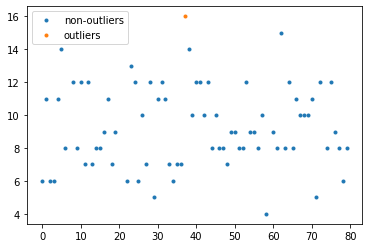

75 , 74
9.0 6.753255425709515 2.246744574290485 15.753255425709515


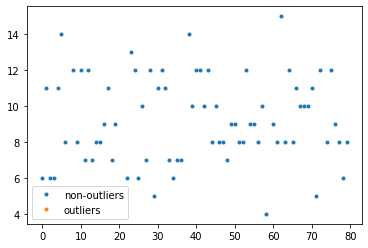

74 , 74


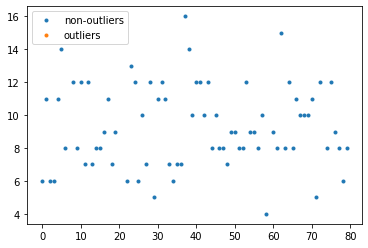

75 , 75


9.0 9.005773331715183 -0.0057733317151829056 18.005773331715183


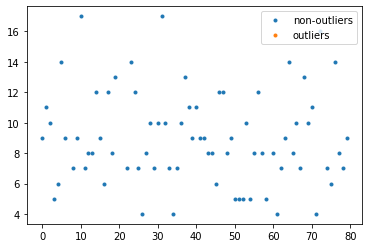

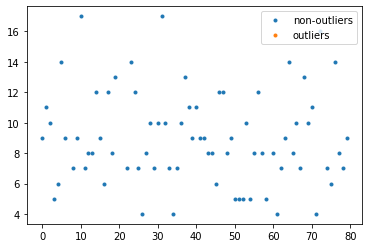

9.0 9.005773331715183 -0.0057733317151829056 18.005773331715183


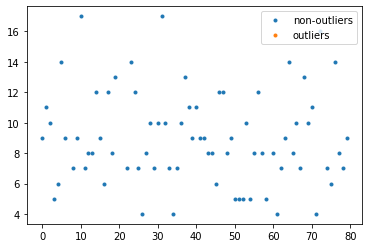

75 , 75


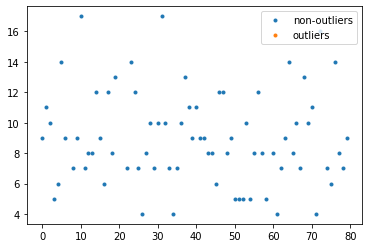

75 , 75


7.0 9.005773331715183 -2.005773331715183 16.005773331715183


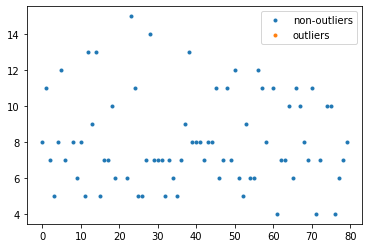

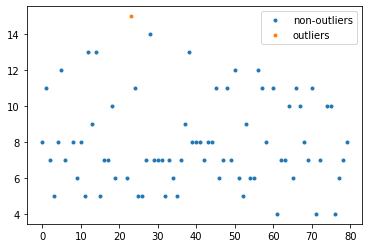

7.0 9.005773331715183 -2.005773331715183 16.005773331715183


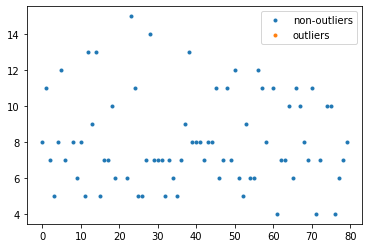

75 , 75


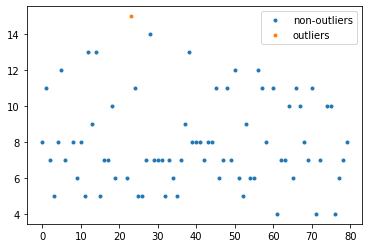

75 , 74


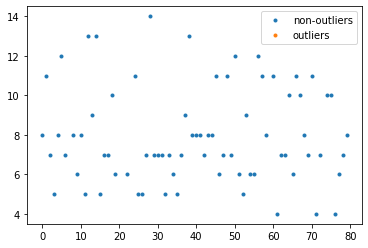

74 , 74


9.0 7.880051665250785 1.119948334749215 16.880051665250786


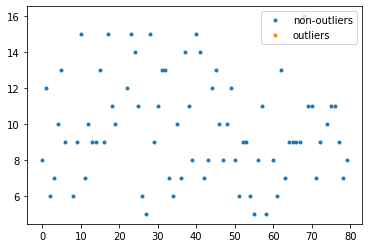

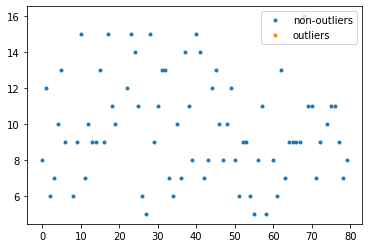

9.0 7.880051665250785 1.119948334749215 16.880051665250786


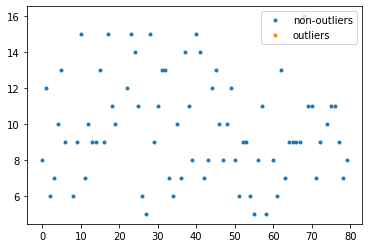

75 , 75


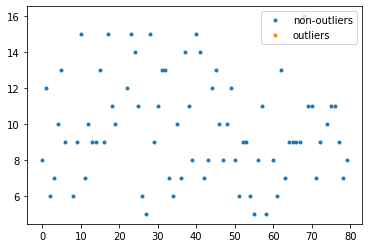

75 , 75


2.9375 2.3939178540674906 0.5435821459325094 5.331417854067491


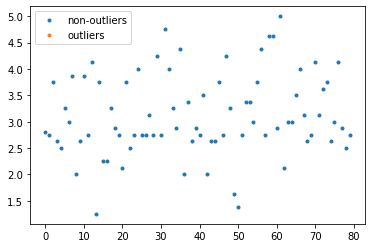

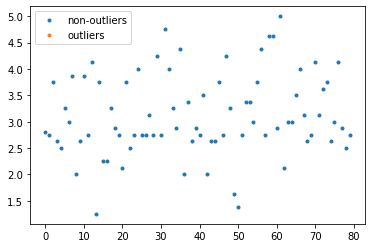

2.9375 2.3939178540674906 0.5435821459325094 5.331417854067491


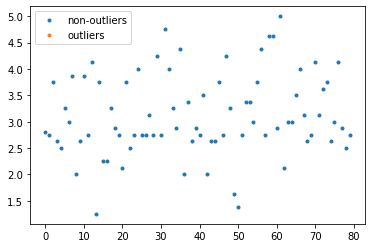

80 , 80


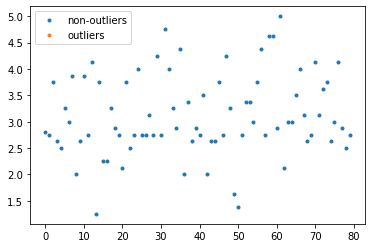

80 , 80


18.0 10.13753187988482 7.86246812011518 28.13753187988482


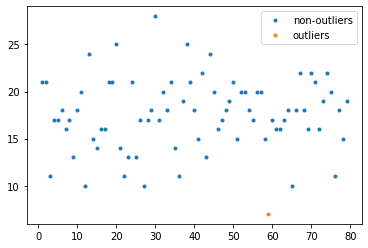

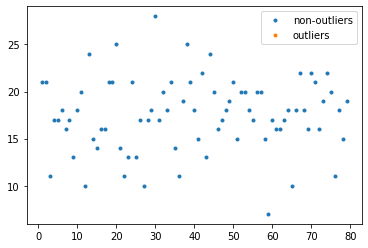

18.0 10.13753187988482 7.86246812011518 28.13753187988482


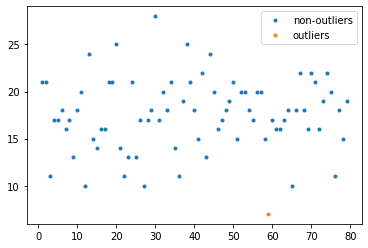

79 , 78
18.0 9.009849835836068 8.990150164163932 27.009849835836068


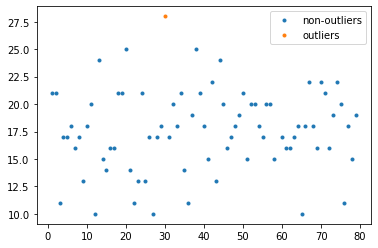

78 , 77
18.0 9.008526516622485 8.991473483377515 27.008526516622485


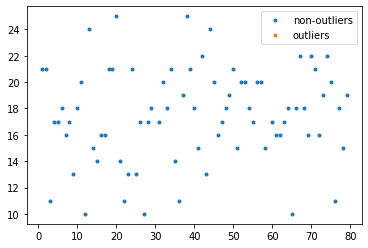

77 , 77


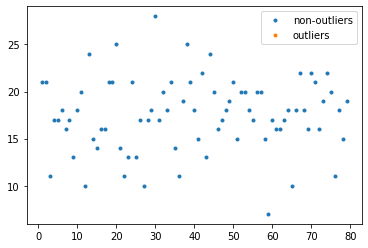

79 , 79


64.0 29.268763328074343 34.73123667192566 93.26876332807434


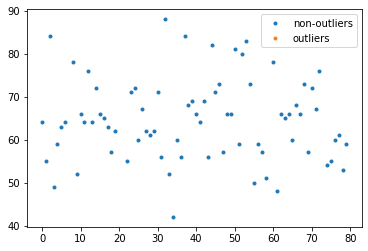

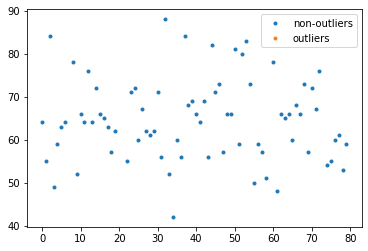

64.0 29.268763328074343 34.73123667192566 93.26876332807434


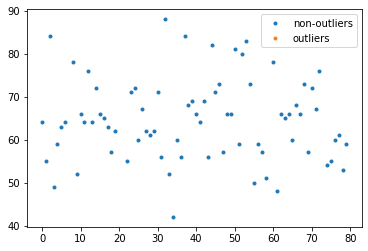

75 , 75


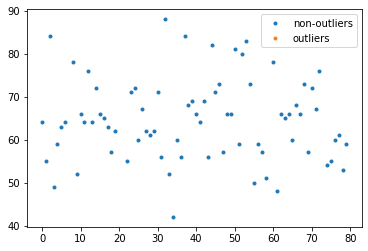

75 , 75


-1.1 2.0638697020107046 -3.1638697020107047 0.9638697020107045


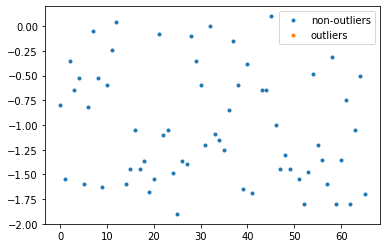

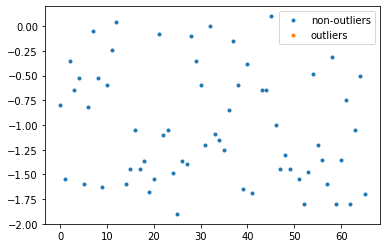

-1.1 2.0638697020107046 -3.1638697020107047 0.9638697020107045


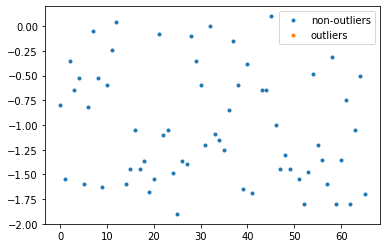

63 , 63


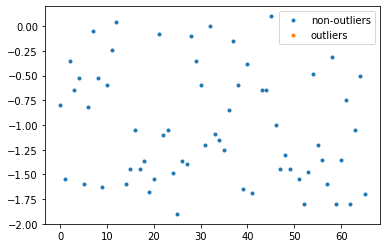

63 , 63


46.5 29.273296494619604 17.226703505380396 75.7732964946196


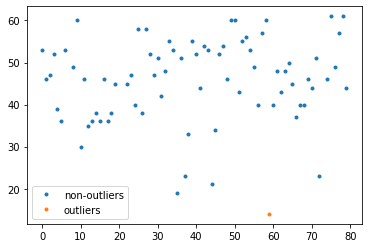

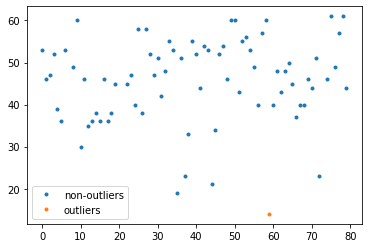

46.5 29.273296494619604 17.226703505380396 75.7732964946196


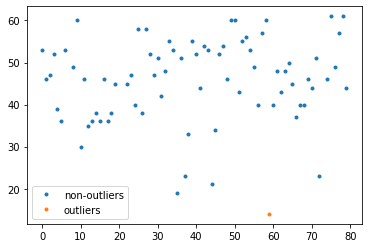

76 , 75
47.0 29.268763328074343 17.731236671925657 76.26876332807434


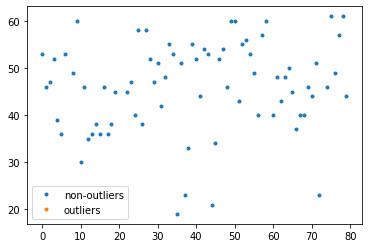

75 , 75


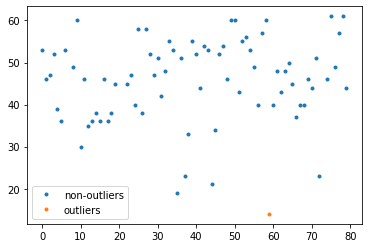

76 , 75


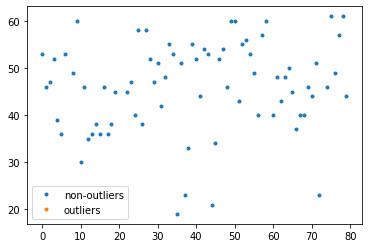

75 , 75


-0.011186181182608996 0.10421994278970498 -0.11540612397231398 0.09303376160709598


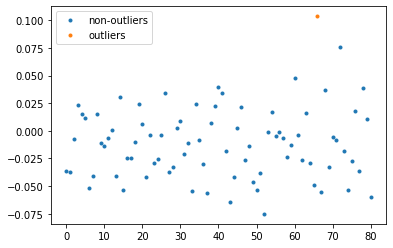

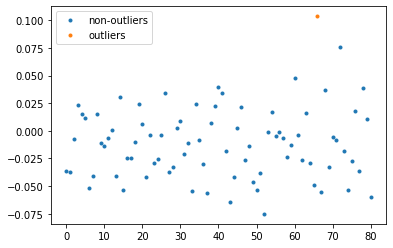

-0.011186181182608996 0.10421994278970498 -0.11540612397231398 0.09303376160709598


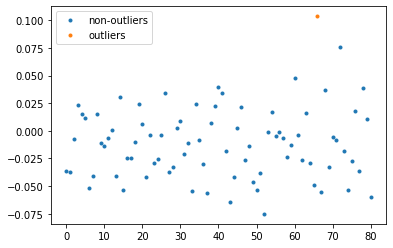

81 , 80
-0.011223935193417186 0.1033053380225738 -0.11452927321599099 0.09208140282915661


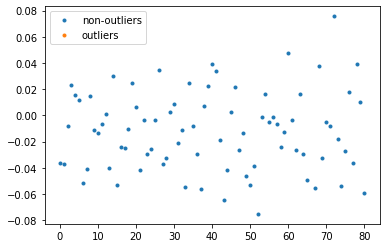

80 , 80


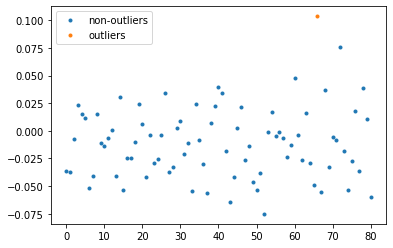

81 , 80


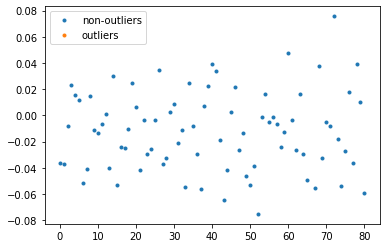

80 , 80


0.10147903283545598 0.09233042523502677 0.00914860760042921 0.19380945807048275


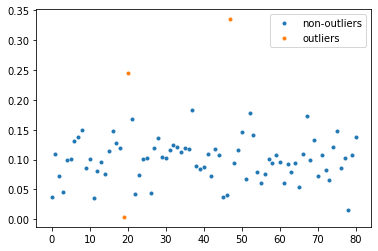

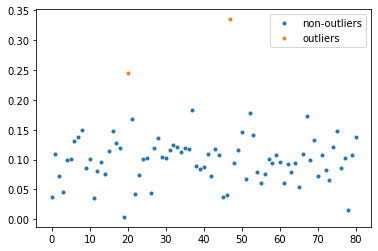

0.10147903283545598 0.09233042523502677 0.00914860760042921 0.19380945807048275


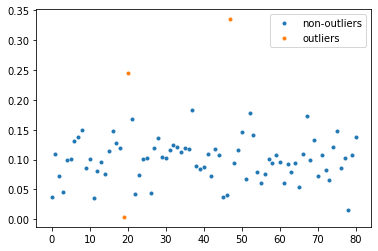

81 , 78
0.10140477243168315 0.09026738920962671 0.011137383222056443 0.19167216164130985


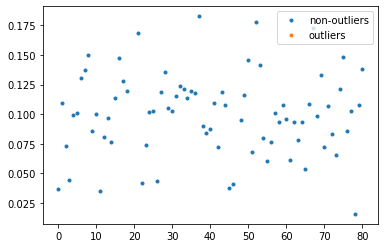

78 , 78


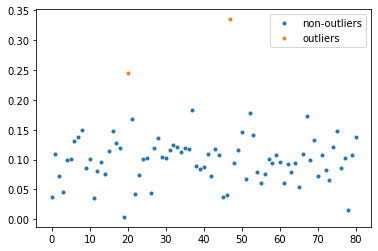

81 , 79


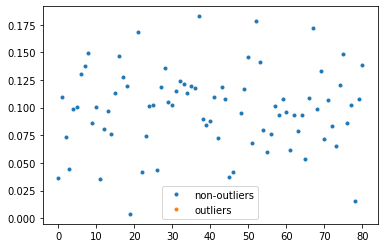

79 , 79


-0.3057692307692349 1.3648581430430025 -1.6706273738122372 1.0590889122737677


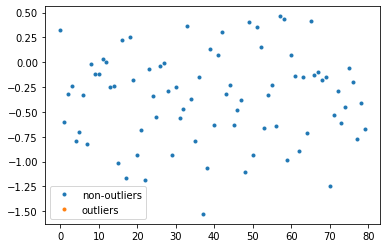

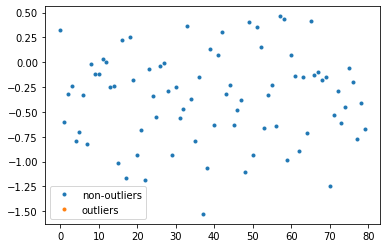

-0.3057692307692349 1.3648581430430025 -1.6706273738122372 1.0590889122737677


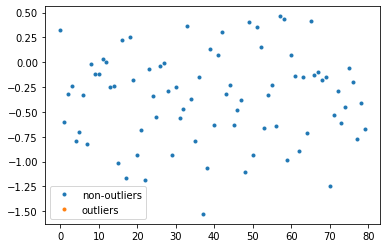

80 , 80


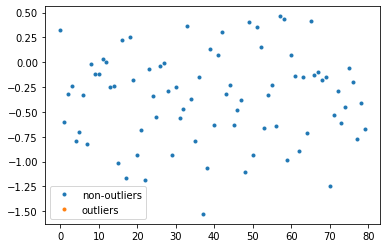

80 , 80


40.15 23.178488718680573 16.971511281319426 63.328488718680575


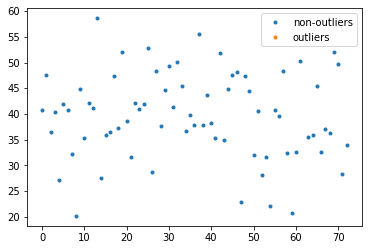

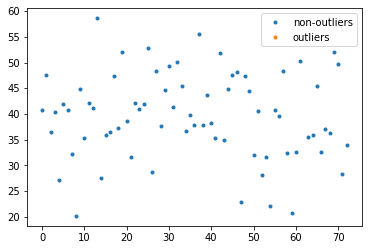

40.15 23.178488718680573 16.971511281319426 63.328488718680575


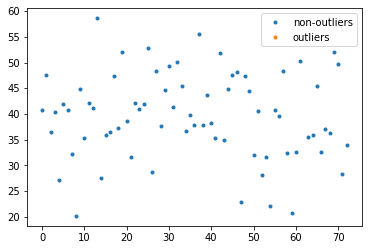

72 , 72


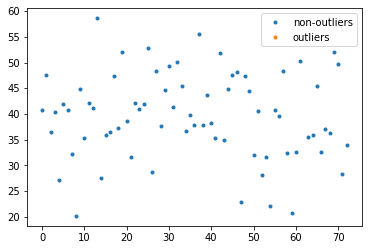

72 , 72


### CS_trials_CS_similarity

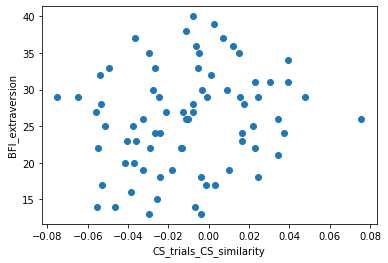

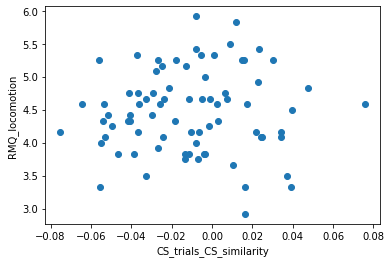

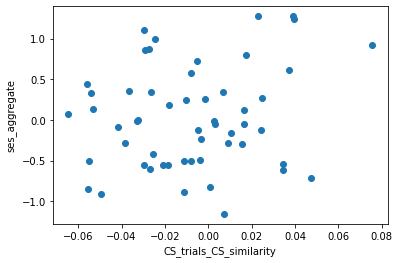

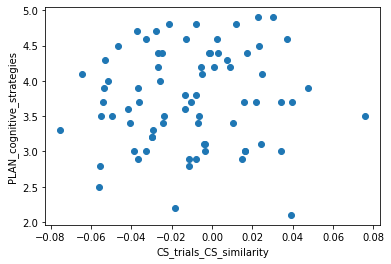

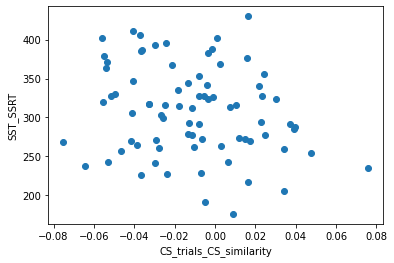

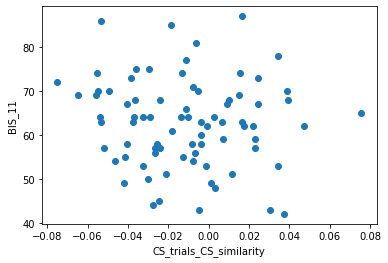

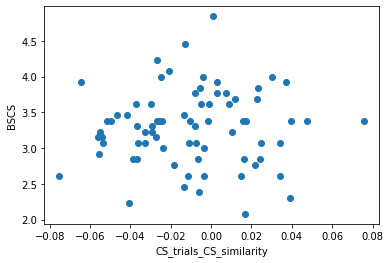

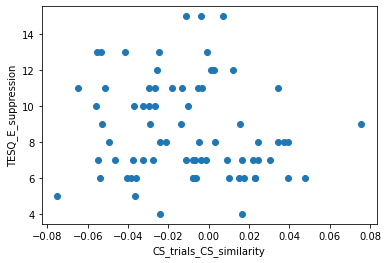

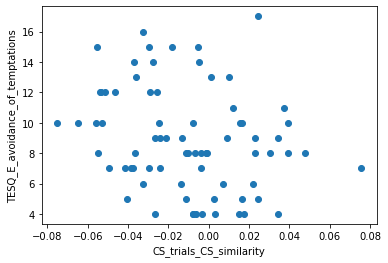

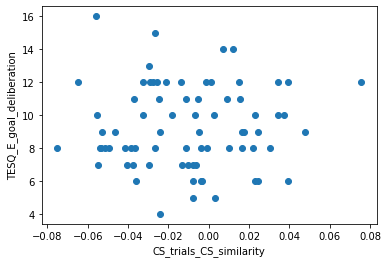

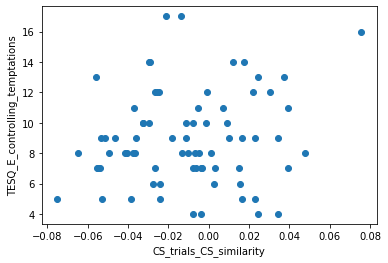

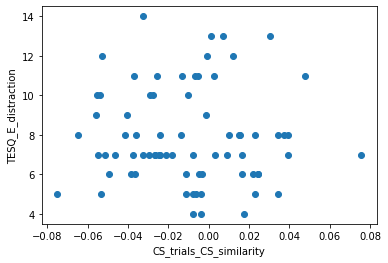

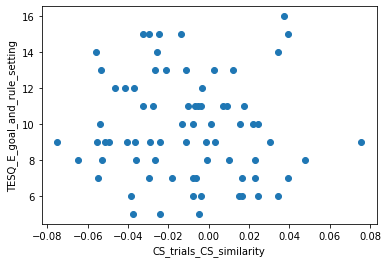

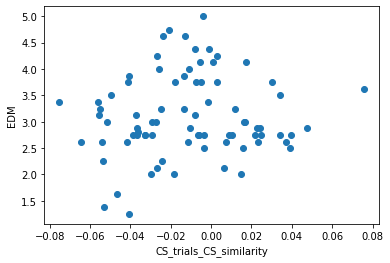

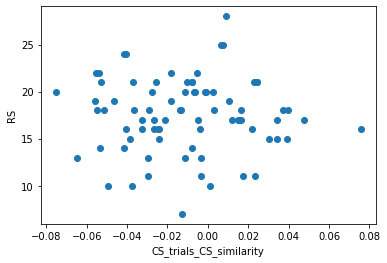

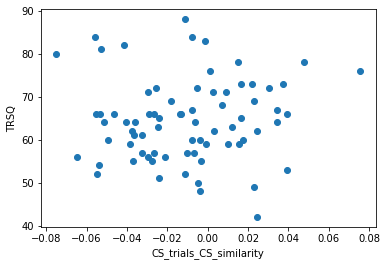

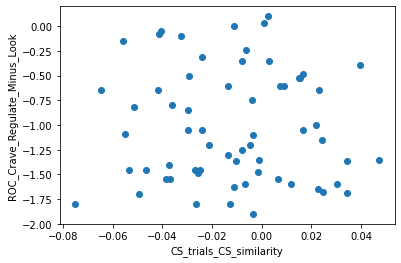

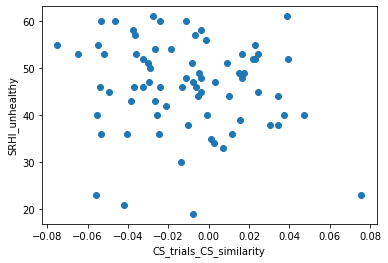

### CG_trials_CG_similarity

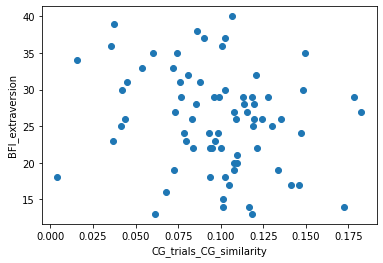

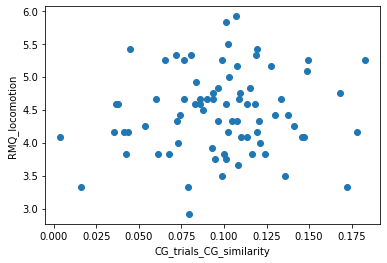

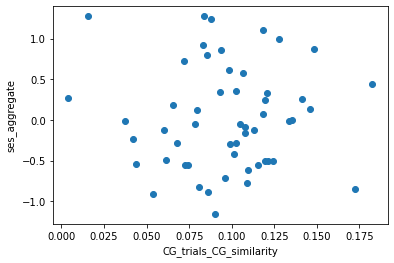

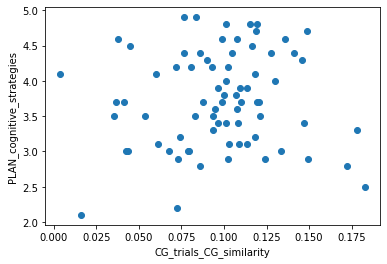

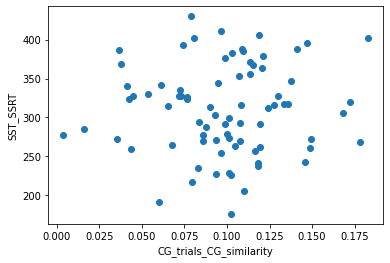

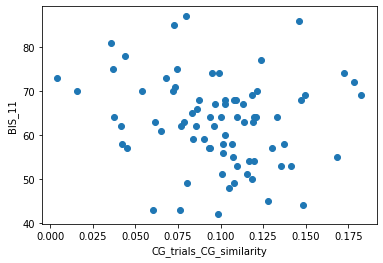

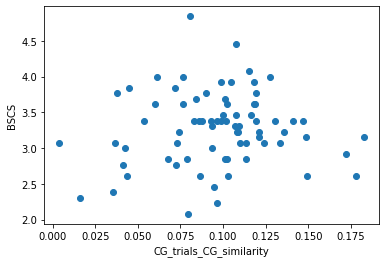

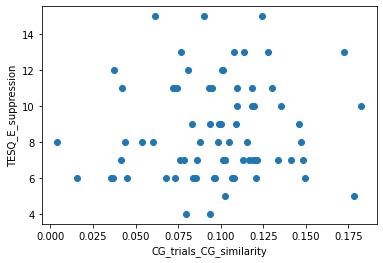

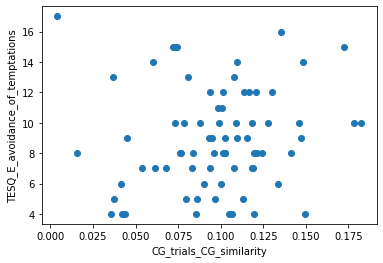

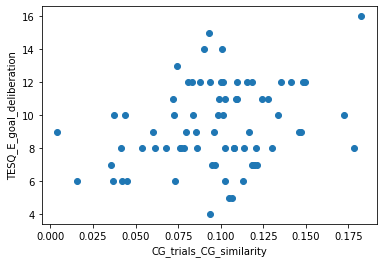

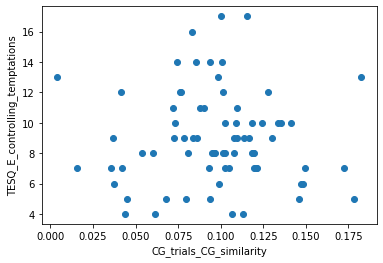

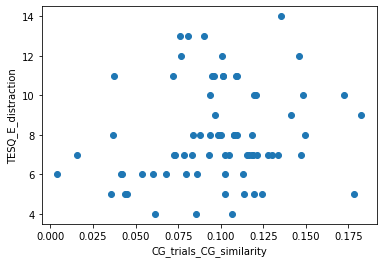

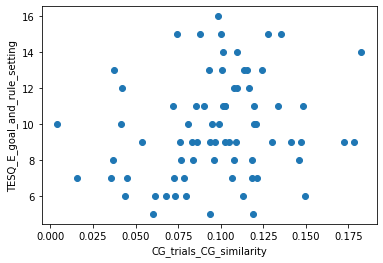

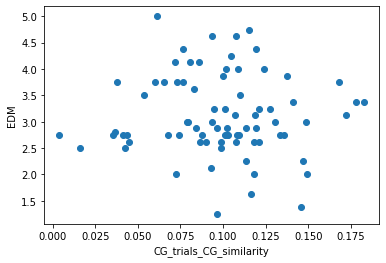

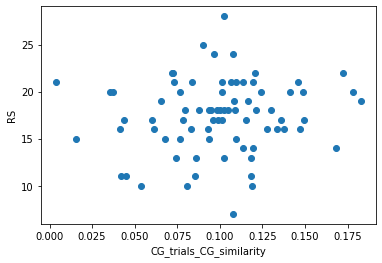

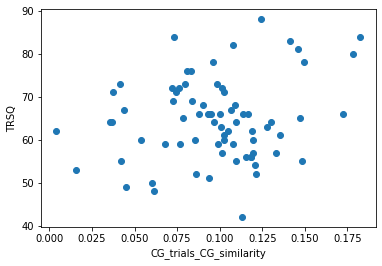

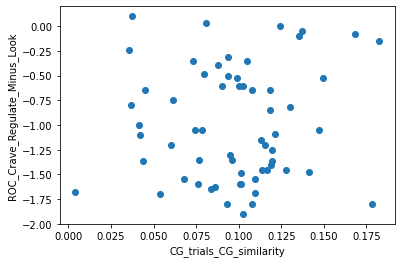

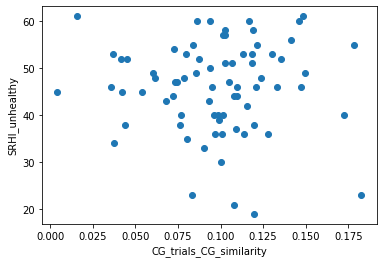

In [59]:
if path.exists(results_filepath) is False:
    apply_loocv_and_save(
        results_filepath = results_filepath,
        brain_data_filepath = brain_data_filepath,
        train_test_markers_filepath = train_test_markers_filepath,
#        subjs_to_use = 60,
        decoderConstructor = decoderConstructor,
        response_transform_func=condition_resp_trans_func
    )
    
    

print(results_filepath)
results=pickle.load(open(results_filepath,'rb'))

print(np.mean(results[0]))

results[3]

correct_stop_ns=results[3]['CorrectStop']
display(Markdown("### correct_stop_ns"))
plotting.plot_img(correct_stop_ns,threshold='auto',bg_img=background_img)

correct_go_ns=results[3]['CorrectGo']
display(Markdown("### correct_go_ns"))
plotting.plot_img(correct_go_ns,threshold='auto',bg_img=background_img)

print(results_filepath,flush=True)

print("plotting signatures")

plot_stat_maps(correct_stop_ns,correct_go_ns)

print("loading data")

bd=get_bd(brain_data_filepath,correct_stop_ns,correct_go_ns,relevant_mask,'CG_similarity','CS_similarity')

create_histogram(bd,similarity1 = 'CG_similarity',similarity2 = 'CS_similarity',condition1 = 'CorrectStop',condition2='CorrectGo')

ind_div_combined = get_ind_div_for_sst(bd,ml_data_folderpath)

ind_div_combined_3sd = remove_selected_outliers_tesq_study(ind_div_combined_3sd,show_plot=True)

for neural_var in ['CS_trials_CS_similarity','CG_trials_CG_similarity']:
    display(Markdown("### " + neural_var))
    for correlate in ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies','SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
                      'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction', 'TESQ_E_goal_and_rule_setting',
                     'EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look','SRHI_unhealthy']:
        visualize_corr(neural_var,correlate,ind_div_combined_3sd)
        

In [60]:
ind_div_combined_3sd.loc[ind_div_combined_3sd.TESQ_E_distraction==0,['subject','TESQ_E_distraction']]

Empty DataFrame
Columns: [subject, TESQ_E_distraction]
Index: []

### whole brain

In [61]:

dataset_name = 'conditions'


In [62]:
brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_84subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_43subs_correct_cond.pkl'

#set vars for the function

#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_40subs_twoclasses_pfcmask_repeat1.pkl"
results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_wholebrain.pkl"
#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_58subs_twoclasses_pfcmask_repeat1.pkl"

def decoderConstructor(*args, **kwargs):
    return(Decoder(scoring='accuracy',verbose=0, *args, **kwargs))


relevant_mask = None

In [63]:
if path.exists(results_filepath) is False:
    apply_loocv_and_save(
        results_filepath = results_filepath,
        brain_data_filepath = brain_data_filepath,
        train_test_markers_filepath = train_test_markers_filepath,
#        subjs_to_use = 60,
        decoderConstructor = decoderConstructor,
        response_transform_func=condition_resp_trans_func
    )

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_conditions_84subs_twoclasses_wholebrain.pkl
0.9382716049382716


### correct_stop_ns

### correct_go_ns

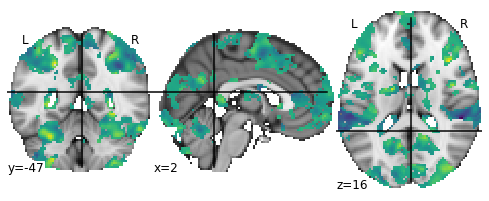

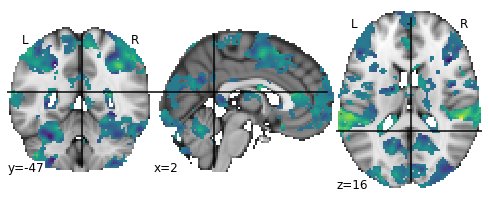

In [64]:

print(results_filepath)
results=pickle.load(open(results_filepath,'rb'))

print(np.mean(results[0]))

results[3]

correct_stop_ns=results[3]['CorrectStop']
display(Markdown("### correct_stop_ns"))
plotting.plot_img(correct_stop_ns,threshold='auto',bg_img=background_img)

correct_go_ns=results[3]['CorrectGo']
display(Markdown("### correct_go_ns"))
plotting.plot_img(correct_go_ns,threshold='auto',bg_img=background_img)

In [65]:
from analyze_results import *

In [66]:
def visualize_corr(neural_var,correlate,data):
    display(HTML(correlate))
    #nan_rows = np.isnan(data[correlate])
    nan_rows = np.isnan(ind_div_combined_3sd[correlate]) | np.isnan(ind_div_combined_3sd[neural_var])
    cor2way_df = data.loc[nan_rows==False,]
    pearson_result = pearsonr(cor2way_df[neural_var],cor2way_df[correlate])
    display(HTML("r=" + format(pearson_result[0],".2f") +"; p-value=" + format(pearson_result[1],".4f")))
    spearman_result = spearmanr(cor2way_df[neural_var],cor2way_df[correlate])
    display(HTML("rho=" + format(spearman_result[0],".2f") +"; p-value=" + format(spearman_result[1],".4f")))
    cplot = pyplot.scatter(cor2way_df[neural_var],cor2way_df[correlate])
    cplot.axes.set_xlabel(neural_var)
    cplot.axes.set_ylabel(correlate)
    pyplot.show()

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_conditions_84subs_twoclasses_wholebrain.pkl
plotting signatures


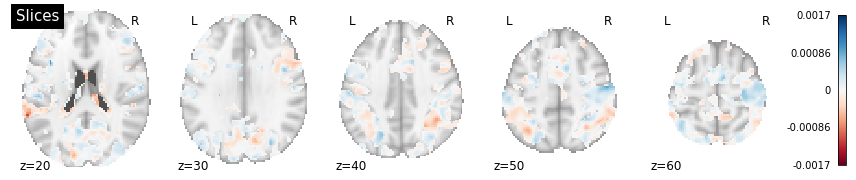

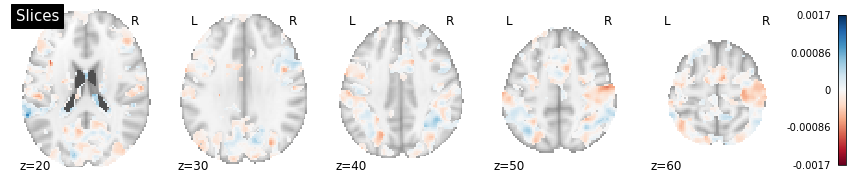

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


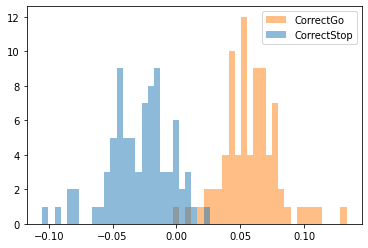

26.0 20.266128342428956 5.733871657571044 46.266128342428956


26.0 20.266128342428956 5.733871657571044 46.266128342428956
76 , 76


76 , 76


4.458333333333335 1.6898243675770521 2.7685089657562827 6.148157700910387


4.458333333333335 1.6898243675770521 2.7685089657562827 6.148157700910387
80 , 79
4.5 1.6895886466474699 2.81041135335253 6.18958864664747
79 , 79


80 , 79
79 , 79


-0.029198517658926098 2.0272800228666514 -2.0564785405255774 1.9980815052077254


-0.029198517658926098 2.0272800228666514 -2.0564785405255774 1.9980815052077254
56 , 55
-0.04359384351429142 1.9200402150485443 -1.9636340585628358 1.8764463715342528
55 , 55


56 , 55
55 , 55


3.7 2.7021504456571925 0.9978495543428076 6.402150445657193


3.7 2.7021504456571925 0.9978495543428076 6.402150445657193
76 , 76


76 , 76


312.9325410023739 182.14878318668306 130.78375781569085 495.081324189057


312.9325410023739 182.14878318668306 130.78375781569085 495.081324189057
79 , 79


79 , 79


63.0 28.16373945961754 34.83626054038246 91.16373945961755


63.0 28.16373945961754 34.83626054038246 91.16373945961755
80 , 80


80 , 80


3.30769230769231 1.4723255633388697 1.8353667443534405 4.78001787103118


3.30769230769231 1.4723255633388697 1.8353667443534405 4.78001787103118
76 , 74
3.30769230769231 1.3852831642481158 1.9224091434441943 4.692975471940426
74 , 74


76 , 75
75 , 75


8.0 9.005773331715183 -1.005773331715183 17.005773331715183


8.0 9.005773331715183 -1.005773331715183 17.005773331715183
75 , 75


75 , 75


8.0 9.005773331715183 -1.005773331715183 17.005773331715183


8.0 9.005773331715183 -1.005773331715183 17.005773331715183
75 , 75


75 , 75


9.0 6.754329998786387 2.245670001213613 15.754329998786387


9.0 6.754329998786387 2.245670001213613 15.754329998786387
75 , 74
9.0 6.753255425709515 2.246744574290485 15.753255425709515
74 , 74


75 , 75


9.0 9.005773331715183 -0.0057733317151829056 18.005773331715183


9.0 9.005773331715183 -0.0057733317151829056 18.005773331715183
75 , 75


75 , 75


7.0 9.005773331715183 -2.005773331715183 16.005773331715183


7.0 9.005773331715183 -2.005773331715183 16.005773331715183
75 , 75


75 , 74
74 , 74


9.0 7.880051665250785 1.119948334749215 16.880051665250786


9.0 7.880051665250785 1.119948334749215 16.880051665250786
75 , 75


75 , 75


2.9375 2.3939178540674906 0.5435821459325094 5.331417854067491


2.9375 2.3939178540674906 0.5435821459325094 5.331417854067491
80 , 80


80 , 80


18.0 10.13753187988482 7.86246812011518 28.13753187988482


18.0 10.13753187988482 7.86246812011518 28.13753187988482
79 , 78
18.0 9.009849835836068 8.990150164163932 27.009849835836068
78 , 77
18.0 9.008526516622485 8.991473483377515 27.008526516622485
77 , 77


79 , 79


64.0 29.268763328074343 34.73123667192566 93.26876332807434


64.0 29.268763328074343 34.73123667192566 93.26876332807434
75 , 75


75 , 75


-1.1 2.0638697020107046 -3.1638697020107047 0.9638697020107045


-1.1 2.0638697020107046 -3.1638697020107047 0.9638697020107045
63 , 63


63 , 63


46.5 29.273296494619604 17.226703505380396 75.7732964946196


46.5 29.273296494619604 17.226703505380396 75.7732964946196
76 , 75
47.0 29.268763328074343 17.731236671925657 76.26876332807434
75 , 75


76 , 75
75 , 75


0.02549156854503989 0.06532678373644665 -0.03983521519140676 0.09081835228148655


0.02549156854503989 0.06532678373644665 -0.03983521519140676 0.09081835228148655
81 , 79
0.025255971884848356 0.06408644529592557 -0.03883047341107721 0.08934241718077393
79 , 79


81 , 80
80 , 80


0.057318036987197396 0.05333712243566871 0.003980914551528686 0.1106551594228661


0.057318036987197396 0.05333712243566871 0.003980914551528686 0.1106551594228661
81 , 78
0.05658694395363846 0.052577317678870215 0.004009626274768245 0.10916426163250867
78 , 77
0.05585585092007953 0.05217044992314116 0.0036854009969383705 0.1080263008432207
77 , 76
0.055593547173937115 0.051539216344139514 0.0040543308297976005 0.10713276351807663
76 , 76


81 , 79
79 , 79


-0.3057692307692349 1.3648581430430025 -1.6706273738122372 1.0590889122737677


-0.3057692307692349 1.3648581430430025 -1.6706273738122372 1.0590889122737677
80 , 80


80 , 80


40.15 23.178488718680573 16.971511281319426 63.328488718680575


40.15 23.178488718680573 16.971511281319426 63.328488718680575
72 , 72


72 , 72


### CS_trials_CS_similarity

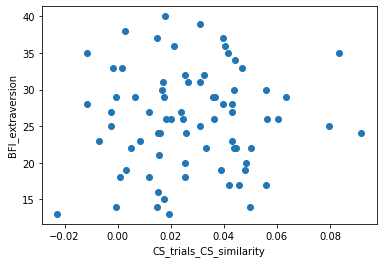

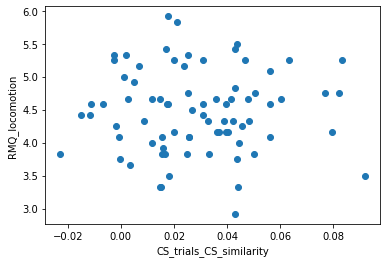

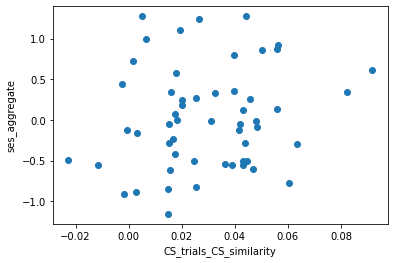

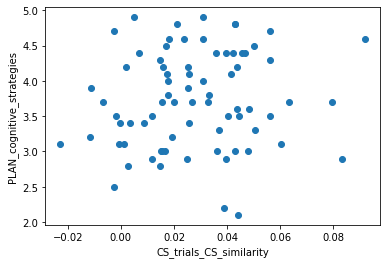

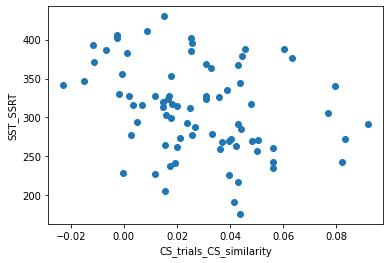

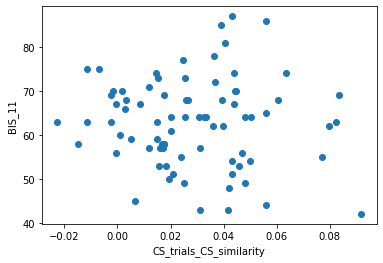

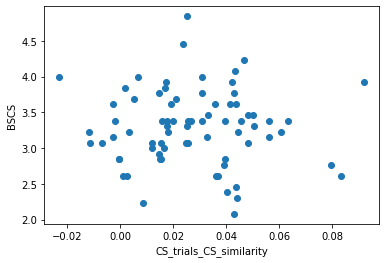

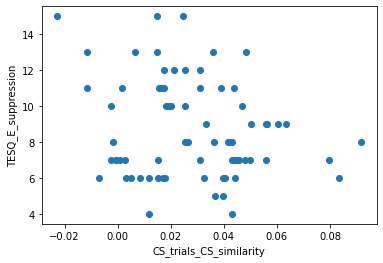

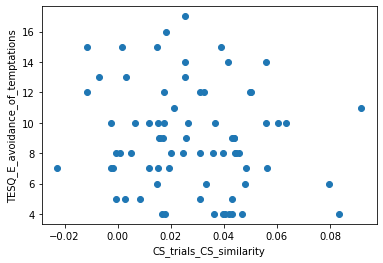

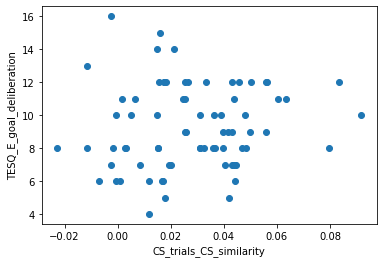

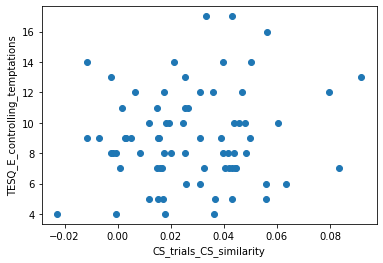

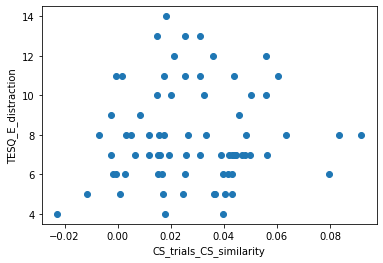

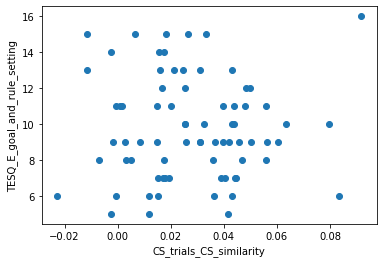

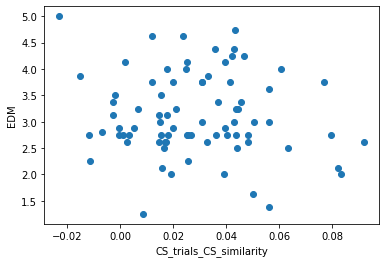

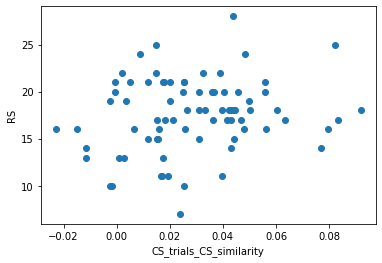

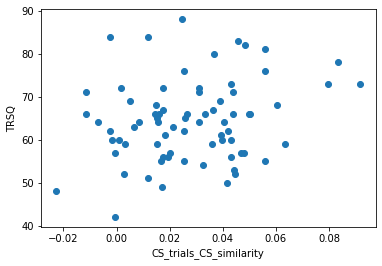

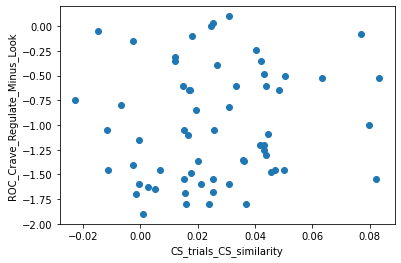

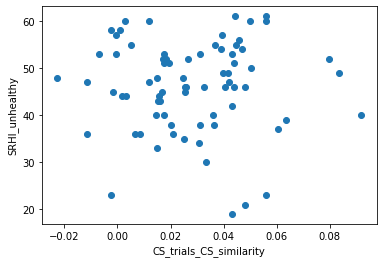

### CG_trials_CG_similarity

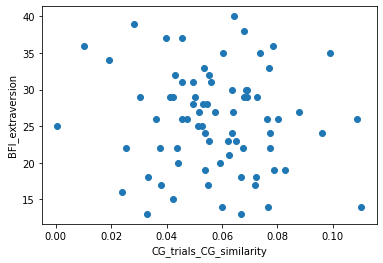

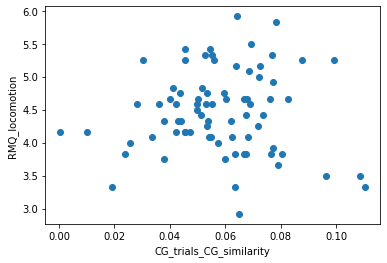

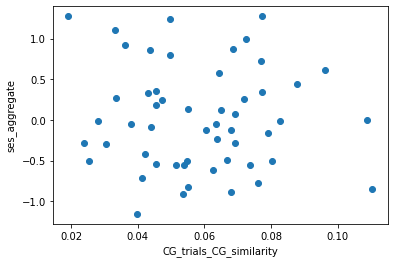

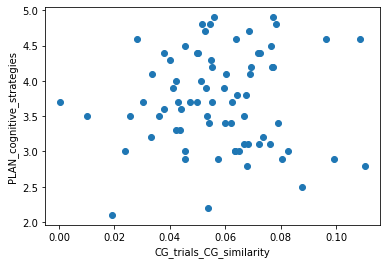

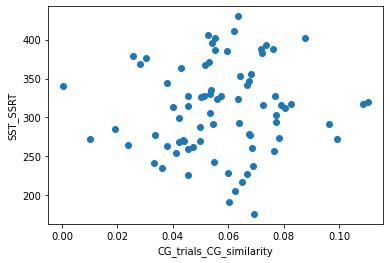

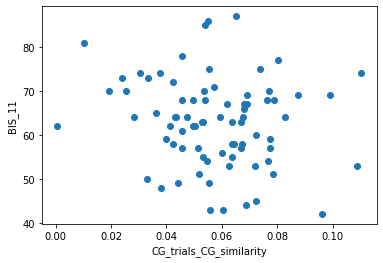

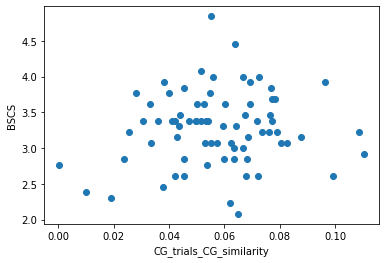

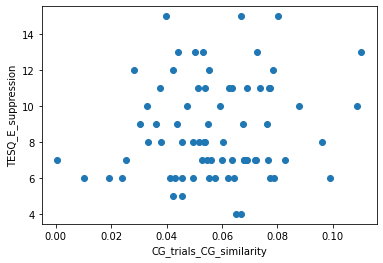

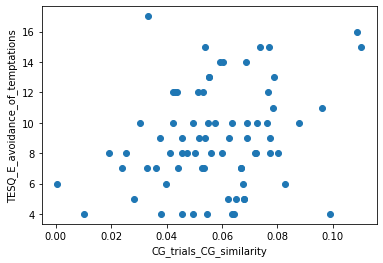

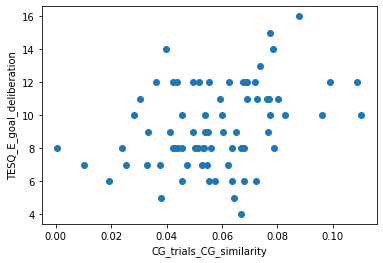

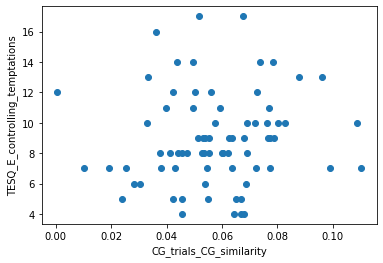

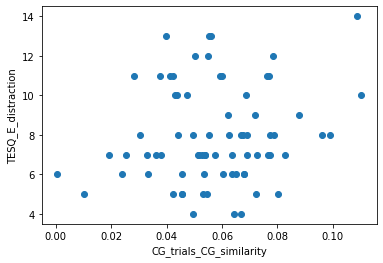

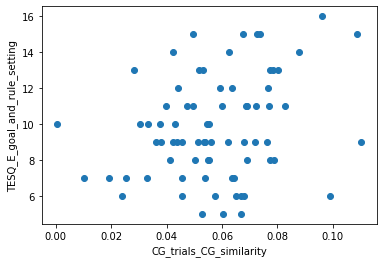

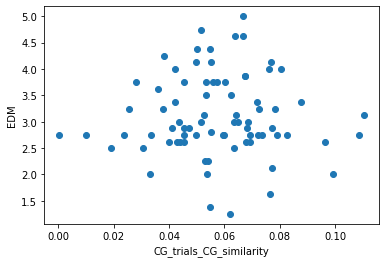

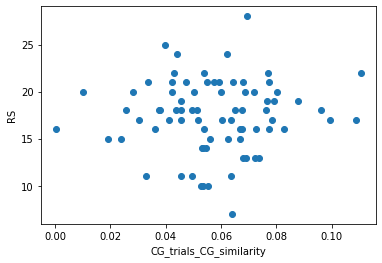

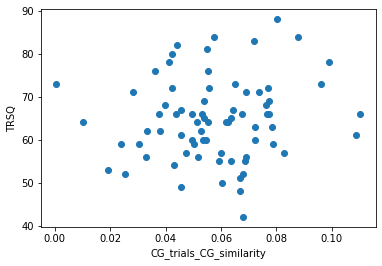

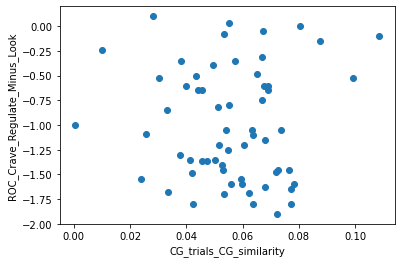

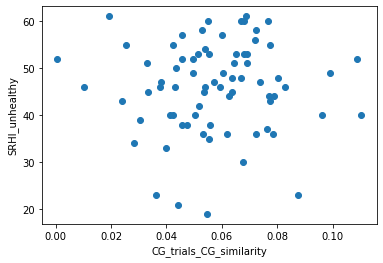

In [67]:
print(results_filepath,flush=True)

print("plotting signatures")

plot_stat_maps(correct_stop_ns,correct_go_ns)

print("loading data")

bd=get_bd(brain_data_filepath,correct_stop_ns,correct_go_ns,relevant_mask,'CG_similarity','CS_similarity')

create_histogram(bd,similarity1 = 'CG_similarity',similarity2 = 'CS_similarity',condition1 = 'CorrectStop',condition2='CorrectGo')

ind_div_combined = get_ind_div_for_sst(bd,ml_data_folderpath)


ind_div_combined_3sd = remove_selected_outliers_tesq_study(ind_div_combined,show_plot=False)

for neural_var in ['CS_trials_CS_similarity','CG_trials_CG_similarity']:
    display(Markdown("### " + neural_var))
    for correlate in ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies','SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
                      'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction', 'TESQ_E_goal_and_rule_setting',
                     'EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look','SRHI_unhealthy']:
        visualize_corr(neural_var,correlate,ind_div_combined_3sd)
        

So, we see this TESQ_E_goal_deliberation pattern and SST_SSRT; not for the PFC but for whole-brain. Where is it?

## Gender breakdown

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_conditions_84subs_twoclasses_wholebrain.pkl
0.9382716049382716


### correct_stop_ns

### correct_go_ns

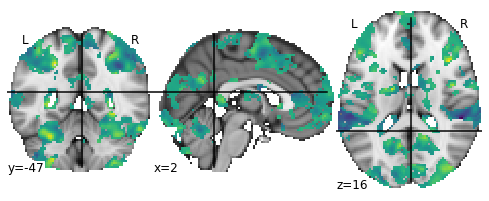

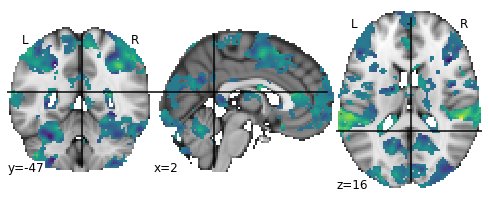

In [68]:

dataset_name = 'conditions'

brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_84subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_43subs_correct_cond.pkl'

#set vars for the function

#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_40subs_twoclasses_pfcmask_repeat1.pkl"
results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_wholebrain.pkl"
#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_58subs_twoclasses_pfcmask_repeat1.pkl"

def decoderConstructor(*args, **kwargs):
    return(Decoder(scoring='accuracy',verbose=0, *args, **kwargs))


relevant_mask = None


if path.exists(results_filepath) is False:
    apply_loocv_and_save(
        results_filepath = results_filepath,
        brain_data_filepath = brain_data_filepath,
        train_test_markers_filepath = train_test_markers_filepath,
#        subjs_to_use = 60,
        decoderConstructor = decoderConstructor,
        response_transform_func=condition_resp_trans_func
    )
    

print(results_filepath)
results=pickle.load(open(results_filepath,'rb'))

print(np.mean(results[0]))

results[3]

correct_stop_ns=results[3]['CorrectStop']
display(Markdown("### correct_stop_ns"))
plotting.plot_img(correct_stop_ns,threshold='auto',bg_img=background_img)

correct_go_ns=results[3]['CorrectGo']
display(Markdown("### correct_go_ns"))
plotting.plot_img(correct_go_ns,threshold='auto',bg_img=background_img)

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_conditions_84subs_twoclasses_wholebrain.pkl
plotting signatures


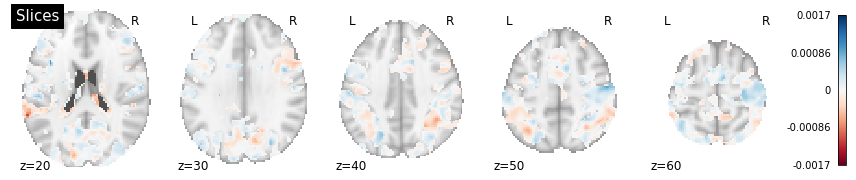

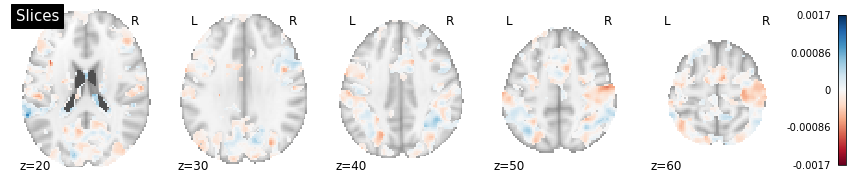

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


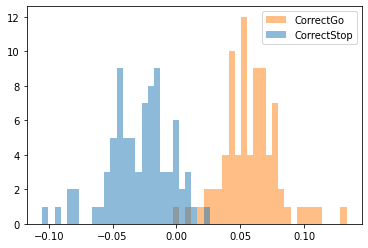

26.0 20.266128342428956 5.733871657571044 46.266128342428956


26.0 20.266128342428956 5.733871657571044 46.266128342428956
76 , 76


76 , 76


4.458333333333335 1.6898243675770521 2.7685089657562827 6.148157700910387


4.458333333333335 1.6898243675770521 2.7685089657562827 6.148157700910387
80 , 79
4.5 1.6895886466474699 2.81041135335253 6.18958864664747
79 , 79


80 , 79
79 , 79


-0.029198517658926098 2.0272800228666514 -2.0564785405255774 1.9980815052077254


-0.029198517658926098 2.0272800228666514 -2.0564785405255774 1.9980815052077254
56 , 55
-0.04359384351429142 1.9200402150485443 -1.9636340585628358 1.8764463715342528
55 , 55


56 , 55
55 , 55


3.7 2.7021504456571925 0.9978495543428076 6.402150445657193


3.7 2.7021504456571925 0.9978495543428076 6.402150445657193
76 , 76


76 , 76


312.9325410023739 182.14878318668306 130.78375781569085 495.081324189057


312.9325410023739 182.14878318668306 130.78375781569085 495.081324189057
79 , 79


79 , 79


63.0 28.16373945961754 34.83626054038246 91.16373945961755


63.0 28.16373945961754 34.83626054038246 91.16373945961755
80 , 80


80 , 80


3.30769230769231 1.4723255633388697 1.8353667443534405 4.78001787103118


3.30769230769231 1.4723255633388697 1.8353667443534405 4.78001787103118
76 , 74
3.30769230769231 1.3852831642481158 1.9224091434441943 4.692975471940426
74 , 74


76 , 75
75 , 75


8.0 9.005773331715183 -1.005773331715183 17.005773331715183


8.0 9.005773331715183 -1.005773331715183 17.005773331715183
75 , 75


75 , 75


8.0 9.005773331715183 -1.005773331715183 17.005773331715183


8.0 9.005773331715183 -1.005773331715183 17.005773331715183
75 , 75


75 , 75


9.0 6.754329998786387 2.245670001213613 15.754329998786387


9.0 6.754329998786387 2.245670001213613 15.754329998786387
75 , 74
9.0 6.753255425709515 2.246744574290485 15.753255425709515
74 , 74


75 , 75


9.0 9.005773331715183 -0.0057733317151829056 18.005773331715183


9.0 9.005773331715183 -0.0057733317151829056 18.005773331715183
75 , 75


75 , 75


7.0 9.005773331715183 -2.005773331715183 16.005773331715183


7.0 9.005773331715183 -2.005773331715183 16.005773331715183
75 , 75


75 , 74
74 , 74


9.0 7.880051665250785 1.119948334749215 16.880051665250786


9.0 7.880051665250785 1.119948334749215 16.880051665250786
75 , 75


75 , 75


2.9375 2.3939178540674906 0.5435821459325094 5.331417854067491


2.9375 2.3939178540674906 0.5435821459325094 5.331417854067491
80 , 80


80 , 80


18.0 10.13753187988482 7.86246812011518 28.13753187988482


18.0 10.13753187988482 7.86246812011518 28.13753187988482
79 , 78
18.0 9.009849835836068 8.990150164163932 27.009849835836068
78 , 77
18.0 9.008526516622485 8.991473483377515 27.008526516622485
77 , 77


79 , 79


64.0 29.268763328074343 34.73123667192566 93.26876332807434


64.0 29.268763328074343 34.73123667192566 93.26876332807434
75 , 75


75 , 75


-1.1 2.0638697020107046 -3.1638697020107047 0.9638697020107045


-1.1 2.0638697020107046 -3.1638697020107047 0.9638697020107045
63 , 63


63 , 63


46.5 29.273296494619604 17.226703505380396 75.7732964946196


46.5 29.273296494619604 17.226703505380396 75.7732964946196
76 , 75
47.0 29.268763328074343 17.731236671925657 76.26876332807434
75 , 75


76 , 75
75 , 75


0.02549156854503989 0.06532678373644665 -0.03983521519140676 0.09081835228148655


0.02549156854503989 0.06532678373644665 -0.03983521519140676 0.09081835228148655
81 , 79
0.025255971884848356 0.06408644529592557 -0.03883047341107721 0.08934241718077393
79 , 79


81 , 80
80 , 80


0.057318036987197396 0.05333712243566871 0.003980914551528686 0.1106551594228661


0.057318036987197396 0.05333712243566871 0.003980914551528686 0.1106551594228661
81 , 78
0.05658694395363846 0.052577317678870215 0.004009626274768245 0.10916426163250867
78 , 77
0.05585585092007953 0.05217044992314116 0.0036854009969383705 0.1080263008432207
77 , 76
0.055593547173937115 0.051539216344139514 0.0040543308297976005 0.10713276351807663
76 , 76


81 , 79
79 , 79


-0.3057692307692349 1.3648581430430025 -1.6706273738122372 1.0590889122737677


-0.3057692307692349 1.3648581430430025 -1.6706273738122372 1.0590889122737677
80 , 80


80 , 80


40.15 23.178488718680573 16.971511281319426 63.328488718680575


40.15 23.178488718680573 16.971511281319426 63.328488718680575
72 , 72


72 , 72


In [69]:
print(results_filepath,flush=True)

print("plotting signatures")

plot_stat_maps(correct_stop_ns,correct_go_ns)

print("loading data")

bd=get_bd(brain_data_filepath,correct_stop_ns,correct_go_ns,relevant_mask,'CG_similarity','CS_similarity')

create_histogram(bd,similarity1 = 'CG_similarity',similarity2 = 'CS_similarity',condition1 = 'CorrectStop',condition2='CorrectGo')

ind_div_combined = get_ind_div_for_sst(bd,ml_data_folderpath)


ind_div_combined_3sd = remove_selected_outliers_tesq_study(ind_div_combined,show_plot=False)


In [70]:
ind_div_combined.birthsex_factor

0     Female
1     Female
2       Male
3       Male
4       Male
       ...  
76       NaN
77       NaN
78       NaN
79       NaN
80       NaN
Name: birthsex_factor, Length: 81, dtype: object

### Male

#### CS_trials_CS_similarity

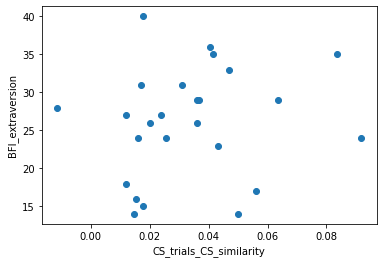

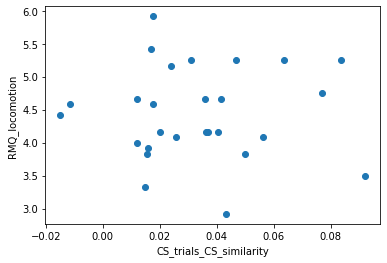

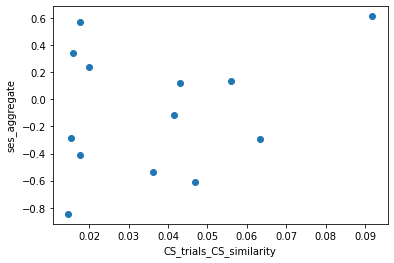

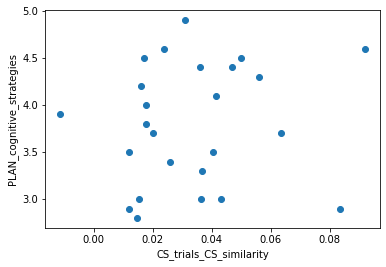

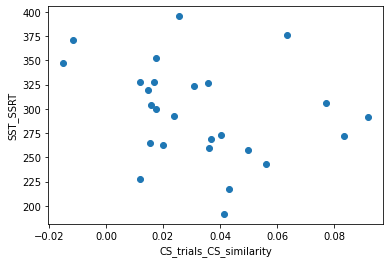

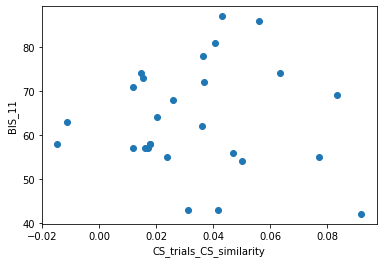

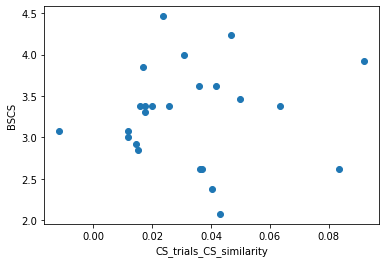

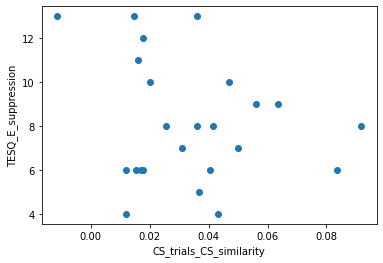

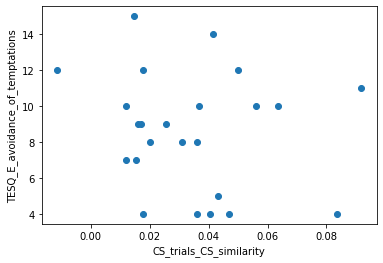

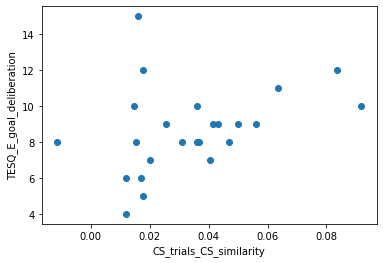

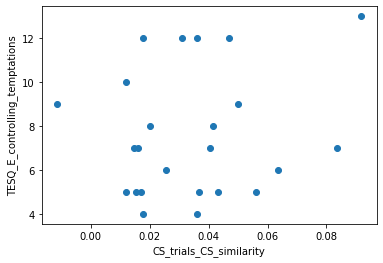

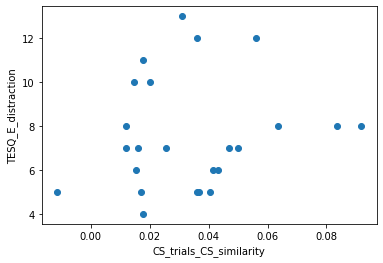

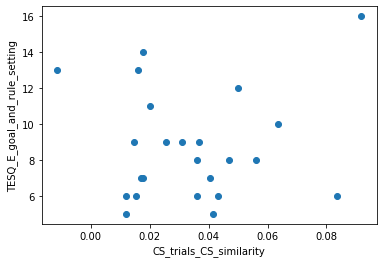

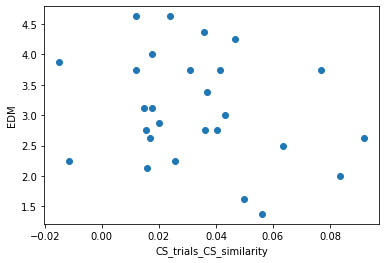

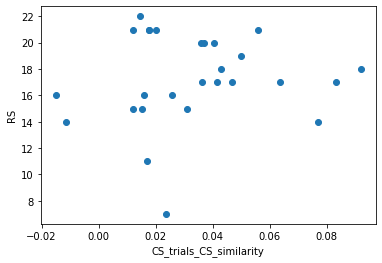

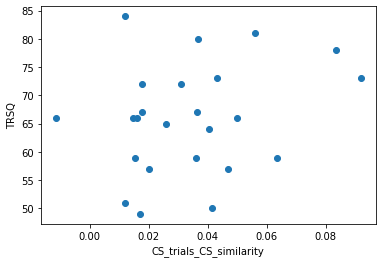

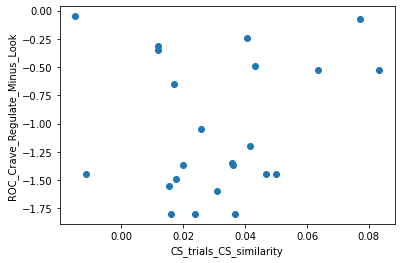

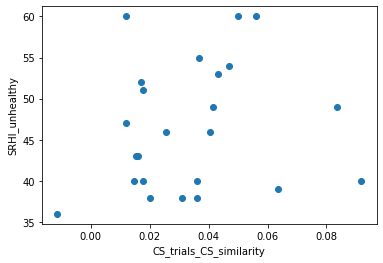

#### CG_trials_CG_similarity

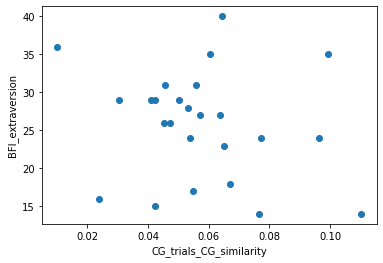

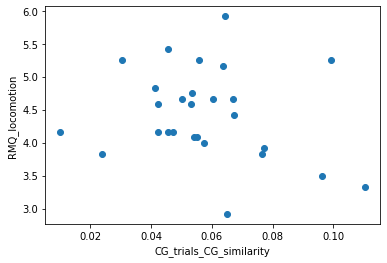

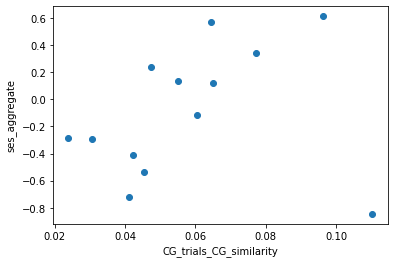

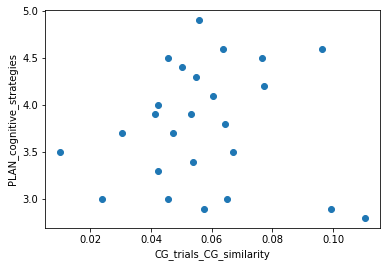

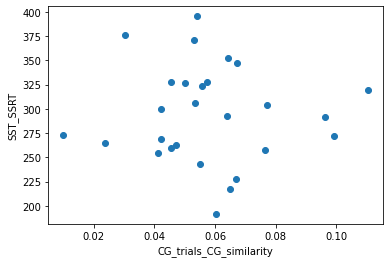

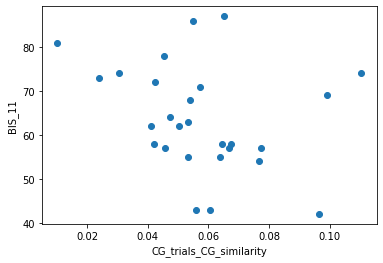

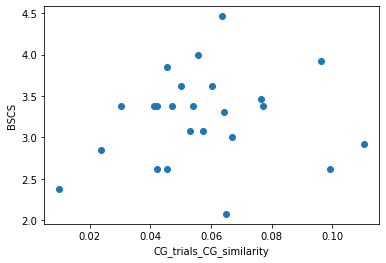

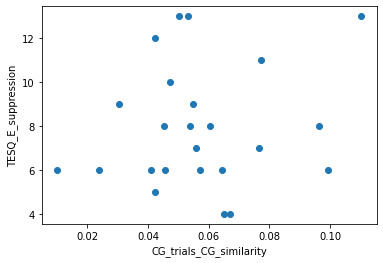

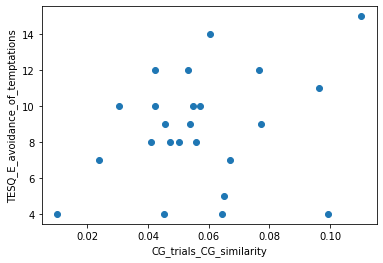

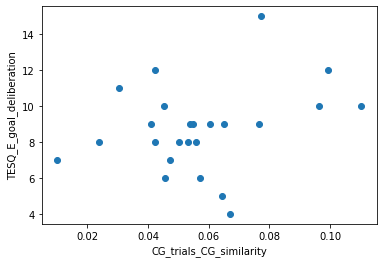

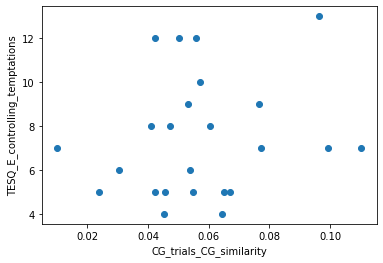

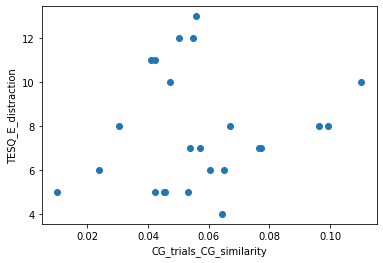

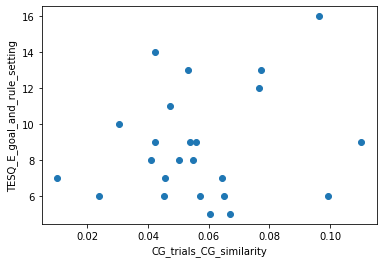

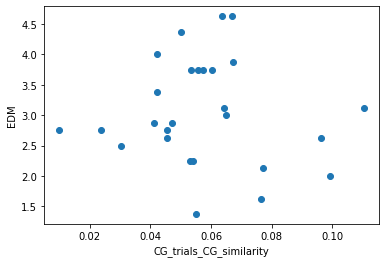

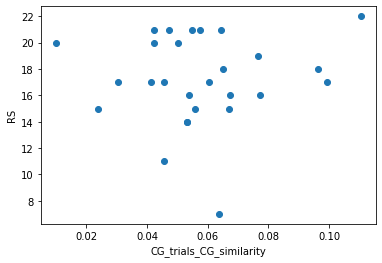

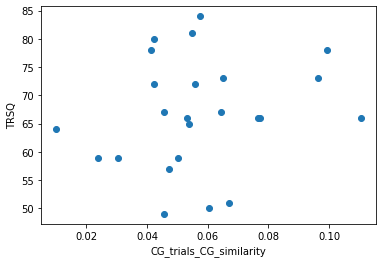

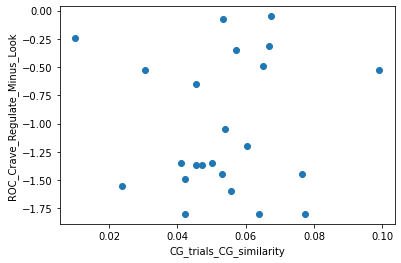

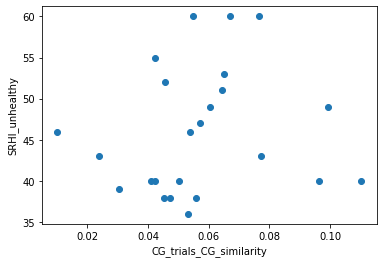

### Female

#### CS_trials_CS_similarity

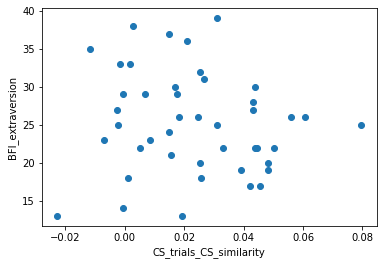

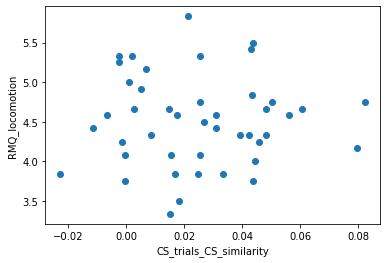

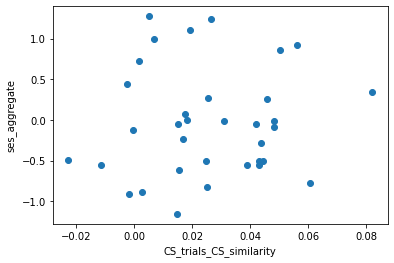

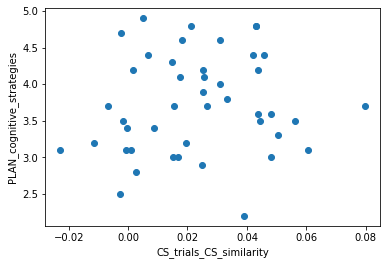

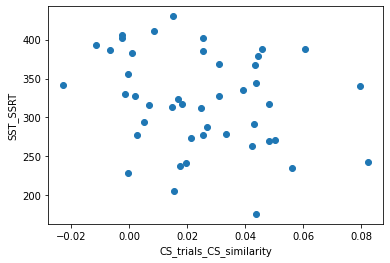

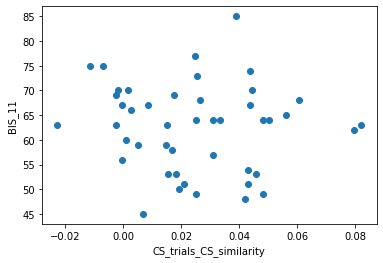

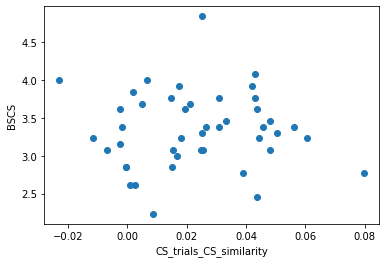

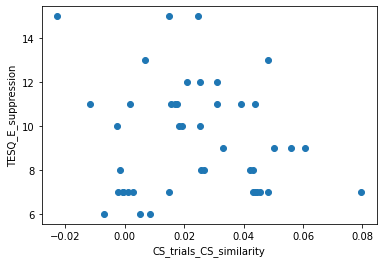

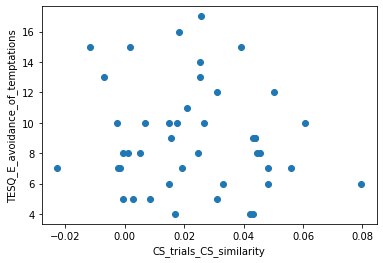

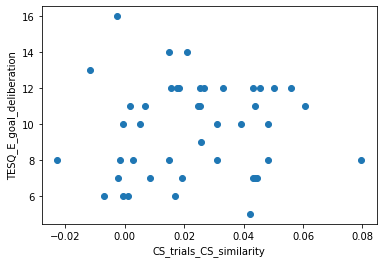

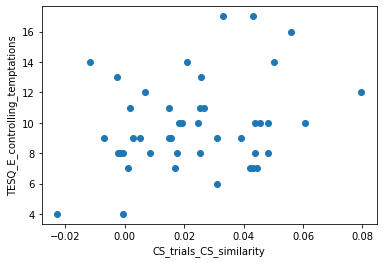

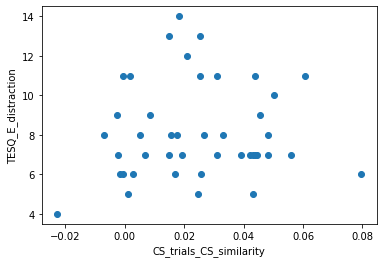

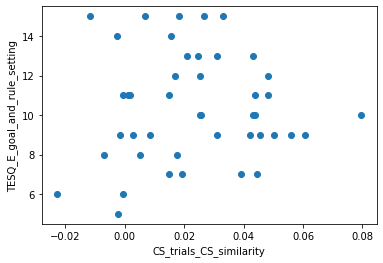

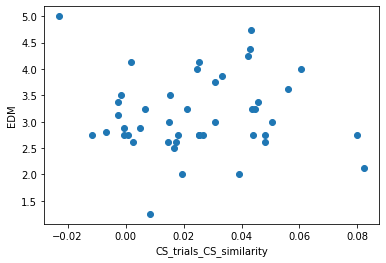

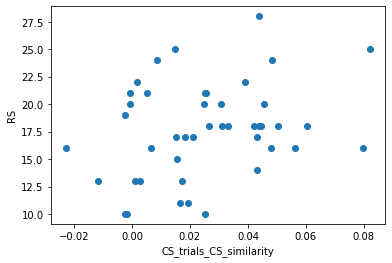

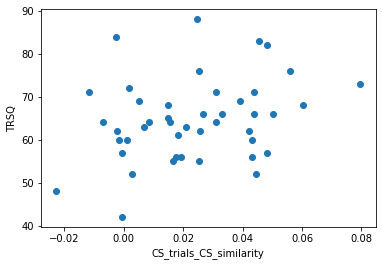

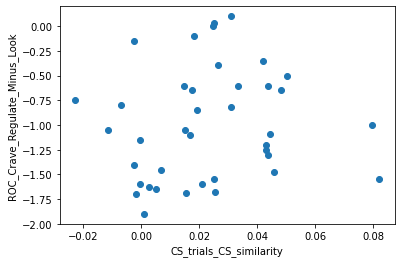

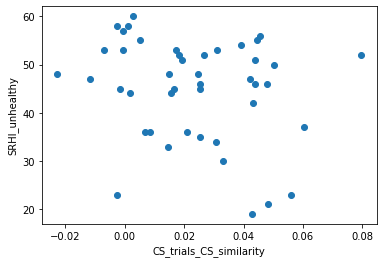

#### CG_trials_CG_similarity

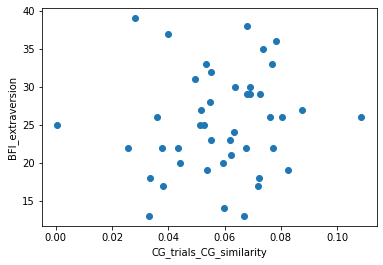

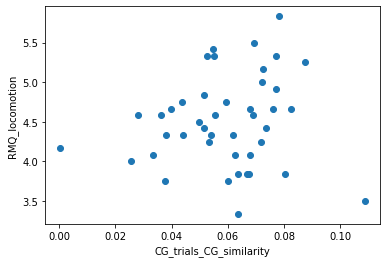

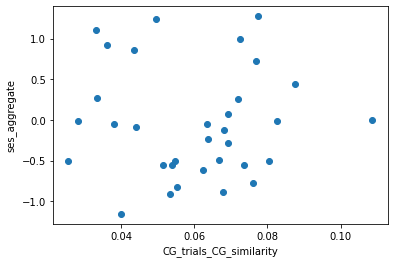

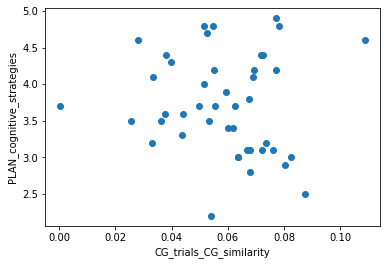

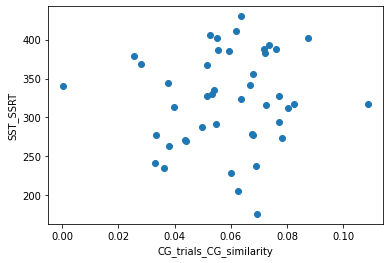

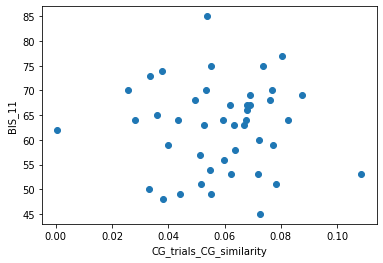

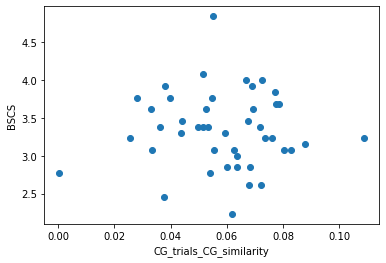

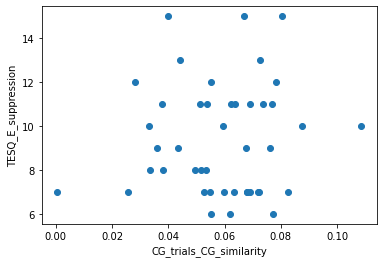

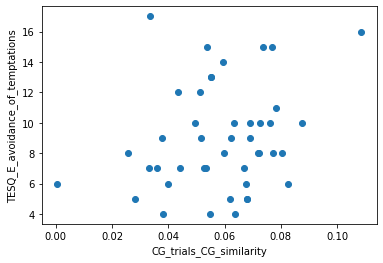

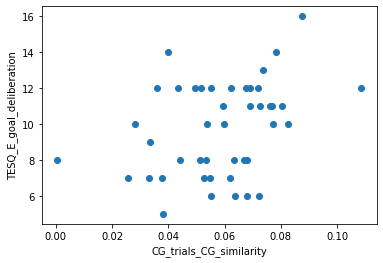

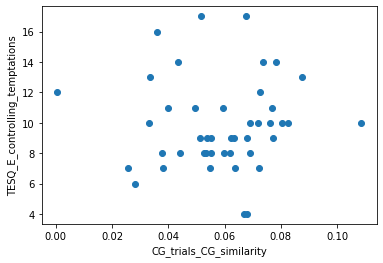

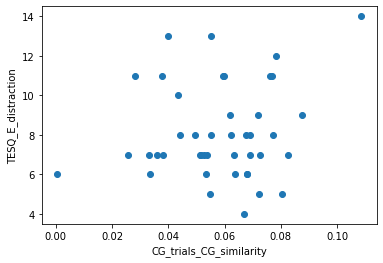

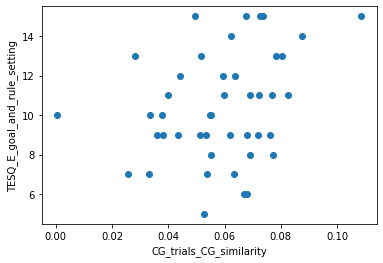

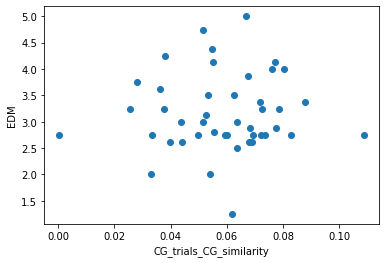

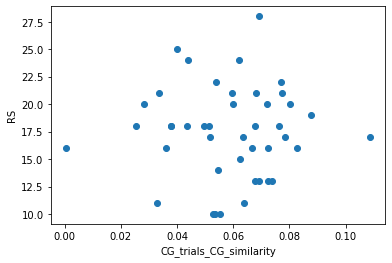

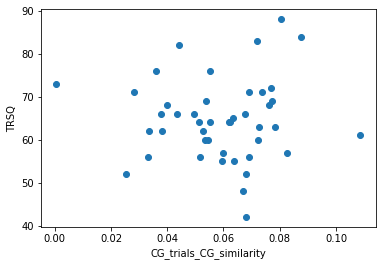

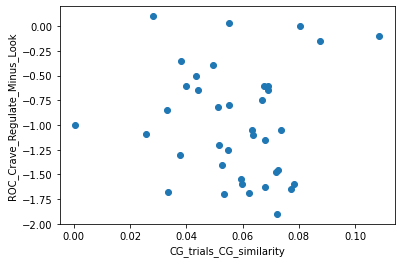

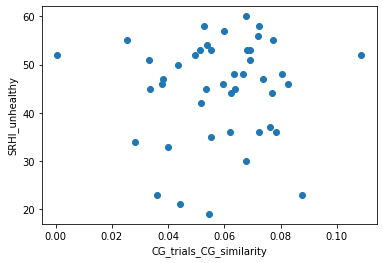

In [71]:

for bs_f in ['Male','Female']:
    display(Markdown("### " + bs_f))
    for neural_var in ['CS_trials_CS_similarity','CG_trials_CG_similarity']:
        display(Markdown("#### " + neural_var))
        for correlate in ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies','SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
                          'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction', 'TESQ_E_goal_and_rule_setting',
                         'EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look','SRHI_unhealthy']:
            visualize_corr(neural_var,correlate,ind_div_combined_3sd.loc[ind_div_combined_3sd.birthsex_factor==bs_f])


Nothing really sticks out there. But our sample sizes are getting small so it's difficult to say.

#### CS_trials_CS_similarity

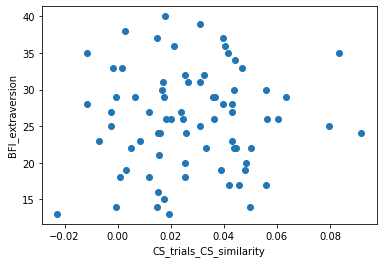

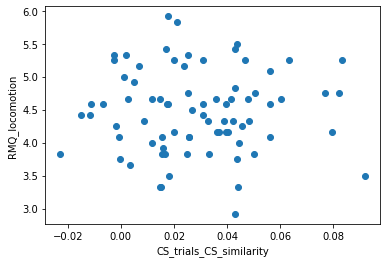

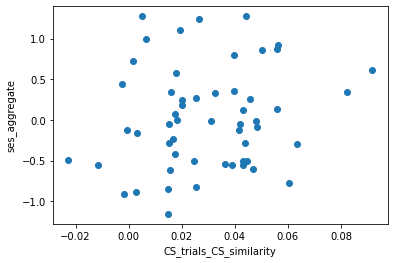

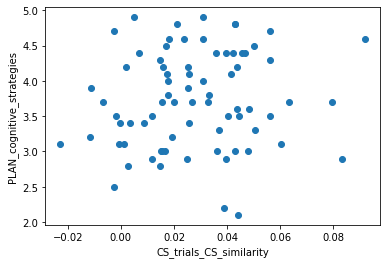

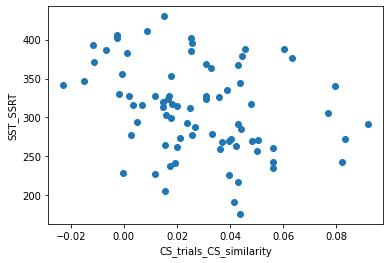

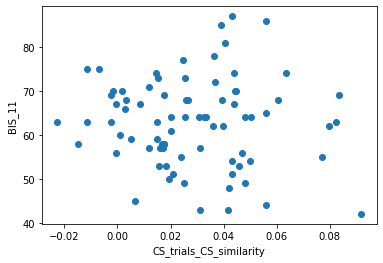

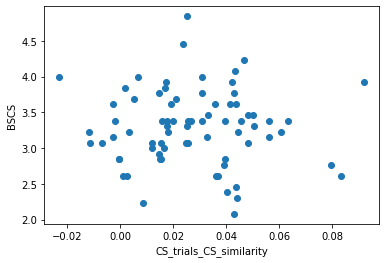

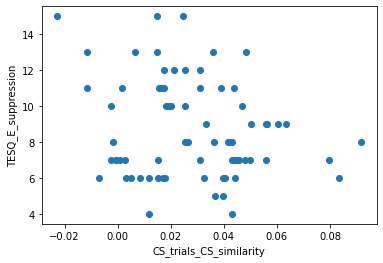

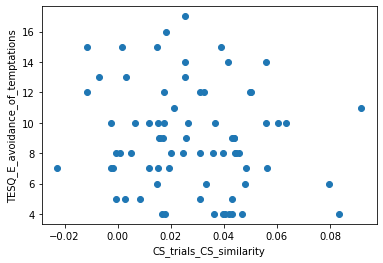

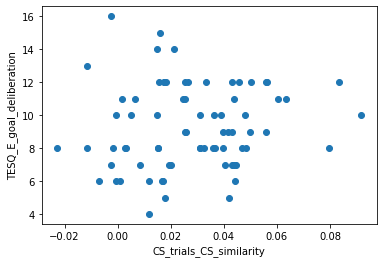

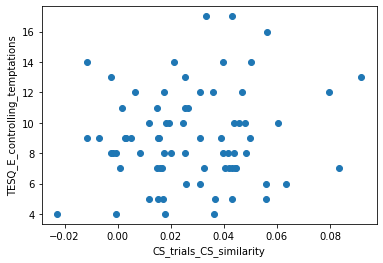

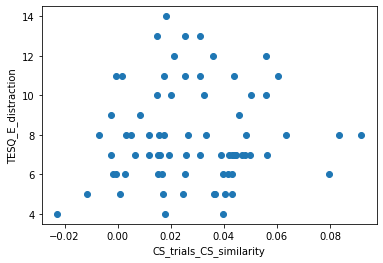

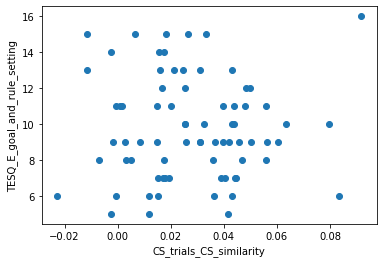

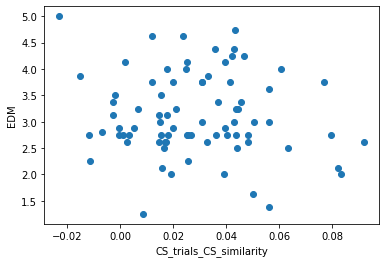

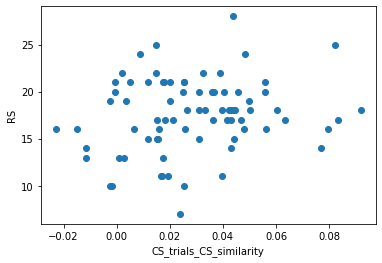

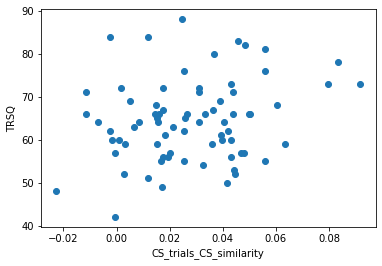

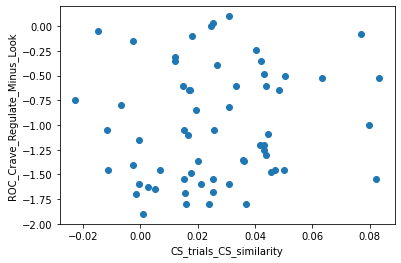

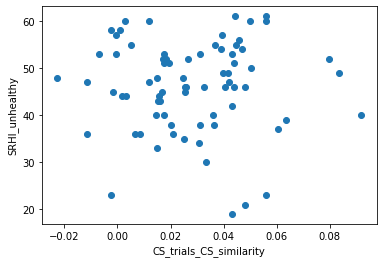

#### CG_trials_CG_similarity

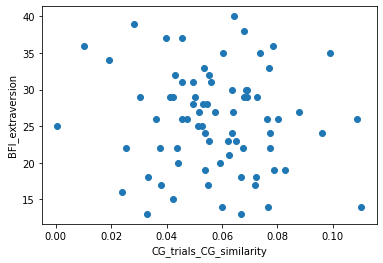

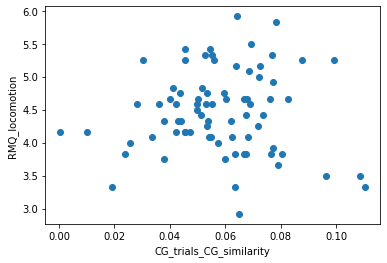

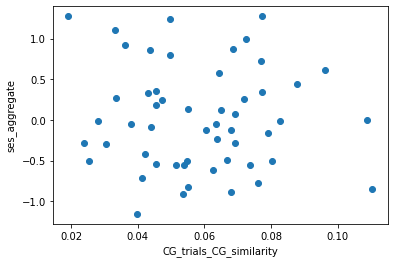

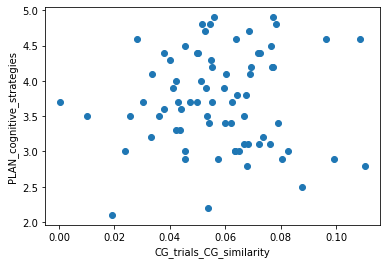

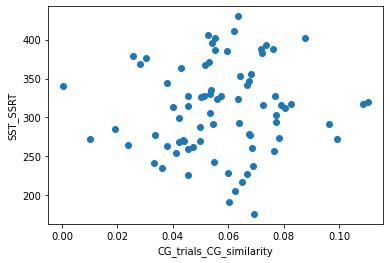

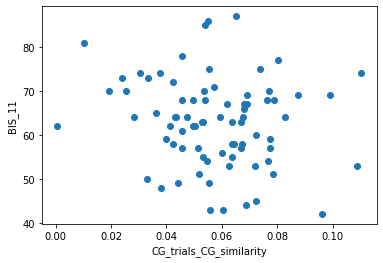

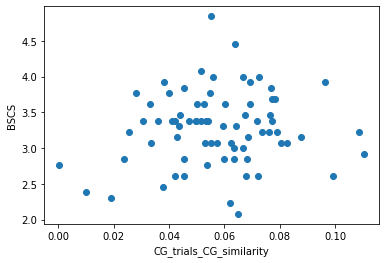

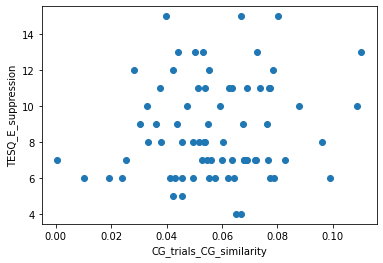

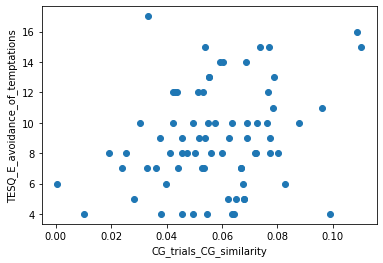

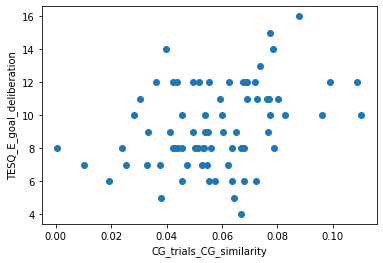

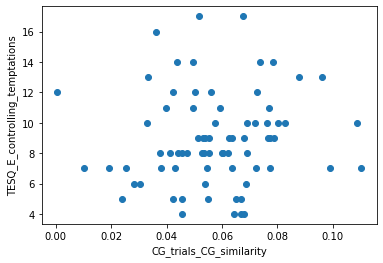

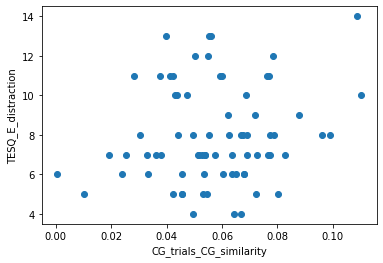

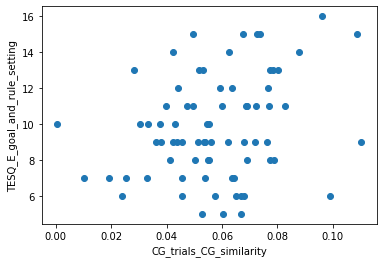

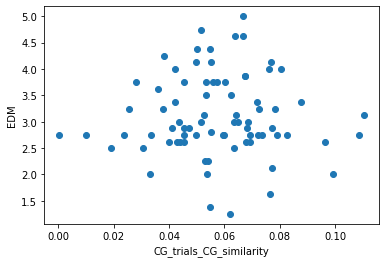

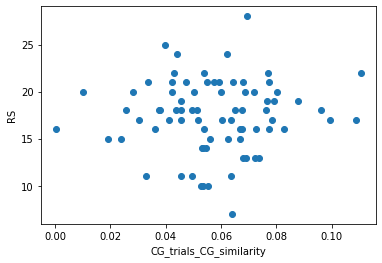

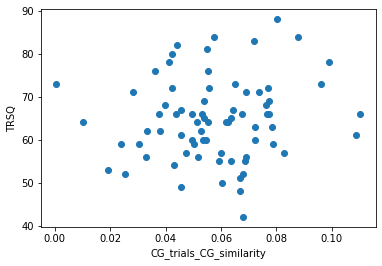

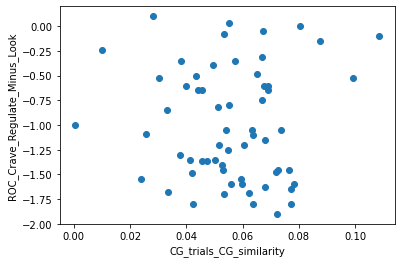

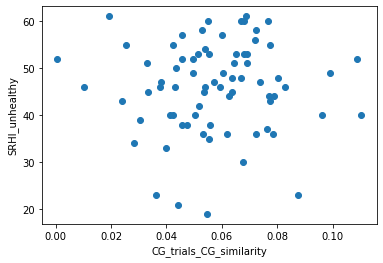

In [72]:
for neural_var in ['CS_trials_CS_similarity','CG_trials_CG_similarity']:
    display(Markdown("#### " + neural_var))
    for correlate in ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies','SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
                      'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction', 'TESQ_E_goal_and_rule_setting',
                     'EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look','SRHI_unhealthy']:
        visualize_corr(neural_var,correlate,ind_div_combined_3sd)


# dot product

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_conditions_84subs_twoclasses_wholebrain.pkl
0.9382716049382716


### correct_stop_ns

### correct_go_ns

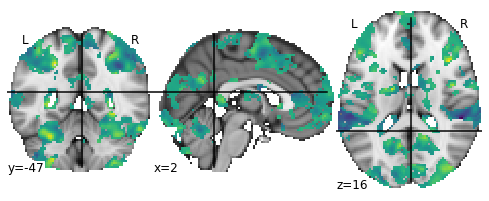

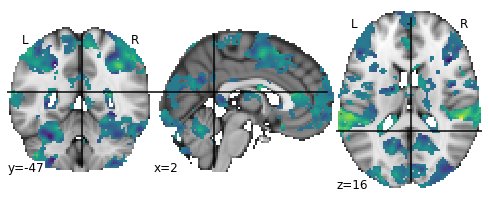

In [73]:

dataset_name = 'conditions'

brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_84subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_43subs_correct_cond.pkl'

#set vars for the function

#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_40subs_twoclasses_pfcmask_repeat1.pkl"
results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_84subs_twoclasses_wholebrain.pkl"
#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_58subs_twoclasses_pfcmask_repeat1.pkl"

def decoderConstructor(*args, **kwargs):
    return(Decoder(scoring='accuracy',verbose=0, *args, **kwargs))


relevant_mask = None


if path.exists(results_filepath) is False:
    apply_loocv_and_save(
        results_filepath = results_filepath,
        brain_data_filepath = brain_data_filepath,
        train_test_markers_filepath = train_test_markers_filepath,
#        subjs_to_use = 60,
        decoderConstructor = decoderConstructor,
        response_transform_func=condition_resp_trans_func
    )
    

print(results_filepath)
results=pickle.load(open(results_filepath,'rb'))

print(np.mean(results[0]))

results[3]

correct_stop_ns=results[3]['CorrectStop']
display(Markdown("### correct_stop_ns"))
plotting.plot_img(correct_stop_ns,threshold='auto',bg_img=background_img)

correct_go_ns=results[3]['CorrectGo']
display(Markdown("### correct_go_ns"))
plotting.plot_img(correct_go_ns,threshold='auto',bg_img=background_img)

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/train_test_results_conditions_84subs_twoclasses_wholebrain.pkl
plotting signatures


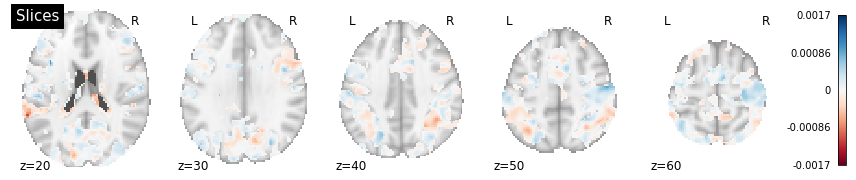

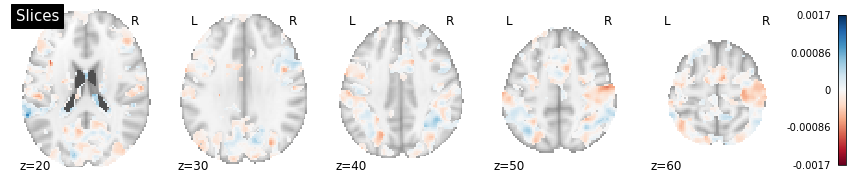

loading data
applying mask
getting similarity 1
getting similarity 2
creating histograms


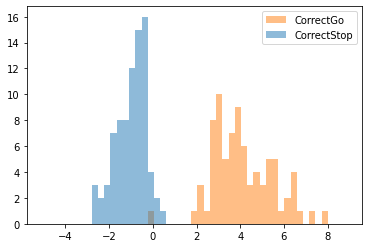

26.0 20.266128342428956 5.733871657571044 46.266128342428956


26.0 20.266128342428956 5.733871657571044 46.266128342428956
76 , 76


76 , 76


4.458333333333335 1.6898243675770521 2.7685089657562827 6.148157700910387


4.458333333333335 1.6898243675770521 2.7685089657562827 6.148157700910387
80 , 79
4.5 1.6895886466474699 2.81041135335253 6.18958864664747
79 , 79


80 , 79
79 , 79


-0.029198517658926098 2.0272800228666514 -2.0564785405255774 1.9980815052077254


-0.029198517658926098 2.0272800228666514 -2.0564785405255774 1.9980815052077254
56 , 55
-0.04359384351429142 1.9200402150485443 -1.9636340585628358 1.8764463715342528
55 , 55


56 , 55
55 , 55


3.7 2.7021504456571925 0.9978495543428076 6.402150445657193


3.7 2.7021504456571925 0.9978495543428076 6.402150445657193
76 , 76


76 , 76


312.9325410023739 182.14878318668306 130.78375781569085 495.081324189057


312.9325410023739 182.14878318668306 130.78375781569085 495.081324189057
79 , 79


79 , 79


63.0 28.16373945961754 34.83626054038246 91.16373945961755


63.0 28.16373945961754 34.83626054038246 91.16373945961755
80 , 80


80 , 80


3.30769230769231 1.4723255633388697 1.8353667443534405 4.78001787103118


3.30769230769231 1.4723255633388697 1.8353667443534405 4.78001787103118
76 , 74
3.30769230769231 1.3852831642481158 1.9224091434441943 4.692975471940426
74 , 74


76 , 75
75 , 75


8.0 9.005773331715183 -1.005773331715183 17.005773331715183


8.0 9.005773331715183 -1.005773331715183 17.005773331715183
75 , 75


75 , 75


8.0 9.005773331715183 -1.005773331715183 17.005773331715183


8.0 9.005773331715183 -1.005773331715183 17.005773331715183
75 , 75


75 , 75


9.0 6.754329998786387 2.245670001213613 15.754329998786387


9.0 6.754329998786387 2.245670001213613 15.754329998786387
75 , 74
9.0 6.753255425709515 2.246744574290485 15.753255425709515
74 , 74


75 , 75


9.0 9.005773331715183 -0.0057733317151829056 18.005773331715183


9.0 9.005773331715183 -0.0057733317151829056 18.005773331715183
75 , 75


75 , 75


7.0 9.005773331715183 -2.005773331715183 16.005773331715183


7.0 9.005773331715183 -2.005773331715183 16.005773331715183
75 , 75


75 , 74
74 , 74


9.0 7.880051665250785 1.119948334749215 16.880051665250786


9.0 7.880051665250785 1.119948334749215 16.880051665250786
75 , 75


75 , 75


2.9375 2.3939178540674906 0.5435821459325094 5.331417854067491


2.9375 2.3939178540674906 0.5435821459325094 5.331417854067491
80 , 80


80 , 80


18.0 10.13753187988482 7.86246812011518 28.13753187988482


18.0 10.13753187988482 7.86246812011518 28.13753187988482
79 , 78
18.0 9.009849835836068 8.990150164163932 27.009849835836068
78 , 77
18.0 9.008526516622485 8.991473483377515 27.008526516622485
77 , 77


79 , 79


64.0 29.268763328074343 34.73123667192566 93.26876332807434


64.0 29.268763328074343 34.73123667192566 93.26876332807434
75 , 75


75 , 75


-1.1 2.0638697020107046 -3.1638697020107047 0.9638697020107045


-1.1 2.0638697020107046 -3.1638697020107047 0.9638697020107045
63 , 63


63 , 63


46.5 29.273296494619604 17.226703505380396 75.7732964946196


46.5 29.273296494619604 17.226703505380396 75.7732964946196
76 , 75
47.0 29.268763328074343 17.731236671925657 76.26876332807434
75 , 75


76 , 75
75 , 75


0.8721357434916861 2.145757709835625 -1.273621966343939 3.017893453327311


0.8721357434916861 2.145757709835625 -1.273621966343939 3.017893453327311
81 , 81


81 , 81


3.956188782622425 4.38224581765842 -0.4260570350359951 8.338434600280845


3.956188782622425 4.38224581765842 -0.4260570350359951 8.338434600280845
81 , 81


81 , 81


-0.3057692307692349 1.3648581430430025 -1.6706273738122372 1.0590889122737677


-0.3057692307692349 1.3648581430430025 -1.6706273738122372 1.0590889122737677
80 , 80


80 , 80


40.15 23.178488718680573 16.971511281319426 63.328488718680575


40.15 23.178488718680573 16.971511281319426 63.328488718680575
72 , 72


72 , 72


In [74]:
print(results_filepath,flush=True)

print("plotting signatures")

plot_stat_maps(correct_stop_ns,correct_go_ns)

print("loading data")

bd=get_bd(brain_data_filepath,correct_stop_ns,correct_go_ns,relevant_mask,'CG_similarity','CS_similarity',similarity_method='dot_product')

create_histogram(bd,similarity1 = 'CG_similarity',similarity2 = 'CS_similarity',condition1 = 'CorrectStop',condition2='CorrectGo')

ind_div_combined = get_ind_div_for_sst(bd,ml_data_folderpath)


ind_div_combined_3sd = remove_selected_outliers_tesq_study(ind_div_combined,show_plot=False)


#### CS_trials_CS_similarity

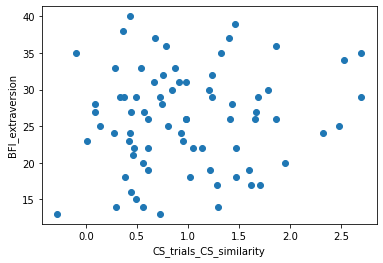

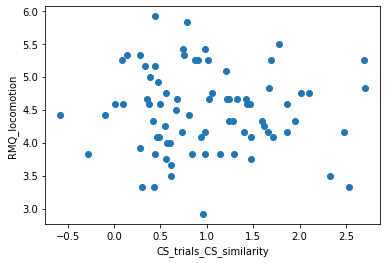

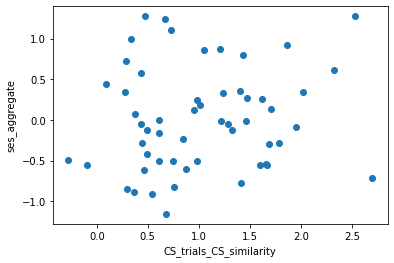

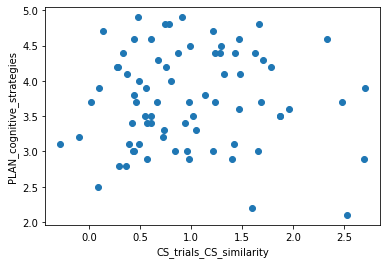

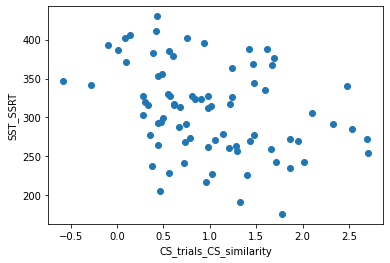

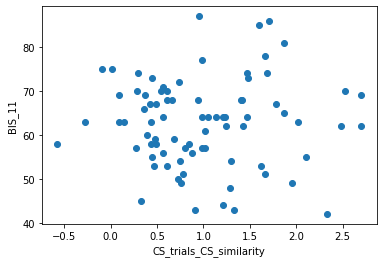

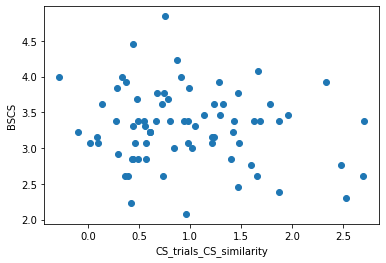

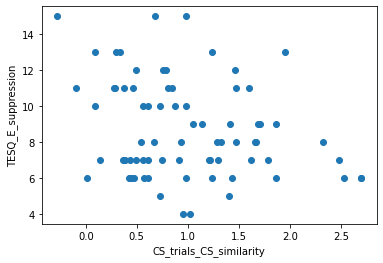

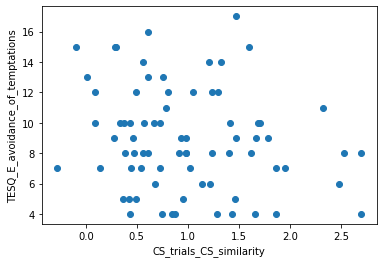

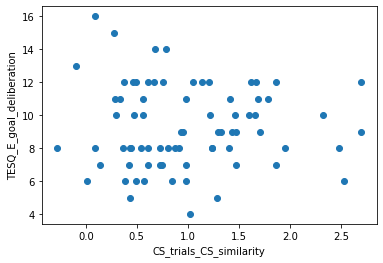

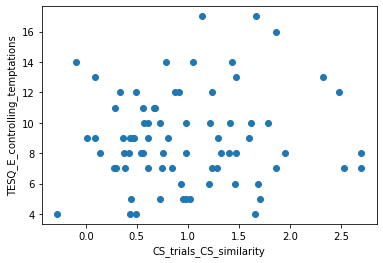

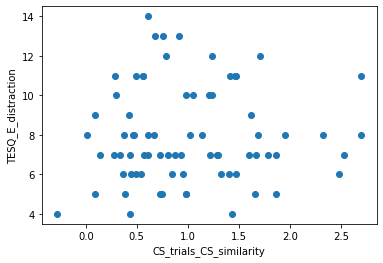

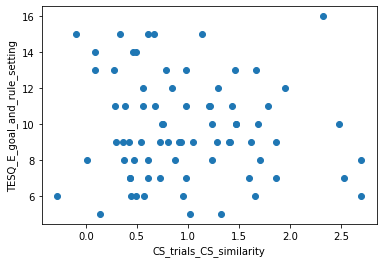

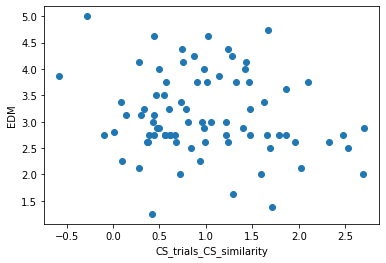

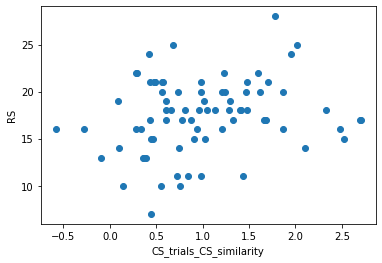

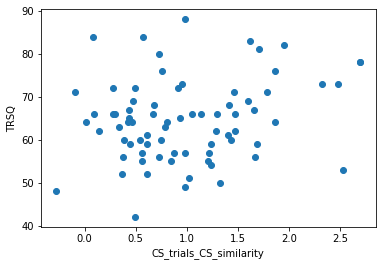

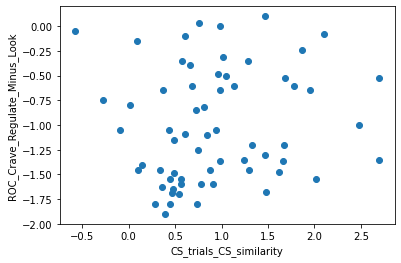

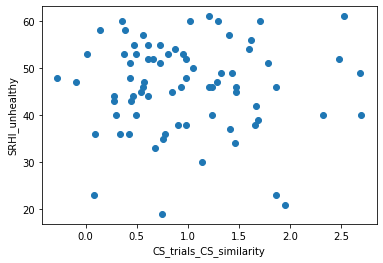

#### CG_trials_CG_similarity

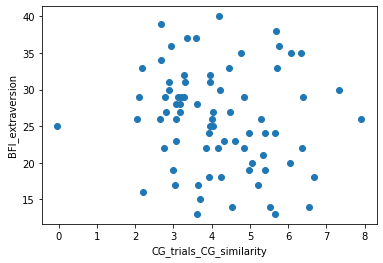

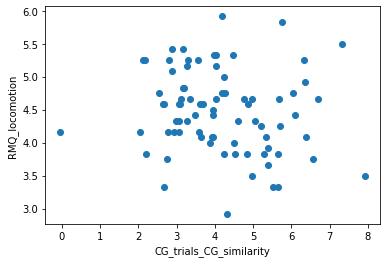

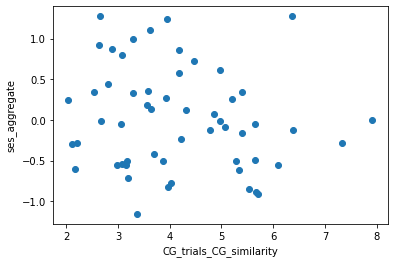

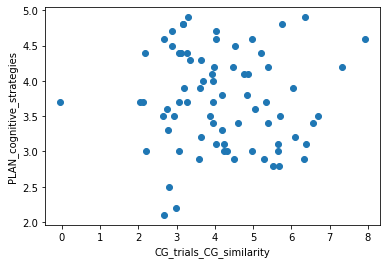

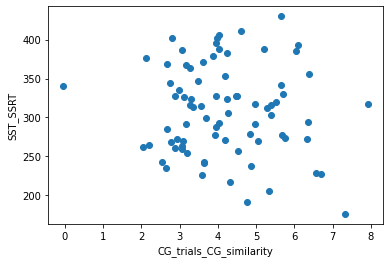

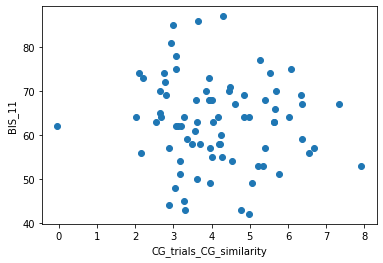

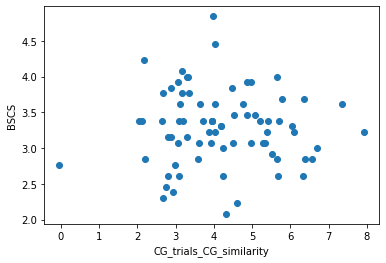

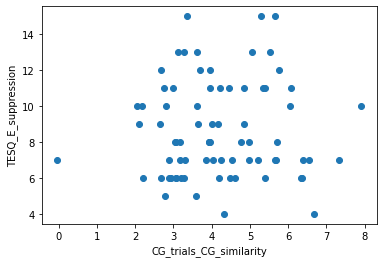

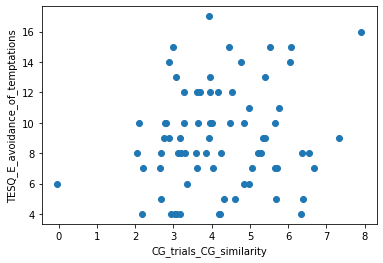

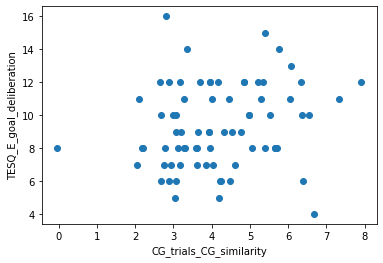

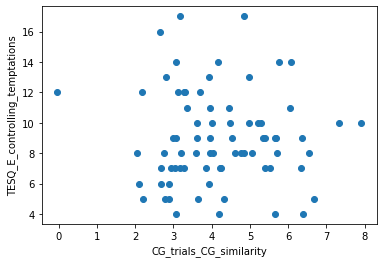

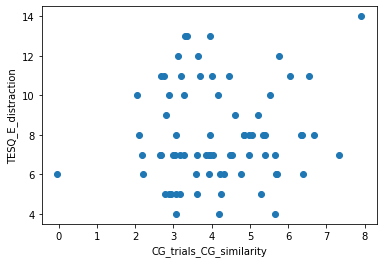

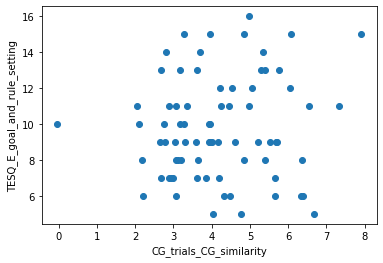

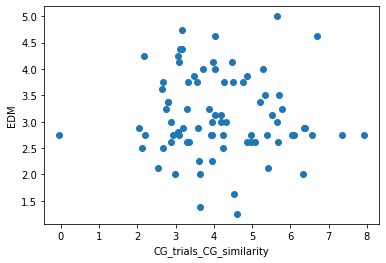

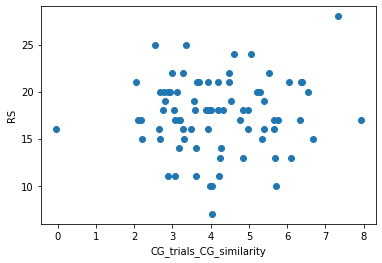

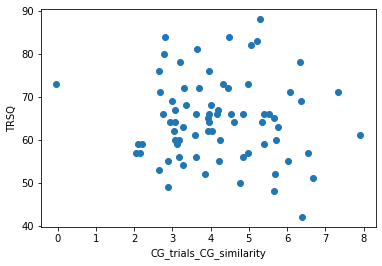

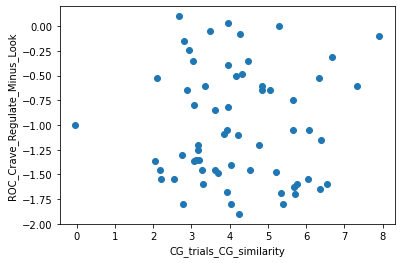

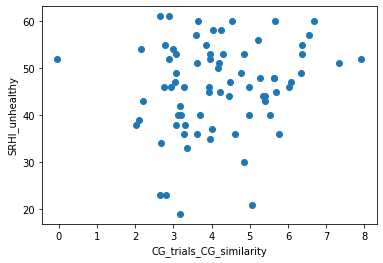

In [75]:
for neural_var in ['CS_trials_CS_similarity','CG_trials_CG_similarity']:
    display(Markdown("#### " + neural_var))
    for correlate in ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies','SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
                      'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction', 'TESQ_E_goal_and_rule_setting',
                     'EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look','SRHI_unhealthy']:
        visualize_corr(neural_var,correlate,ind_div_combined_3sd)


In [81]:
", ".join([str(f) for f in ind_div_combined_3sd.CG_trials_CG_similarity])

'3.0631156038499046, 6.03627669003547, 4.4903570594827045, 2.883230047835947, 2.1112871178873354, 5.767137099556525, 3.9497521922095595, 3.490091227552881, 6.331143079886914, 5.673139351805316, 4.851145729581381, 2.929933424930458, 3.9688283832957945, 4.602799380334686, 3.3086131332144384, 3.612502519378667, 3.938996772461697, 3.2818641918256226, 2.0367635704320834, 3.9276782391712204, 2.54618986821115, 4.269781523292856, 4.227441546692437, 6.086217232903914, 3.701735958576729, 4.242313574613272, 3.072821445564086, 4.026913353961359, 7.917070931859211, 3.0520377167518276, 7.335042473267383, 3.164579748552075, 5.280014625608158, 3.8654079305376436, 6.377473758724952, 3.1685802704100614, 3.6271885162972684, 2.8087826886887295, 3.3598750969177553, 6.354490285310095, 3.956188782622425, 5.33749714538291, 2.987393395213925, 4.854603245246416, 5.061007940838641, 2.6777789786217676, -0.04125335406792552, 2.166767311890651, 2.7572210464354714, 4.53186807162835, 3.644451529591752, 2.205092425790